In [1]:
import sys
import math
import uproot
import operator
import numpy as np
import ROOT  as r
import matplotlib.pyplot as plt
from   scipy.optimize    import leastsq

Welcome to JupyROOT 6.22/00


In [2]:
def deltaphi(e_phi, m_phi) :
    d_phi =  e_phi - m_phi
    if (d_phi >  np.pi) : d_phi -= 2*np.pi
    if (d_phi < -np.pi) : d_phi += 2*np.pi
    return d_phi

In [3]:
def dR(e_phi, e_eta, m_phi, m_eta) :
    d_eta = abs(e_eta - m_eta)
    d_phi = deltaphi(e_phi, m_phi)
    return np.sqrt(d_phi**2 + d_eta**2)

In [4]:
def Convertnuto4vec(nu,i):
    neutrino = ROOT.TLorentzVector()
    Px = nu[0][i][0]
    Py = nu[0][i][1]
    Pz = nu[0][i][2]
    E  = math.sqrt(Px**2 + Py**2 + Pz**2)
    neutrino.SetPxPyPzE(Px,Py,Pz,E)
    return neutrino

In [5]:
# Implemented from https://gitlab.cern.ch/TopAnalysis/Configuration/analysis/common/src/KinematicReconstruction.cc

def angle_rot(e, vect_sm) :                       # alpha should be passed, vect_sm is the smeared 4 vector to returned by reference
    
    #if abs(vect_sm.Px()) < e  : vect_sm.setPx(0)
    #if abs(vect_sm.Py()) < e  : vect_sm.setPy(0)
    #if abs(vect_sm.Pz()) < e  : vect_sm.setPz(0)
    
    alpha = np.random.normal(0, 1)                 # should be related to vect_sm angular resolution
    phi   = 2 * np.pi * np.random.uniform(-1 , 1)   
    pz_1  = vect_sm.Vect().Mag() * np.cos(alpha)
    px_1  = vect_sm.Vect().Mag() * np.sin(alpha) * np.sin(phi)
    py_1  = vect_sm.Vect().Mag() * np.sin(alpha) * np.cos(phi)
    
    if (vect_sm.Py() != 0 or vect_sm.Pz() != 0) :
        d = np.sqrt(vect_sm.Pz()**2 + vect_sm.Py()**2)
        p = vect_sm.Vect().Mag()
        
        x1 = d/p 
        y1 = 0
        z1 = vect_sm.Px() / p
        
        x2 = -(vect_sm.Px() * vect_sm.Py()) / (d * p)
        y2 =   vect_sm.Pz() / d
        z2 =   vect_sm.Py() / p 
        
        x3 = -(vect_sm.Px() * vect_sm.Pz()) / (d * p)
        y3 = - vect_sm.Py() / d
        z3 =   vect_sm.Pz() / p     
        
        vect_sm.SetPx(x1*px_1 + y1*py_1 + z1*pz_1)
        vect_sm.SetPy(x2*px_1 + y2*py_1 + z2*pz_1)
        vect_sm.SetPz(x3*px_1 + y3*py_1 + z3*pz_1)
        vect_sm.SetE(vect_sm.E())
        
        
    if (vect_sm.Px()==0 and vect_sm.Py()==0 and vect_sm.Pz()==0):
        vect_sm.SetPx(vect_sm.Px())
        vect_sm.SetPy(vect_sm.Py())
        vect_sm.SetPz(vect_sm.Pz())
        vect_sm.SetE(vect_sm.E())
    
    if (vect_sm.Px()!=0 and vect_sm.Py()==0 and vect_sm.Pz()==0) : 
        vect_sm.SetPx(pz_1)
        vect_sm.SetPy(px_1)
        vect_sm.SetPz(py_1)
        vect_sm.SetE(vect_sm.E())

In [147]:
# Implemented from https://gitlab.cern.ch/TopAnalysis/Configuration/analysis/common/src/KinematicReconstruction.cc

def try_smear(jet1, jet2, lep1, lep2, metx, mety) :
    
    ttbar_mass = []
    
    #if  ( ((lep1 + lep2).M() > 100) or ((jet1 + jet1).M() > 100) ) : return False
    
    # Define met, not sure what Vx is
    met     = ROOT.TVector3(metx, mety ,0)
    vX_reco = - jet1.Vect() - jet2.Vect() - lep1.Vect() - lep2.Vect() - met
    
    for i in range(100) :
        
        met_sm  = ROOT.TLorentzVector()
        jet1_sm = ROOT.TLorentzVector(jet1)
        jet2_sm = ROOT.TLorentzVector(jet2)
        lep1_sm = ROOT.TLorentzVector(lep1)
        lep2_sm = ROOT.TLorentzVector(lep2)
        
        metV3_sm = ROOT.TVector3()
        
        # Jet energy based smearing 
        #fB1 = np.random.uniform(low= 1.0, high=1.04) # From Jet Energy Resolution
        fB1 = np.random.normal(1.0, 0.10)             # Changed from 0.15 to 0.10 for testing
        xB1 = np.sqrt((fB1**2 * jet1_sm.E()**2 - jet1_sm.M2()) / (jet1_sm.P() ** 2))

        jet1_sm.SetXYZT(jet1_sm.Px()*xB1, jet1_sm.Py()*xB1, jet1_sm.Pz()*xB1, jet1_sm.E()*fB1)
        angle_rot(0.001, jet1_sm)

        #fB2 = np.random.uniform(low= 1.0, high=1.04) # From Jet Energy Resolution
        fB2 = np.random.normal(1.0, 0.10)
        xB2 = np.sqrt((fB2**2 * jet2_sm.E()**2  - jet2_sm.M2()) / (jet2_sm.P() ** 2))

        jet2_sm.SetXYZT(jet2_sm.Px()*xB2, jet2_sm.Py()*xB2, jet2_sm.Pz()*xB2, jet2_sm.E()*fB2)
        angle_rot(0.001, jet2_sm)

        # Lepton energy based smearing 
        #fL1 = np.random.uniform(low= 1.0, high=1.02) # From Lep Energy Resolution
        fL1 = np.random.normal(1.0, 0.03)        
        xL1 = np.sqrt((fL1**2 * lep1_sm.E()**2  - lep1_sm.M2()) / (lep1_sm.P() ** 2))

        lep1_sm.SetXYZT(lep1_sm.Px()*xB1, lep1_sm.Py()*xB1, lep1_sm.Pz()*xB1, lep1_sm.E()*fB1)
        angle_rot(0.001, lep1_sm)

        #fL2 = np.random.uniform(low= 1.0, high=1.02) # From Lep Energy Resolution,
        fL2 = np.random.normal(1.0, 0.03)  
        xL2 = np.sqrt((fL2**2 * lep2_sm.E()**2  - lep2_sm.M2()) / (lep2_sm.P() ** 2))

        lep2_sm.SetXYZT(lep2_sm.Px()*xB2, lep2_sm.Py()*xB2, lep2_sm.Pz()*xB2, lep2_sm.E()*fB2)
        angle_rot(0.001, lep2_sm)

        # Adjust MET so that it is still balanced
        metV3_sm = -jet1_sm.Vect() - jet2_sm.Vect() - lep1_sm.Vect() - lep2_sm.Vect()- vX_reco
        
        met_sm.SetXYZM(metV3_sm.Px(),metV3_sm.Py(),0,0)

        #Maybe see if a solution exists or not
        try    :
            d          = doubleNeutrinoSolutions(jet1_sm, jet2_sm, lep1_sm, lep2_sm, met_sm.Px(), met_sm.Py())
            neutrino1  = Convertnuto4vec(d.nunu_s,0)
            neutrino2  = Convertnuto4vec(d.nunu_s,1)

            top1 = jet1 + lep1 + neutrino1
            top2 = jet2 + lep2 + neutrino2
            ttbar_mass.append((top1   + top2).M())
            
        except np.linalg.LinAlgError :
            # Alternative pairing
            try :
                d_alt      = doubleNeutrinoSolutions(jet2_sm, jet1_sm, lep1_sm, lep2_sm, met_sm.Px(), met_sm.Py())
                neutrino1  = Convertnuto4vec(d_alt.nunu_s,0)
                neutrino2  = Convertnuto4vec(d_alt.nunu_s,1)

                top1 = jet2 + lep1 + neutrino1
                top2 = jet1 + lep2 + neutrino2
                ttbar_mass.append((top1   + top2).M())
                
            except np.linalg.LinAlgError as err:
                if 'Singular matrix' in str(err): 
                    continue
                else:
                    raise

    ttbar_mass = np.array(ttbar_mass)
    if len(ttbar_mass) == 0 :
        return 0
    else : 
        return ttbar_mass

In [7]:
mT = 172.5   # GeV : top quark mass
mW = 80.385  # GeV : W boson mass
mN = 0       # GeV : neutrino mass


def UnitCircle():
    '''Unit circle in extended representation'''
    return np.diag([1, 1, -1])


def cofactor(A, i, j):
    '''Cofactor[i,j] of 3x3 matrix A'''
    a = A[not i:2 if i==2 else None:2 if i==1 else 1,
          not j:2 if j==2 else None:2 if j==1 else 1]
    return (-1)**(i+j) * (a[0,0]*a[1,1] - a[1,0]*a[0,1])


def R(axis, angle):
    '''Rotation matrix about x(0),y(1), or z(2) axis'''
    c, s = math.cos(angle), math.sin(angle)
    R = c * np.eye(3)
    for i in [-1, 0, 1]:
        R[(axis-i) % 3, (axis+i) % 3] = i*s + (1 - i*i)
    return R


def Derivative():
    '''Matrix to differentiate [cos(t),sin(t),1]'''
    return R(2, math.pi / 2).dot(np.diag([1, 1, 0]))


def multisqrt(y):
    '''Valid real solutions to y=x*x'''
    return ([] if y < 0 else
            [0] if y == 0 else
            (lambda r: [-r, r])(math.sqrt(y)))


def factor_degenerate(G, zero=0):
    '''Linear factors of degenerate quadratic polynomial'''
    if G[0,0] == 0 == G[1,1]:
        return [[G[0,1], 0, G[1,2]],
                [0, G[0,1], G[0,2] - G[1,2]]]

    swapXY = abs(G[0,0]) > abs(G[1,1])
    Q = G[(1,0,2),][:,(1,0,2)] if swapXY else G
    Q /= Q[1,1]
    q22 = cofactor(Q, 2, 2)

    if -q22 <= zero:
        lines = [[Q[0,1], Q[1,1], Q[1,2]+s]
                 for s in multisqrt(-cofactor(Q, 0, 0))]
    else:
        x0, y0 = [cofactor(Q, i, 2) / q22 for i in [0, 1]]
        lines = [[m, Q[1,1], -Q[1,1]*y0 - m*x0]
                 for m in [Q[0,1] + s
                           for s in multisqrt(-q22)]]

    return [[L[swapXY],L[not swapXY],L[2]] for L in lines]


def intersections_ellipse_line(ellipse, line, zero=1e-12):
    '''Points of intersection between ellipse and line'''
    _,V = np.linalg.eig(np.cross(line,ellipse).T)
    sols = sorted([(v.real / v[2].real,
                    np.dot(line,v.real)**2 +
                    np.dot(v.real,ellipse).dot(v.real)**2)
                    for v in V.T],
                    key=lambda s: s[1])[:2]
    return [s for s, k in sols if k < zero]


def intersections_ellipses(A, B, returnLines=False):
    '''Points of intersection between two ellipses'''
    LA = np.linalg
    if abs(LA.det(B)) > abs(LA.det(A)): A,B = B,A
    e = next(e.real for e in LA.eigvals(LA.inv(A).dot(B))
             if not e.imag)
    lines = factor_degenerate(B - e*A)
    points = sum([intersections_ellipse_line(A,L)
                  for L in lines],[])
    return (points,lines) if returnLines else points


class nuSolutionSet(object):
    '''Definitions for nu analytic solution, t->b,mu,nu'''

    def __init__(self, b, mu, mW2=mW**2, mT2=mT**2, mN2=mN**2):
        
        c = r.Math.VectorUtil.CosTheta(b,mu)
        s = math.sqrt(1-c**2)

        x0p = - (mT2 - mW2 - b.M2()) / (2*b.E())
        x0  = - (mW2 - mu.M2() - mN2) / (2*mu.E())

        Bb, Bm = b.Beta(), mu.Beta()

        Sx = (x0 * Bm - mu.P()*(1-Bm**2)) / Bm**2
        Sy = (x0p / Bb - c * Sx) / s

        w  = (Bm / Bb - c) / s
        w_ = (-Bm / Bb - c) / s

        Om2  = w**2 + 1 - Bm**2
        eps2 = (mW2 - mN2) * (1 - Bm**2)
        x1   = Sx - (Sx+w*Sy) / Om2
        y1   = Sy - (Sx+w*Sy) * w / Om2
        Z2   = x1**2 * Om2 - (Sy-w*Sx)**2 - (mW2-x0**2-eps2)
        Z    = math.sqrt(max(0, Z2))

        for item in ['b','mu','c','s','x0','x0p',
                     'Sx','Sy','w','w_','x1','y1',
                     'Z','Om2','eps2','mW2']:
            setattr(self, item, eval(item))

    @property
    def K(self):
        '''Extended rotation from F' to F coord.'''
        return np.array([[self.c, -self.s, 0, 0],
                         [self.s,  self.c, 0, 0],
                         [     0,       0, 1, 0],
                         [     0,       0, 0, 1]])

    @property
    def A_mu(self):
        '''F coord. constraint on W momentum: ellipsoid'''
        B2   = self.mu.Beta()**2
        SxB2 = self.Sx * B2
        F    = self.mW2 - self.x0**2 - self.eps2
        return np.array([[1-B2, 0, 0, SxB2],
                         [   0, 1, 0,    0],
                         [   0, 0, 1,    0],
                         [SxB2, 0, 0,    F]])

    @property
    def A_b(self):
        '''F coord. constraint on W momentum: ellipsoid'''
        K, B = self.K, self.b.Beta()
        mW2, x0p = self.mW2, self.x0p
        A_b_ = np.array([[1-B*B,  0,  0,      B*x0p],
                         [    0,  1,  0,          0],
                         [    0,  0,  1,          0],
                         [B*x0p,  0,  0, mW2-x0p**2]])
        return K.dot(A_b_).dot(K.T)

    @property
    def R_T(self):
        '''Rotation from F coord. to laboratory coord.'''
        b_xyz = self.b.X(), self.b.Y(), self.b.Z()
        R_z   = R(2, -self.mu.Phi())
        R_y   = R(1, 0.5*math.pi - self.mu.Theta())
        R_x   = next(R(0,-math.atan2(z,y))
                   for x,y,z in (R_y.dot(R_z.dot(b_xyz)),))
        return R_z.T.dot(R_y.T.dot(R_x.T))

    @property
    def H_tilde(self):
        '''Transformation of t=[c,s,1] to p_nu: F coord.'''
        x1, y1, p = self.x1, self.y1, self.mu.P()
        Z, w, Om  = self.Z , self.w , math.sqrt(self.Om2)
        return np.array([[  Z/Om, 0, x1-p],
                         [w*Z/Om, 0,   y1],
                         [     0, Z,    0]])

    @property
    def H(self):
        '''Transformation of t=[c,s,1] to p_nu: lab coord.'''
        return self.R_T.dot(self.H_tilde)

    @property
    def H_perp(self):
        '''Transformation of t=[c,s,1] to pT_nu: lab coord.'''
        return np.vstack([self.H[:2], [0, 0, 1]])

    @property
    def N(self):
        '''Solution ellipse of pT_nu: lab coord.'''
        HpInv = np.linalg.inv(self.H_perp)
        return HpInv.T.dot(UnitCircle()).dot(HpInv)


class doubleNeutrinoSolutions(object):
    '''Solution pairs of neutrino momenta, tt -> leptons'''
    def __init__(self, b, b_ , mu, mu_, metX, metY, mW2=mW**2, mT2=mT**2):
        
        self.solutionSets = [nuSolutionSet(B, M, mW2, mT2)
                             for B,M in zip((b,b_),(mu,mu_))]

        V0     = np.outer([metX, metY, 0], [0, 0, 1])
        self.S = V0 - UnitCircle()

        N, N_ = [ss.N for ss in self.solutionSets]
        n_    = self.S.T.dot(N_).dot(self.S)

        v  = intersections_ellipses(N, n_)
        v_ = [self.S.dot(sol) for sol in v]

        if not v and leastsq:
            es  = [ss.H_perp for ss in self.solutionSets]
            met = np.array([metX, metY, 1])

            def nus(ts):
                return tuple(e.dot([math.cos(t), math.sin(t), 1])
                             for e, t in zip(es, ts))

            def residuals(params):
                return sum(nus(params), -met)[:2]

            ts,_  = leastsq(residuals, [0, 0], ftol=5e-5, epsfcn=0.01)
            v, v_ = [[i] for i in nus(ts)]
      
        for k, v in {'perp': v, 'perp_': v_, 'n_': n_}.items():
            setattr(self, k, v)

    @property
    def nunu_s(self):
        '''Solution pairs for neutrino momenta'''
        K, K_ = [ss.H.dot(np.linalg.inv(ss.H_perp))
                 for ss in self.solutionSets]
        return [(K.dot(s), K_.dot(s_))
                for s, s_ in zip(self.perp, self.perp_)]

In [8]:
def Convertnuto4vec_new(nu):
    nu_arr = []
    # Solution number, nuetrino number, Px/y/z
    for i in range(len(nu)):
        for j in range(2): 
            neutrino = ROOT.TLorentzVector()
            Px = nu[i][j][0]
            Py = nu[i][j][1]
            Pz = nu[i][j][2]
            E  = math.sqrt(Px**2 + Py**2 + Pz**2)
            neutrino.SetPxPyPzE(Px,Py,Pz,E)
            nu_arr.append(neutrino)
    return nu_arr

In [85]:
tt_ptr        = uproot.open('ttbar_final.root')['Step8']

tt_ST         = tt_ptr['ST'].array()
tt_HT         = tt_ptr['HT'].array()
tt_MET        = tt_ptr['MET'].array()
tt_MET_phi    = tt_ptr['MET_phi'].array()

tt_l_pt       = tt_ptr['l_pt'].array()
tt_l_eta      = tt_ptr['l_eta'].array()
tt_l_phi      = tt_ptr['l_phi'].array()
tt_l_mass     = tt_ptr['l_mass'].array()

tt_sl_pt      = tt_ptr['sl_pt'].array()
tt_sl_eta     = tt_ptr['sl_eta'].array()
tt_sl_phi     = tt_ptr['sl_phi'].array()
tt_sl_mass    = tt_ptr['sl_mass'].array()

tt_ljet_pt    = tt_ptr['ljet_pt'].array()
tt_ljet_eta   = tt_ptr['ljet_eta'].array()
tt_ljet_phi   = tt_ptr['ljet_phi'].array()

tt_sljet_pt   = tt_ptr['sljet_pt'].array()
tt_sljet_eta  = tt_ptr['sljet_eta'].array()
tt_sljet_phi  = tt_ptr['sljet_phi'].array()

## DOESN'T USE MIN MASS

In [ ]:
import ROOT

no_sol    = 0
tt_mass   = []
selection = np.zeros(len(tt_l_eta))
first_pair = 0
sec_pair   = 0
needs_smear= 0 

for i in range (len(tt_l_eta)) :
    
    jet1 = ROOT.TLorentzVector()
    jet2 = ROOT.TLorentzVector()
    lep1 = ROOT.TLorentzVector()
    lep2 = ROOT.TLorentzVector()
    
    top1 = ROOT.TLorentzVector()
    top2 = ROOT.TLorentzVector()
    
    atop1 = ROOT.TLorentzVector()
    atop2 = ROOT.TLorentzVector()
    
    jet1.SetPtEtaPhiM(tt_ljet_pt[i] , tt_ljet_eta[i] , tt_ljet_phi[i] , 5)
    jet2.SetPtEtaPhiM(tt_sljet_pt[i], tt_sljet_eta[i], tt_sljet_phi[i], 5)
    
    lep1.SetPtEtaPhiM(tt_l_pt[i] , tt_l_eta[i] , tt_l_phi[i] , tt_l_mass[i])
    lep2.SetPtEtaPhiM(tt_sl_pt[i], tt_sl_eta[i], tt_sl_phi[i], tt_sl_mass[i])
    
    met_x   =  tt_MET[i] * np.cos(tt_MET_phi[i])
    met_y   =  tt_MET[i] * np.sin(tt_MET_phi[i])

    #Maybe see if a solution exists or not
    try    :
        d          = doubleNeutrinoSolutions(jet1, jet2, lep1, lep2, met_x, met_y)
        neutrino1  = Convertnuto4vec(d.nunu_s,0)
        neutrino2  = Convertnuto4vec(d.nunu_s,1)

        top1 = jet1 + lep1 + neutrino1
        top2 = jet2 + lep2 + neutrino2
        tt_mass.append((top1   + top2).M())
        selection[i] = 1
        first_pair  += 1
        
    except np.linalg.LinAlgError :
        # If not the first pairing, then the other one
        try :
            d_alt      = doubleNeutrinoSolutions(jet2, jet1, lep1, lep2, met_x, met_y)
            neutrino1  = Convertnuto4vec(d_alt.nunu_s,0)
            neutrino2  = Convertnuto4vec(d_alt.nunu_s,1)
        
            top1 = jet2 + lep1 + neutrino1
            top2 = jet1 + lep2 + neutrino2
            tt_mass.append((top1   + top2).M())
            selection[i] = 1
            sec_pair    += 1
        
        except np.linalg.LinAlgError:
            # Finally try smearing by JER or LER
            try :
                tt_min = try_smear(jet1, jet2, lep1, lep2, met_x, met_y)
                tt_mass.append(tt_min)
                selection[i] = 1
                needs_smear += 1
                
            except np.linalg.LinAlgError as err:
                if 'Singular matrix' in str(err): 
                    no_sol += 1
                    continue
                else:
                    raise

In [ ]:
print(first_pair, sec_pair, needs_smear)

## USES MIN MASS

In [241]:
no_sol    = 0
tt_mass   = []
selection = np.zeros(100000)

for i in range (100000) :
    
    #print('Processing event ::' + str(i))
    jet1 = ROOT.TLorentzVector()
    jet2 = ROOT.TLorentzVector()
    lep1 = ROOT.TLorentzVector()
    lep2 = ROOT.TLorentzVector()
    
    top1 = ROOT.TLorentzVector()
    top2 = ROOT.TLorentzVector()
    
    atop1 = ROOT.TLorentzVector()
    atop2 = ROOT.TLorentzVector()
    
    jet1.SetPtEtaPhiM(tt_ljet_pt[i] , tt_ljet_eta[i] , tt_ljet_phi[i] , 5)
    jet2.SetPtEtaPhiM(tt_sljet_pt[i], tt_sljet_eta[i], tt_sljet_phi[i], 5)
    
    lep1.SetPtEtaPhiM(tt_l_pt[i] , tt_l_eta[i] , tt_l_phi[i] , tt_l_mass[i])
    lep2.SetPtEtaPhiM(tt_sl_pt[i], tt_sl_eta[i], tt_sl_phi[i], tt_sl_mass[i])
    
    met_x   =  tt_MET[i] * np.cos(tt_MET_phi[i])
    met_y   =  tt_MET[i] * np.sin(tt_MET_phi[i])

    min_mass = []
    
    #Maybe see if a solution exists or not
    try    :
        d            = doubleNeutrinoSolutions(jet1, jet2, lep1, lep2, met_x, met_y)
        neutrino_arr = Convertnuto4vec_new(d.nunu_s)
        
        for i in range(0, len(neutrino_arr), 2) :
            top1 = jet1 + lep1 + neutrino_arr[i]
            top2 = jet2 + lep2 + neutrino_arr[i+1]
            min_mass.append((top1   + top2).M())
        #print('Used the first pairing')
        selection[i] = 1
        
    except np.linalg.LinAlgError :
        # If not the first pairing, then the other one
        try :
            d_alt            = doubleNeutrinoSolutions(jet2, jet1, lep1, lep2, met_x, met_y)
            neutrino_arr_alt = Convertnuto4vec_new(d_alt.nunu_s)

            for i in range(0, len(neutrino_arr_alt), 2) :
                top1 = jet1 + lep1 + neutrino_arr_alt[i]
                top2 = jet2 + lep2 + neutrino_arr_alt[i+1]
                min_mass.append((top1   + top2).M())          
            #print('Used the second pairing')
            selection[i] = 1

        
        except np.linalg.LinAlgError:
            # Finally try smearing by JER or LER
            try :
                tt_min = try_smear(jet1, jet2, lep1, lep2, met_x, met_y)
                min_mass.append(tt_min)
                selection[i] = 1
                
            except np.linalg.LinAlgError as err:
                if 'Singular matrix' in str(err): 
                    no_sol += 1
                    print('Had to smear, appending 0')
                    min_mass.append(0)
                    continue
                else:
                    raise
                    
    # Finally append the smallest mass
    min_mass = np.array(min_mass)
    tt_mass.append(min_mass.min())

Processing event ::0
Processing event ::1
Processing event ::2
Processing event ::3
Processing event ::4
Processing event ::5
Processing event ::6
Processing event ::7
Processing event ::8
Processing event ::9
Processing event ::10
Processing event ::11
Processing event ::12
Processing event ::13
Processing event ::14
Processing event ::15
Processing event ::16
Processing event ::17
Processing event ::18
Processing event ::19
Processing event ::20


<ipython-input-6-d2c98e6ea2ab>:59: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return [[L[swapXY],L[not swapXY],L[2]] for L in lines]


Processing event ::21
Processing event ::22
Processing event ::23
Processing event ::24
Processing event ::25
Processing event ::26
Processing event ::27
Processing event ::28
Processing event ::29
Processing event ::30
Processing event ::31
Processing event ::32
Processing event ::33
Processing event ::34
Processing event ::35
Processing event ::36
Processing event ::37
Processing event ::38
Processing event ::39
Processing event ::40
Processing event ::41
Processing event ::42
Processing event ::43
Processing event ::44
Processing event ::45
Processing event ::46
Processing event ::47
Processing event ::48
Processing event ::49
Processing event ::50
Processing event ::51
Processing event ::52
Processing event ::53
Processing event ::54
Processing event ::55
Processing event ::56
Processing event ::57
Processing event ::58
Processing event ::59
Processing event ::60
Processing event ::61
Processing event ::62
Processing event ::63
Processing event ::64
Processing event ::65
Processing

Processing event ::387
Processing event ::388
Processing event ::389
Processing event ::390
Processing event ::391
Processing event ::392
Processing event ::393
Processing event ::394
Processing event ::395
Processing event ::396
Processing event ::397
Processing event ::398
Processing event ::399
Processing event ::400
Processing event ::401
Processing event ::402
Processing event ::403
Processing event ::404
Processing event ::405
Processing event ::406
Processing event ::407
Processing event ::408
Processing event ::409
Processing event ::410
Processing event ::411
Processing event ::412
Processing event ::413
Processing event ::414
Processing event ::415
Processing event ::416
Processing event ::417
Processing event ::418
Processing event ::419
Processing event ::420
Processing event ::421
Processing event ::422
Processing event ::423
Processing event ::424
Processing event ::425
Processing event ::426
Processing event ::427
Processing event ::428
Processing event ::429
Processing 

/Users/amandeepsinghbakshi/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:475: RuntimeWarning: Number of calls to function has reached maxfev = 600.
  warnings.warn(errors[info][0], RuntimeWarning)


Processing event ::660
Processing event ::661
Processing event ::662
Processing event ::663
Processing event ::664
Processing event ::665
Processing event ::666
Processing event ::667
Processing event ::668
Processing event ::669
Processing event ::670
Processing event ::671
Processing event ::672
Processing event ::673
Processing event ::674
Processing event ::675
Processing event ::676
Processing event ::677
Processing event ::678
Processing event ::679
Processing event ::680
Processing event ::681
Processing event ::682
Processing event ::683
Processing event ::684
Processing event ::685
Processing event ::686
Processing event ::687
Processing event ::688
Processing event ::689
Processing event ::690
Processing event ::691
Processing event ::692
Processing event ::693
Processing event ::694
Processing event ::695
Processing event ::696
Processing event ::697
Processing event ::698
Processing event ::699
Processing event ::700
Processing event ::701
Processing event ::702
Processing 

Processing event ::1049
Processing event ::1050
Processing event ::1051
Processing event ::1052
Processing event ::1053
Processing event ::1054
Processing event ::1055
Processing event ::1056
Processing event ::1057
Processing event ::1058
Processing event ::1059
Processing event ::1060
Processing event ::1061
Processing event ::1062
Processing event ::1063
Processing event ::1064
Processing event ::1065
Processing event ::1066
Processing event ::1067
Processing event ::1068
Processing event ::1069
Processing event ::1070
Processing event ::1071
Processing event ::1072
Processing event ::1073
Processing event ::1074
Processing event ::1075
Processing event ::1076
Processing event ::1077
Processing event ::1078
Processing event ::1079
Processing event ::1080
Processing event ::1081
Processing event ::1082
Processing event ::1083
Processing event ::1084
Processing event ::1085
Processing event ::1086
Processing event ::1087
Processing event ::1088
Processing event ::1089
Processing event

Processing event ::1407
Processing event ::1408
Processing event ::1409
Processing event ::1410
Processing event ::1411
Processing event ::1412
Processing event ::1413
Processing event ::1414
Processing event ::1415
Processing event ::1416
Processing event ::1417
Processing event ::1418
Processing event ::1419
Processing event ::1420
Processing event ::1421
Processing event ::1422
Processing event ::1423
Processing event ::1424
Processing event ::1425
Processing event ::1426
Processing event ::1427
Processing event ::1428
Processing event ::1429
Processing event ::1430
Processing event ::1431
Processing event ::1432
Processing event ::1433
Processing event ::1434
Processing event ::1435
Processing event ::1436
Processing event ::1437
Processing event ::1438
Processing event ::1439
Processing event ::1440
Processing event ::1441
Processing event ::1442
Processing event ::1443
Processing event ::1444
Processing event ::1445
Processing event ::1446
Processing event ::1447
Processing event

Processing event ::1759
Processing event ::1760
Processing event ::1761
Processing event ::1762
Processing event ::1763
Processing event ::1764
Processing event ::1765
Processing event ::1766
Processing event ::1767
Processing event ::1768
Processing event ::1769
Processing event ::1770
Processing event ::1771
Processing event ::1772
Processing event ::1773
Processing event ::1774
Processing event ::1775
Processing event ::1776
Processing event ::1777
Processing event ::1778
Processing event ::1779
Processing event ::1780
Processing event ::1781
Processing event ::1782
Processing event ::1783
Processing event ::1784
Processing event ::1785
Processing event ::1786
Processing event ::1787
Processing event ::1788
Processing event ::1789
Processing event ::1790
Processing event ::1791
Processing event ::1792
Processing event ::1793
Processing event ::1794
Processing event ::1795
Processing event ::1796
Processing event ::1797
Processing event ::1798
Processing event ::1799
Processing event

Processing event ::2104
Processing event ::2105
Processing event ::2106
Processing event ::2107
Processing event ::2108
Processing event ::2109
Processing event ::2110
Processing event ::2111
Processing event ::2112
Processing event ::2113
Processing event ::2114
Processing event ::2115
Processing event ::2116
Processing event ::2117
Processing event ::2118
Processing event ::2119
Processing event ::2120
Processing event ::2121
Processing event ::2122
Processing event ::2123
Processing event ::2124
Processing event ::2125
Processing event ::2126
Processing event ::2127
Processing event ::2128
Processing event ::2129
Processing event ::2130
Processing event ::2131
Processing event ::2132
Processing event ::2133
Processing event ::2134
Processing event ::2135
Processing event ::2136
Processing event ::2137
Processing event ::2138
Processing event ::2139
Processing event ::2140
Processing event ::2141
Processing event ::2142
Processing event ::2143
Processing event ::2144
Processing event

Processing event ::2458
Processing event ::2459
Processing event ::2460
Processing event ::2461
Processing event ::2462
Processing event ::2463
Processing event ::2464
Processing event ::2465
Processing event ::2466
Processing event ::2467
Processing event ::2468
Processing event ::2469
Processing event ::2470
Processing event ::2471
Processing event ::2472
Processing event ::2473
Processing event ::2474
Processing event ::2475
Processing event ::2476
Processing event ::2477
Processing event ::2478
Processing event ::2479
Processing event ::2480
Processing event ::2481
Processing event ::2482
Processing event ::2483
Processing event ::2484
Processing event ::2485
Processing event ::2486
Processing event ::2487
Processing event ::2488
Processing event ::2489
Processing event ::2490
Processing event ::2491
Processing event ::2492
Processing event ::2493
Processing event ::2494
Processing event ::2495
Processing event ::2496
Processing event ::2497
Processing event ::2498
Processing event

Processing event ::2806
Processing event ::2807
Processing event ::2808
Processing event ::2809
Processing event ::2810
Processing event ::2811
Processing event ::2812
Processing event ::2813
Processing event ::2814
Processing event ::2815
Processing event ::2816
Processing event ::2817
Processing event ::2818
Processing event ::2819
Processing event ::2820
Processing event ::2821
Processing event ::2822
Processing event ::2823
Processing event ::2824
Processing event ::2825
Processing event ::2826
Processing event ::2827
Processing event ::2828
Processing event ::2829
Processing event ::2830
Processing event ::2831
Processing event ::2832
Processing event ::2833
Processing event ::2834
Processing event ::2835
Processing event ::2836
Processing event ::2837
Processing event ::2838
Processing event ::2839
Processing event ::2840
Processing event ::2841
Processing event ::2842
Processing event ::2843
Processing event ::2844
Processing event ::2845
Processing event ::2846
Processing event

Processing event ::3171
Processing event ::3172
Processing event ::3173
Processing event ::3174
Processing event ::3175
Processing event ::3176
Processing event ::3177
Processing event ::3178
Processing event ::3179
Processing event ::3180
Processing event ::3181
Processing event ::3182
Processing event ::3183
Processing event ::3184
Processing event ::3185
Processing event ::3186
Processing event ::3187
Processing event ::3188
Processing event ::3189
Processing event ::3190
Processing event ::3191
Processing event ::3192
Processing event ::3193
Processing event ::3194
Processing event ::3195
Processing event ::3196
Processing event ::3197
Processing event ::3198
Processing event ::3199
Processing event ::3200
Processing event ::3201
Processing event ::3202
Processing event ::3203
Processing event ::3204
Processing event ::3205
Processing event ::3206
Processing event ::3207
Processing event ::3208
Processing event ::3209
Processing event ::3210
Processing event ::3211
Processing event

Processing event ::3523
Processing event ::3524
Processing event ::3525
Processing event ::3526
Processing event ::3527
Processing event ::3528
Processing event ::3529
Processing event ::3530
Processing event ::3531
Processing event ::3532
Processing event ::3533
Processing event ::3534
Processing event ::3535
Processing event ::3536
Processing event ::3537
Processing event ::3538
Processing event ::3539
Processing event ::3540
Processing event ::3541
Processing event ::3542
Processing event ::3543
Processing event ::3544
Processing event ::3545
Processing event ::3546
Processing event ::3547
Processing event ::3548
Processing event ::3549
Processing event ::3550
Processing event ::3551
Processing event ::3552
Processing event ::3553
Processing event ::3554
Processing event ::3555
Processing event ::3556
Processing event ::3557
Processing event ::3558
Processing event ::3559
Processing event ::3560
Processing event ::3561
Processing event ::3562
Processing event ::3563
Processing event

Processing event ::3880
Processing event ::3881
Processing event ::3882
Processing event ::3883
Processing event ::3884
Processing event ::3885
Processing event ::3886
Processing event ::3887
Processing event ::3888
Processing event ::3889
Processing event ::3890
Processing event ::3891
Processing event ::3892
Processing event ::3893
Processing event ::3894
Processing event ::3895
Processing event ::3896
Processing event ::3897
Processing event ::3898
Processing event ::3899
Processing event ::3900
Processing event ::3901
Processing event ::3902
Processing event ::3903
Processing event ::3904
Processing event ::3905
Processing event ::3906
Processing event ::3907
Processing event ::3908
Processing event ::3909
Processing event ::3910
Processing event ::3911
Processing event ::3912
Processing event ::3913
Processing event ::3914
Processing event ::3915
Processing event ::3916
Processing event ::3917
Processing event ::3918
Processing event ::3919
Processing event ::3920
Processing event

Processing event ::4243
Processing event ::4244
Processing event ::4245
Processing event ::4246
Processing event ::4247
Processing event ::4248
Processing event ::4249
Processing event ::4250
Processing event ::4251
Processing event ::4252
Processing event ::4253
Processing event ::4254
Processing event ::4255
Processing event ::4256
Processing event ::4257
Processing event ::4258
Processing event ::4259
Processing event ::4260
Processing event ::4261
Processing event ::4262
Processing event ::4263
Processing event ::4264
Processing event ::4265
Processing event ::4266
Processing event ::4267
Processing event ::4268
Processing event ::4269
Processing event ::4270
Processing event ::4271
Processing event ::4272
Processing event ::4273
Processing event ::4274
Processing event ::4275
Processing event ::4276
Processing event ::4277
Processing event ::4278
Processing event ::4279
Processing event ::4280
Processing event ::4281
Processing event ::4282
Processing event ::4283
Processing event

Processing event ::4600
Processing event ::4601
Processing event ::4602
Processing event ::4603
Processing event ::4604
Processing event ::4605
Processing event ::4606
Processing event ::4607
Processing event ::4608
Processing event ::4609
Processing event ::4610
Processing event ::4611
Processing event ::4612
Processing event ::4613
Processing event ::4614
Processing event ::4615
Processing event ::4616
Processing event ::4617
Processing event ::4618
Processing event ::4619
Processing event ::4620
Processing event ::4621
Processing event ::4622
Processing event ::4623
Processing event ::4624
Processing event ::4625
Processing event ::4626
Processing event ::4627
Processing event ::4628
Processing event ::4629
Processing event ::4630
Processing event ::4631
Processing event ::4632
Processing event ::4633
Processing event ::4634
Processing event ::4635
Processing event ::4636
Processing event ::4637
Processing event ::4638
Processing event ::4639
Processing event ::4640
Processing event

Processing event ::4952
Processing event ::4953
Processing event ::4954
Processing event ::4955
Processing event ::4956
Processing event ::4957
Processing event ::4958
Processing event ::4959
Processing event ::4960
Processing event ::4961
Processing event ::4962
Processing event ::4963
Processing event ::4964
Processing event ::4965
Processing event ::4966
Processing event ::4967
Processing event ::4968
Processing event ::4969
Processing event ::4970
Processing event ::4971
Processing event ::4972
Processing event ::4973
Processing event ::4974
Processing event ::4975
Processing event ::4976
Processing event ::4977
Processing event ::4978
Processing event ::4979
Processing event ::4980
Processing event ::4981
Processing event ::4982
Processing event ::4983
Processing event ::4984
Processing event ::4985
Processing event ::4986
Processing event ::4987
Processing event ::4988
Processing event ::4989
Processing event ::4990
Processing event ::4991
Processing event ::4992
Processing event

Processing event ::5317
Processing event ::5318
Processing event ::5319
Processing event ::5320
Processing event ::5321
Processing event ::5322
Processing event ::5323
Processing event ::5324
Processing event ::5325
Processing event ::5326
Processing event ::5327
Processing event ::5328
Processing event ::5329
Processing event ::5330
Processing event ::5331
Processing event ::5332
Processing event ::5333
Processing event ::5334
Processing event ::5335
Processing event ::5336
Processing event ::5337
Processing event ::5338
Processing event ::5339
Processing event ::5340
Processing event ::5341
Processing event ::5342
Processing event ::5343
Processing event ::5344
Processing event ::5345
Processing event ::5346
Processing event ::5347
Processing event ::5348
Processing event ::5349
Processing event ::5350
Processing event ::5351
Processing event ::5352
Processing event ::5353
Processing event ::5354
Processing event ::5355
Processing event ::5356
Processing event ::5357
Processing event

Processing event ::5679
Processing event ::5680
Processing event ::5681
Processing event ::5682
Processing event ::5683
Processing event ::5684
Processing event ::5685
Processing event ::5686
Processing event ::5687
Processing event ::5688
Processing event ::5689
Processing event ::5690
Processing event ::5691
Processing event ::5692
Processing event ::5693
Processing event ::5694
Processing event ::5695
Processing event ::5696
Processing event ::5697
Processing event ::5698
Processing event ::5699
Processing event ::5700
Processing event ::5701
Processing event ::5702
Processing event ::5703
Processing event ::5704
Processing event ::5705
Processing event ::5706
Processing event ::5707
Processing event ::5708
Processing event ::5709
Processing event ::5710
Processing event ::5711
Processing event ::5712
Processing event ::5713
Processing event ::5714
Processing event ::5715
Processing event ::5716
Processing event ::5717
Processing event ::5718
Processing event ::5719
Processing event

Processing event ::6038
Processing event ::6039
Processing event ::6040
Processing event ::6041
Processing event ::6042
Processing event ::6043
Processing event ::6044
Processing event ::6045
Processing event ::6046
Processing event ::6047
Processing event ::6048
Processing event ::6049
Processing event ::6050
Processing event ::6051
Processing event ::6052
Processing event ::6053
Processing event ::6054
Processing event ::6055
Processing event ::6056
Processing event ::6057
Processing event ::6058
Processing event ::6059
Processing event ::6060
Processing event ::6061
Processing event ::6062
Processing event ::6063
Processing event ::6064
Processing event ::6065
Processing event ::6066
Processing event ::6067
Processing event ::6068
Processing event ::6069
Processing event ::6070
Processing event ::6071
Processing event ::6072
Processing event ::6073
Processing event ::6074
Processing event ::6075
Processing event ::6076
Processing event ::6077
Processing event ::6078
Processing event

Processing event ::6397
Processing event ::6398
Processing event ::6399
Processing event ::6400
Processing event ::6401
Processing event ::6402
Processing event ::6403
Processing event ::6404
Processing event ::6405
Processing event ::6406
Processing event ::6407
Processing event ::6408
Processing event ::6409
Processing event ::6410
Processing event ::6411
Processing event ::6412
Processing event ::6413
Processing event ::6414
Processing event ::6415
Processing event ::6416
Processing event ::6417
Processing event ::6418
Processing event ::6419
Processing event ::6420
Processing event ::6421
Processing event ::6422
Processing event ::6423
Processing event ::6424
Processing event ::6425
Processing event ::6426
Processing event ::6427
Processing event ::6428
Processing event ::6429
Processing event ::6430
Processing event ::6431
Processing event ::6432
Processing event ::6433
Processing event ::6434
Processing event ::6435
Processing event ::6436
Processing event ::6437
Processing event

Processing event ::6747
Processing event ::6748
Processing event ::6749
Processing event ::6750
Processing event ::6751
Processing event ::6752
Processing event ::6753
Processing event ::6754
Processing event ::6755
Processing event ::6756
Processing event ::6757
Processing event ::6758
Processing event ::6759
Processing event ::6760
Processing event ::6761
Processing event ::6762
Processing event ::6763
Processing event ::6764
Processing event ::6765
Processing event ::6766
Processing event ::6767
Processing event ::6768
Processing event ::6769
Processing event ::6770
Processing event ::6771
Processing event ::6772
Processing event ::6773
Processing event ::6774
Processing event ::6775
Processing event ::6776
Processing event ::6777
Processing event ::6778
Processing event ::6779
Processing event ::6780
Processing event ::6781
Processing event ::6782
Processing event ::6783
Processing event ::6784
Processing event ::6785
Processing event ::6786
Processing event ::6787
Processing event

Processing event ::7114
Processing event ::7115
Processing event ::7116
Processing event ::7117
Processing event ::7118
Processing event ::7119
Processing event ::7120
Processing event ::7121
Processing event ::7122
Processing event ::7123
Processing event ::7124
Processing event ::7125
Processing event ::7126
Processing event ::7127
Processing event ::7128
Processing event ::7129
Processing event ::7130
Processing event ::7131
Processing event ::7132
Processing event ::7133
Processing event ::7134
Processing event ::7135
Processing event ::7136
Processing event ::7137
Processing event ::7138
Processing event ::7139
Processing event ::7140
Processing event ::7141
Processing event ::7142
Processing event ::7143
Processing event ::7144
Processing event ::7145
Processing event ::7146
Processing event ::7147
Processing event ::7148
Processing event ::7149
Processing event ::7150
Processing event ::7151
Processing event ::7152
Processing event ::7153
Processing event ::7154
Processing event

Processing event ::7484
Processing event ::7485
Processing event ::7486
Processing event ::7487
Processing event ::7488
Processing event ::7489
Processing event ::7490
Processing event ::7491
Processing event ::7492
Processing event ::7493
Processing event ::7494
Processing event ::7495
Processing event ::7496
Processing event ::7497
Processing event ::7498
Processing event ::7499
Processing event ::7500
Processing event ::7501
Processing event ::7502
Processing event ::7503
Processing event ::7504
Processing event ::7505
Processing event ::7506
Processing event ::7507
Processing event ::7508
Processing event ::7509
Processing event ::7510
Processing event ::7511
Processing event ::7512
Processing event ::7513
Processing event ::7514
Processing event ::7515
Processing event ::7516
Processing event ::7517
Processing event ::7518
Processing event ::7519
Processing event ::7520
Processing event ::7521
Processing event ::7522
Processing event ::7523
Processing event ::7524
Processing event

Processing event ::7841
Processing event ::7842
Processing event ::7843
Processing event ::7844
Processing event ::7845
Processing event ::7846
Processing event ::7847
Processing event ::7848
Processing event ::7849
Processing event ::7850
Processing event ::7851
Processing event ::7852
Processing event ::7853
Processing event ::7854
Processing event ::7855
Processing event ::7856
Processing event ::7857
Processing event ::7858
Processing event ::7859
Processing event ::7860
Processing event ::7861
Processing event ::7862
Processing event ::7863
Processing event ::7864
Processing event ::7865
Processing event ::7866
Processing event ::7867
Processing event ::7868
Processing event ::7869
Processing event ::7870
Processing event ::7871
Processing event ::7872
Processing event ::7873
Processing event ::7874
Processing event ::7875
Processing event ::7876
Processing event ::7877
Processing event ::7878
Processing event ::7879
Processing event ::7880
Processing event ::7881
Processing event

Processing event ::8191
Processing event ::8192
Processing event ::8193
Processing event ::8194
Processing event ::8195
Processing event ::8196
Processing event ::8197
Processing event ::8198
Processing event ::8199
Processing event ::8200
Processing event ::8201
Processing event ::8202
Processing event ::8203
Processing event ::8204
Processing event ::8205
Processing event ::8206
Processing event ::8207
Processing event ::8208
Processing event ::8209
Processing event ::8210
Processing event ::8211
Processing event ::8212
Processing event ::8213
Processing event ::8214
Processing event ::8215
Processing event ::8216
Processing event ::8217
Processing event ::8218
Processing event ::8219
Processing event ::8220
Processing event ::8221
Processing event ::8222
Processing event ::8223
Processing event ::8224
Processing event ::8225
Processing event ::8226
Processing event ::8227
Processing event ::8228
Processing event ::8229
Processing event ::8230
Processing event ::8231
Processing event

Processing event ::8548
Processing event ::8549
Processing event ::8550
Processing event ::8551
Processing event ::8552
Processing event ::8553
Processing event ::8554
Processing event ::8555
Processing event ::8556
Processing event ::8557
Processing event ::8558
Processing event ::8559
Processing event ::8560
Processing event ::8561
Processing event ::8562
Processing event ::8563
Processing event ::8564
Processing event ::8565
Processing event ::8566
Processing event ::8567
Processing event ::8568
Processing event ::8569
Processing event ::8570
Processing event ::8571
Processing event ::8572
Processing event ::8573
Processing event ::8574
Processing event ::8575
Processing event ::8576
Processing event ::8577
Processing event ::8578
Processing event ::8579
Processing event ::8580
Processing event ::8581
Processing event ::8582
Processing event ::8583
Processing event ::8584
Processing event ::8585
Processing event ::8586
Processing event ::8587
Processing event ::8588
Processing event

Processing event ::8893
Processing event ::8894
Processing event ::8895
Processing event ::8896
Processing event ::8897
Processing event ::8898
Processing event ::8899
Processing event ::8900
Processing event ::8901
Processing event ::8902
Processing event ::8903
Processing event ::8904
Processing event ::8905
Processing event ::8906
Processing event ::8907
Processing event ::8908
Processing event ::8909
Processing event ::8910
Processing event ::8911
Processing event ::8912
Processing event ::8913
Processing event ::8914
Processing event ::8915
Processing event ::8916
Processing event ::8917
Processing event ::8918
Processing event ::8919
Processing event ::8920
Processing event ::8921
Processing event ::8922
Processing event ::8923
Processing event ::8924
Processing event ::8925
Processing event ::8926
Processing event ::8927
Processing event ::8928
Processing event ::8929
Processing event ::8930
Processing event ::8931
Processing event ::8932
Processing event ::8933
Processing event

Processing event ::9253
Processing event ::9254
Processing event ::9255
Processing event ::9256
Processing event ::9257
Processing event ::9258
Processing event ::9259
Processing event ::9260
Processing event ::9261
Processing event ::9262
Processing event ::9263
Processing event ::9264
Processing event ::9265
Processing event ::9266
Processing event ::9267
Processing event ::9268
Processing event ::9269
Processing event ::9270
Processing event ::9271
Processing event ::9272
Processing event ::9273
Processing event ::9274
Processing event ::9275
Processing event ::9276
Processing event ::9277
Processing event ::9278
Processing event ::9279
Processing event ::9280
Processing event ::9281
Processing event ::9282
Processing event ::9283
Processing event ::9284
Processing event ::9285
Processing event ::9286
Processing event ::9287
Processing event ::9288
Processing event ::9289
Processing event ::9290
Processing event ::9291
Processing event ::9292
Processing event ::9293
Processing event

Processing event ::9613
Processing event ::9614
Processing event ::9615
Processing event ::9616
Processing event ::9617
Processing event ::9618
Processing event ::9619
Processing event ::9620
Processing event ::9621
Processing event ::9622
Processing event ::9623
Processing event ::9624
Processing event ::9625
Processing event ::9626
Processing event ::9627
Processing event ::9628
Processing event ::9629
Processing event ::9630
Processing event ::9631
Processing event ::9632
Processing event ::9633
Processing event ::9634
Processing event ::9635
Processing event ::9636
Processing event ::9637
Processing event ::9638
Processing event ::9639
Processing event ::9640
Processing event ::9641
Processing event ::9642
Processing event ::9643
Processing event ::9644
Processing event ::9645
Processing event ::9646
Processing event ::9647
Processing event ::9648
Processing event ::9649
Processing event ::9650
Processing event ::9651
Processing event ::9652
Processing event ::9653
Processing event

Processing event ::9972
Processing event ::9973
Processing event ::9974
Processing event ::9975
Processing event ::9976
Processing event ::9977
Processing event ::9978
Processing event ::9979
Processing event ::9980
Processing event ::9981
Processing event ::9982
Processing event ::9983
Processing event ::9984
Processing event ::9985
Processing event ::9986
Processing event ::9987
Processing event ::9988
Processing event ::9989
Processing event ::9990
Processing event ::9991
Processing event ::9992
Processing event ::9993
Processing event ::9994
Processing event ::9995
Processing event ::9996
Processing event ::9997
Processing event ::9998
Processing event ::9999
Processing event ::10000
Processing event ::10001
Processing event ::10002
Processing event ::10003
Processing event ::10004
Processing event ::10005
Processing event ::10006
Processing event ::10007
Processing event ::10008
Processing event ::10009
Processing event ::10010
Processing event ::10011
Processing event ::10012
Pro

Processing event ::10317
Processing event ::10318
Processing event ::10319
Processing event ::10320
Processing event ::10321
Processing event ::10322
Processing event ::10323
Processing event ::10324
Processing event ::10325
Processing event ::10326
Processing event ::10327
Processing event ::10328
Processing event ::10329
Processing event ::10330
Processing event ::10331
Processing event ::10332
Processing event ::10333
Processing event ::10334
Processing event ::10335
Processing event ::10336
Processing event ::10337
Processing event ::10338
Processing event ::10339
Processing event ::10340
Processing event ::10341
Processing event ::10342
Processing event ::10343
Processing event ::10344
Processing event ::10345
Processing event ::10346
Processing event ::10347
Processing event ::10348
Processing event ::10349
Processing event ::10350
Processing event ::10351
Processing event ::10352
Processing event ::10353
Processing event ::10354
Processing event ::10355
Processing event ::10356


Processing event ::10652
Processing event ::10653
Processing event ::10654
Processing event ::10655
Processing event ::10656
Processing event ::10657
Processing event ::10658
Processing event ::10659
Processing event ::10660
Processing event ::10661
Processing event ::10662
Processing event ::10663
Processing event ::10664
Processing event ::10665
Processing event ::10666
Processing event ::10667
Processing event ::10668
Processing event ::10669
Processing event ::10670
Processing event ::10671
Processing event ::10672
Processing event ::10673
Processing event ::10674
Processing event ::10675
Processing event ::10676
Processing event ::10677
Processing event ::10678
Processing event ::10679
Processing event ::10680
Processing event ::10681
Processing event ::10682
Processing event ::10683
Processing event ::10684
Processing event ::10685
Processing event ::10686
Processing event ::10687
Processing event ::10688
Processing event ::10689
Processing event ::10690
Processing event ::10691


Processing event ::10986
Processing event ::10987
Processing event ::10988
Processing event ::10989
Processing event ::10990
Processing event ::10991
Processing event ::10992
Processing event ::10993
Processing event ::10994
Processing event ::10995
Processing event ::10996
Processing event ::10997
Processing event ::10998
Processing event ::10999
Processing event ::11000
Processing event ::11001
Processing event ::11002
Processing event ::11003
Processing event ::11004
Processing event ::11005
Processing event ::11006
Processing event ::11007
Processing event ::11008
Processing event ::11009
Processing event ::11010
Processing event ::11011
Processing event ::11012
Processing event ::11013
Processing event ::11014
Processing event ::11015
Processing event ::11016
Processing event ::11017
Processing event ::11018
Processing event ::11019
Processing event ::11020
Processing event ::11021
Processing event ::11022
Processing event ::11023
Processing event ::11024
Processing event ::11025


Processing event ::11341
Processing event ::11342
Processing event ::11343
Processing event ::11344
Processing event ::11345
Processing event ::11346
Processing event ::11347
Processing event ::11348
Processing event ::11349
Processing event ::11350
Processing event ::11351
Processing event ::11352
Processing event ::11353
Processing event ::11354
Processing event ::11355
Processing event ::11356
Processing event ::11357
Processing event ::11358
Processing event ::11359
Processing event ::11360
Processing event ::11361
Processing event ::11362
Processing event ::11363
Processing event ::11364
Processing event ::11365
Processing event ::11366
Processing event ::11367
Processing event ::11368
Processing event ::11369
Processing event ::11370
Processing event ::11371
Processing event ::11372
Processing event ::11373
Processing event ::11374
Processing event ::11375
Processing event ::11376
Processing event ::11377
Processing event ::11378
Processing event ::11379
Processing event ::11380


Processing event ::11690
Processing event ::11691
Processing event ::11692
Processing event ::11693
Processing event ::11694
Processing event ::11695
Processing event ::11696
Processing event ::11697
Processing event ::11698
Processing event ::11699
Processing event ::11700
Processing event ::11701
Processing event ::11702
Processing event ::11703
Processing event ::11704
Processing event ::11705
Processing event ::11706
Processing event ::11707
Processing event ::11708
Processing event ::11709
Processing event ::11710
Processing event ::11711
Processing event ::11712
Processing event ::11713
Processing event ::11714
Processing event ::11715
Processing event ::11716
Processing event ::11717
Processing event ::11718
Processing event ::11719
Processing event ::11720
Processing event ::11721
Processing event ::11722
Processing event ::11723
Processing event ::11724
Processing event ::11725
Processing event ::11726
Processing event ::11727
Processing event ::11728
Processing event ::11729


Processing event ::12038
Processing event ::12039
Processing event ::12040
Processing event ::12041
Processing event ::12042
Processing event ::12043
Processing event ::12044
Processing event ::12045
Processing event ::12046
Processing event ::12047
Processing event ::12048
Processing event ::12049
Processing event ::12050
Processing event ::12051
Processing event ::12052
Processing event ::12053
Processing event ::12054
Processing event ::12055
Processing event ::12056
Processing event ::12057
Processing event ::12058
Processing event ::12059
Processing event ::12060
Processing event ::12061
Processing event ::12062
Processing event ::12063
Processing event ::12064
Processing event ::12065
Processing event ::12066
Processing event ::12067
Processing event ::12068
Processing event ::12069
Processing event ::12070
Processing event ::12071
Processing event ::12072
Processing event ::12073
Processing event ::12074
Processing event ::12075
Processing event ::12076
Processing event ::12077


Processing event ::12374
Processing event ::12375
Processing event ::12376
Processing event ::12377
Processing event ::12378
Processing event ::12379
Processing event ::12380
Processing event ::12381
Processing event ::12382
Processing event ::12383
Processing event ::12384
Processing event ::12385
Processing event ::12386
Processing event ::12387
Processing event ::12388
Processing event ::12389
Processing event ::12390
Processing event ::12391
Processing event ::12392
Processing event ::12393
Processing event ::12394
Processing event ::12395
Processing event ::12396
Processing event ::12397
Processing event ::12398
Processing event ::12399
Processing event ::12400
Processing event ::12401
Processing event ::12402
Processing event ::12403
Processing event ::12404
Processing event ::12405
Processing event ::12406
Processing event ::12407
Processing event ::12408
Processing event ::12409
Processing event ::12410
Processing event ::12411
Processing event ::12412
Processing event ::12413


Processing event ::12728
Processing event ::12729
Processing event ::12730
Processing event ::12731
Processing event ::12732
Processing event ::12733
Processing event ::12734
Processing event ::12735
Processing event ::12736
Processing event ::12737
Processing event ::12738
Processing event ::12739
Processing event ::12740
Processing event ::12741
Processing event ::12742
Processing event ::12743
Processing event ::12744
Processing event ::12745
Processing event ::12746
Processing event ::12747
Processing event ::12748
Processing event ::12749
Processing event ::12750
Processing event ::12751
Processing event ::12752
Processing event ::12753
Processing event ::12754
Processing event ::12755
Processing event ::12756
Processing event ::12757
Processing event ::12758
Processing event ::12759
Processing event ::12760
Processing event ::12761
Processing event ::12762
Processing event ::12763
Processing event ::12764
Processing event ::12765
Processing event ::12766
Processing event ::12767


Processing event ::13062
Processing event ::13063
Processing event ::13064
Processing event ::13065
Processing event ::13066
Processing event ::13067
Processing event ::13068
Processing event ::13069
Processing event ::13070
Processing event ::13071
Processing event ::13072
Processing event ::13073
Processing event ::13074
Processing event ::13075
Processing event ::13076
Processing event ::13077
Processing event ::13078
Processing event ::13079
Processing event ::13080
Processing event ::13081
Processing event ::13082
Processing event ::13083
Processing event ::13084
Processing event ::13085
Processing event ::13086
Processing event ::13087
Processing event ::13088
Processing event ::13089
Processing event ::13090
Processing event ::13091
Processing event ::13092
Processing event ::13093
Processing event ::13094
Processing event ::13095
Processing event ::13096
Processing event ::13097
Processing event ::13098
Processing event ::13099
Processing event ::13100
Processing event ::13101


Processing event ::13402
Processing event ::13403
Processing event ::13404
Processing event ::13405
Processing event ::13406
Processing event ::13407
Processing event ::13408
Processing event ::13409
Processing event ::13410
Processing event ::13411
Processing event ::13412
Processing event ::13413
Processing event ::13414
Processing event ::13415
Processing event ::13416
Processing event ::13417
Processing event ::13418
Processing event ::13419
Processing event ::13420
Processing event ::13421
Processing event ::13422
Processing event ::13423
Processing event ::13424
Processing event ::13425
Processing event ::13426
Processing event ::13427
Processing event ::13428
Processing event ::13429
Processing event ::13430
Processing event ::13431
Processing event ::13432
Processing event ::13433
Processing event ::13434
Processing event ::13435
Processing event ::13436
Processing event ::13437
Processing event ::13438
Processing event ::13439
Processing event ::13440
Processing event ::13441


Processing event ::13752
Processing event ::13753
Processing event ::13754
Processing event ::13755
Processing event ::13756
Processing event ::13757
Processing event ::13758
Processing event ::13759
Processing event ::13760
Processing event ::13761
Processing event ::13762
Processing event ::13763
Processing event ::13764
Processing event ::13765
Processing event ::13766
Processing event ::13767
Processing event ::13768
Processing event ::13769
Processing event ::13770
Processing event ::13771
Processing event ::13772
Processing event ::13773
Processing event ::13774
Processing event ::13775
Processing event ::13776
Processing event ::13777
Processing event ::13778
Processing event ::13779
Processing event ::13780
Processing event ::13781
Processing event ::13782
Processing event ::13783
Processing event ::13784
Processing event ::13785
Processing event ::13786
Processing event ::13787
Processing event ::13788
Processing event ::13789
Processing event ::13790
Processing event ::13791


Processing event ::14082
Processing event ::14083
Processing event ::14084
Processing event ::14085
Processing event ::14086
Processing event ::14087
Processing event ::14088
Processing event ::14089
Processing event ::14090
Processing event ::14091
Processing event ::14092
Processing event ::14093
Processing event ::14094
Processing event ::14095
Processing event ::14096
Processing event ::14097
Processing event ::14098
Processing event ::14099
Processing event ::14100
Processing event ::14101
Processing event ::14102
Processing event ::14103
Processing event ::14104
Processing event ::14105
Processing event ::14106
Processing event ::14107
Processing event ::14108
Processing event ::14109
Processing event ::14110
Processing event ::14111
Processing event ::14112
Processing event ::14113
Processing event ::14114
Processing event ::14115
Processing event ::14116
Processing event ::14117
Processing event ::14118
Processing event ::14119
Processing event ::14120
Processing event ::14121


Processing event ::14418
Processing event ::14419
Processing event ::14420
Processing event ::14421
Processing event ::14422
Processing event ::14423
Processing event ::14424
Processing event ::14425
Processing event ::14426
Processing event ::14427
Processing event ::14428
Processing event ::14429
Processing event ::14430
Processing event ::14431
Processing event ::14432
Processing event ::14433
Processing event ::14434
Processing event ::14435
Processing event ::14436
Processing event ::14437
Processing event ::14438
Processing event ::14439
Processing event ::14440
Processing event ::14441
Processing event ::14442
Processing event ::14443
Processing event ::14444
Processing event ::14445
Processing event ::14446
Processing event ::14447
Processing event ::14448
Processing event ::14449
Processing event ::14450
Processing event ::14451
Processing event ::14452
Processing event ::14453
Processing event ::14454
Processing event ::14455
Processing event ::14456
Processing event ::14457


Processing event ::14747
Processing event ::14748
Processing event ::14749
Processing event ::14750
Processing event ::14751
Processing event ::14752
Processing event ::14753
Processing event ::14754
Processing event ::14755
Processing event ::14756
Processing event ::14757
Processing event ::14758
Processing event ::14759
Processing event ::14760
Processing event ::14761
Processing event ::14762
Processing event ::14763
Processing event ::14764
Processing event ::14765
Processing event ::14766
Processing event ::14767
Processing event ::14768
Processing event ::14769
Processing event ::14770
Processing event ::14771
Processing event ::14772
Processing event ::14773
Processing event ::14774
Processing event ::14775
Processing event ::14776
Processing event ::14777
Processing event ::14778
Processing event ::14779
Processing event ::14780
Processing event ::14781
Processing event ::14782
Processing event ::14783
Processing event ::14784
Processing event ::14785
Processing event ::14786


Processing event ::15088
Processing event ::15089
Processing event ::15090
Processing event ::15091
Processing event ::15092
Processing event ::15093
Processing event ::15094
Processing event ::15095
Processing event ::15096
Processing event ::15097
Processing event ::15098
Processing event ::15099
Processing event ::15100
Processing event ::15101
Processing event ::15102
Processing event ::15103
Processing event ::15104
Processing event ::15105
Processing event ::15106
Processing event ::15107
Processing event ::15108
Processing event ::15109
Processing event ::15110
Processing event ::15111
Processing event ::15112
Processing event ::15113
Processing event ::15114
Processing event ::15115
Processing event ::15116
Processing event ::15117
Processing event ::15118
Processing event ::15119
Processing event ::15120
Processing event ::15121
Processing event ::15122
Processing event ::15123
Processing event ::15124
Processing event ::15125
Processing event ::15126
Processing event ::15127


Processing event ::15420
Processing event ::15421
Processing event ::15422
Processing event ::15423
Processing event ::15424
Processing event ::15425
Processing event ::15426
Processing event ::15427
Processing event ::15428
Processing event ::15429
Processing event ::15430
Processing event ::15431
Processing event ::15432
Processing event ::15433
Processing event ::15434
Processing event ::15435
Processing event ::15436
Processing event ::15437
Processing event ::15438
Processing event ::15439
Processing event ::15440
Processing event ::15441
Processing event ::15442
Processing event ::15443
Processing event ::15444
Processing event ::15445
Processing event ::15446
Processing event ::15447
Processing event ::15448
Processing event ::15449
Processing event ::15450
Processing event ::15451
Processing event ::15452
Processing event ::15453
Processing event ::15454
Processing event ::15455
Processing event ::15456
Processing event ::15457
Processing event ::15458
Processing event ::15459


Processing event ::15762
Processing event ::15763
Processing event ::15764
Processing event ::15765
Processing event ::15766
Processing event ::15767
Processing event ::15768
Processing event ::15769
Processing event ::15770
Processing event ::15771
Processing event ::15772
Processing event ::15773
Processing event ::15774
Processing event ::15775
Processing event ::15776
Processing event ::15777
Processing event ::15778
Processing event ::15779
Processing event ::15780
Processing event ::15781
Processing event ::15782
Processing event ::15783
Processing event ::15784
Processing event ::15785
Processing event ::15786
Processing event ::15787
Processing event ::15788
Processing event ::15789
Processing event ::15790
Processing event ::15791
Processing event ::15792
Processing event ::15793
Processing event ::15794
Processing event ::15795
Processing event ::15796
Processing event ::15797
Processing event ::15798
Processing event ::15799
Processing event ::15800
Processing event ::15801


Processing event ::16117
Processing event ::16118
Processing event ::16119
Processing event ::16120
Processing event ::16121
Processing event ::16122
Processing event ::16123
Processing event ::16124
Processing event ::16125
Processing event ::16126
Processing event ::16127
Processing event ::16128
Processing event ::16129
Processing event ::16130
Processing event ::16131
Processing event ::16132
Processing event ::16133
Processing event ::16134
Processing event ::16135
Processing event ::16136
Processing event ::16137
Processing event ::16138
Processing event ::16139
Processing event ::16140
Processing event ::16141
Processing event ::16142
Processing event ::16143
Processing event ::16144
Processing event ::16145
Processing event ::16146
Processing event ::16147
Processing event ::16148
Processing event ::16149
Processing event ::16150
Processing event ::16151
Processing event ::16152
Processing event ::16153
Processing event ::16154
Processing event ::16155
Processing event ::16156


Processing event ::16466
Processing event ::16467
Processing event ::16468
Processing event ::16469
Processing event ::16470
Processing event ::16471
Processing event ::16472
Processing event ::16473
Processing event ::16474
Processing event ::16475
Processing event ::16476
Processing event ::16477
Processing event ::16478
Processing event ::16479
Processing event ::16480
Processing event ::16481
Processing event ::16482
Processing event ::16483
Processing event ::16484
Processing event ::16485
Processing event ::16486
Processing event ::16487
Processing event ::16488
Processing event ::16489
Processing event ::16490
Processing event ::16491
Processing event ::16492
Processing event ::16493
Processing event ::16494
Processing event ::16495
Processing event ::16496
Processing event ::16497
Processing event ::16498
Processing event ::16499
Processing event ::16500
Processing event ::16501
Processing event ::16502
Processing event ::16503
Processing event ::16504
Processing event ::16505


Processing event ::16794
Processing event ::16795
Processing event ::16796
Processing event ::16797
Processing event ::16798
Processing event ::16799
Processing event ::16800
Processing event ::16801
Processing event ::16802
Processing event ::16803
Processing event ::16804
Processing event ::16805
Processing event ::16806
Processing event ::16807
Processing event ::16808
Processing event ::16809
Processing event ::16810
Processing event ::16811
Processing event ::16812
Processing event ::16813
Processing event ::16814
Processing event ::16815
Processing event ::16816
Processing event ::16817
Processing event ::16818
Processing event ::16819
Processing event ::16820
Processing event ::16821
Processing event ::16822
Processing event ::16823
Processing event ::16824
Processing event ::16825
Processing event ::16826
Processing event ::16827
Processing event ::16828
Processing event ::16829
Processing event ::16830
Processing event ::16831
Processing event ::16832
Processing event ::16833


Processing event ::17131
Processing event ::17132
Processing event ::17133
Processing event ::17134
Processing event ::17135
Processing event ::17136
Processing event ::17137
Processing event ::17138
Processing event ::17139
Processing event ::17140
Processing event ::17141
Processing event ::17142
Processing event ::17143
Processing event ::17144
Processing event ::17145
Processing event ::17146
Processing event ::17147
Processing event ::17148
Processing event ::17149
Processing event ::17150
Processing event ::17151
Processing event ::17152
Processing event ::17153
Processing event ::17154
Processing event ::17155
Processing event ::17156
Processing event ::17157
Processing event ::17158
Processing event ::17159
Processing event ::17160
Processing event ::17161
Processing event ::17162
Processing event ::17163
Processing event ::17164
Processing event ::17165
Processing event ::17166
Processing event ::17167
Processing event ::17168
Processing event ::17169
Processing event ::17170


Processing event ::17491
Processing event ::17492
Processing event ::17493
Processing event ::17494
Processing event ::17495
Processing event ::17496
Processing event ::17497
Processing event ::17498
Processing event ::17499
Processing event ::17500
Processing event ::17501
Processing event ::17502
Processing event ::17503
Processing event ::17504
Processing event ::17505
Processing event ::17506
Processing event ::17507
Processing event ::17508
Processing event ::17509
Processing event ::17510
Processing event ::17511
Processing event ::17512
Processing event ::17513
Processing event ::17514
Processing event ::17515
Processing event ::17516
Processing event ::17517
Processing event ::17518
Processing event ::17519
Processing event ::17520
Processing event ::17521
Processing event ::17522
Processing event ::17523
Processing event ::17524
Processing event ::17525
Processing event ::17526
Processing event ::17527
Processing event ::17528
Processing event ::17529
Processing event ::17530


Processing event ::17837
Processing event ::17838
Processing event ::17839
Processing event ::17840
Processing event ::17841
Processing event ::17842
Processing event ::17843
Processing event ::17844
Processing event ::17845
Processing event ::17846
Processing event ::17847
Processing event ::17848
Processing event ::17849
Processing event ::17850
Processing event ::17851
Processing event ::17852
Processing event ::17853
Processing event ::17854
Processing event ::17855
Processing event ::17856
Processing event ::17857
Processing event ::17858
Processing event ::17859
Processing event ::17860
Processing event ::17861
Processing event ::17862
Processing event ::17863
Processing event ::17864
Processing event ::17865
Processing event ::17866
Processing event ::17867
Processing event ::17868
Processing event ::17869
Processing event ::17870
Processing event ::17871
Processing event ::17872
Processing event ::17873
Processing event ::17874
Processing event ::17875
Processing event ::17876


Processing event ::18174
Processing event ::18175
Processing event ::18176
Processing event ::18177
Processing event ::18178
Processing event ::18179
Processing event ::18180
Processing event ::18181
Processing event ::18182
Processing event ::18183
Processing event ::18184
Processing event ::18185
Processing event ::18186
Processing event ::18187
Processing event ::18188
Processing event ::18189
Processing event ::18190
Processing event ::18191
Processing event ::18192
Processing event ::18193
Processing event ::18194
Processing event ::18195
Processing event ::18196
Processing event ::18197
Processing event ::18198
Processing event ::18199
Processing event ::18200
Processing event ::18201
Processing event ::18202
Processing event ::18203
Processing event ::18204
Processing event ::18205
Processing event ::18206
Processing event ::18207
Processing event ::18208
Processing event ::18209
Processing event ::18210
Processing event ::18211
Processing event ::18212
Processing event ::18213


Processing event ::18508
Processing event ::18509
Processing event ::18510
Processing event ::18511
Processing event ::18512
Processing event ::18513
Processing event ::18514
Processing event ::18515
Processing event ::18516
Processing event ::18517
Processing event ::18518
Processing event ::18519
Processing event ::18520
Processing event ::18521
Processing event ::18522
Processing event ::18523
Processing event ::18524
Processing event ::18525
Processing event ::18526
Processing event ::18527
Processing event ::18528
Processing event ::18529
Processing event ::18530
Processing event ::18531
Processing event ::18532
Processing event ::18533
Processing event ::18534
Processing event ::18535
Processing event ::18536
Processing event ::18537
Processing event ::18538
Processing event ::18539
Processing event ::18540
Processing event ::18541
Processing event ::18542
Processing event ::18543
Processing event ::18544
Processing event ::18545
Processing event ::18546
Processing event ::18547


Processing event ::18842
Processing event ::18843
Processing event ::18844
Processing event ::18845
Processing event ::18846
Processing event ::18847
Processing event ::18848
Processing event ::18849
Processing event ::18850
Processing event ::18851
Processing event ::18852
Processing event ::18853
Processing event ::18854
Processing event ::18855
Processing event ::18856
Processing event ::18857
Processing event ::18858
Processing event ::18859
Processing event ::18860
Processing event ::18861
Processing event ::18862
Processing event ::18863
Processing event ::18864
Processing event ::18865
Processing event ::18866
Processing event ::18867
Processing event ::18868
Processing event ::18869
Processing event ::18870
Processing event ::18871
Processing event ::18872
Processing event ::18873
Processing event ::18874
Processing event ::18875
Processing event ::18876
Processing event ::18877
Processing event ::18878
Processing event ::18879
Processing event ::18880
Processing event ::18881


Processing event ::19178
Processing event ::19179
Processing event ::19180
Processing event ::19181
Processing event ::19182
Processing event ::19183
Processing event ::19184
Processing event ::19185
Processing event ::19186
Processing event ::19187
Processing event ::19188
Processing event ::19189
Processing event ::19190
Processing event ::19191
Processing event ::19192
Processing event ::19193
Processing event ::19194
Processing event ::19195
Processing event ::19196
Processing event ::19197
Processing event ::19198
Processing event ::19199
Processing event ::19200
Processing event ::19201
Processing event ::19202
Processing event ::19203
Processing event ::19204
Processing event ::19205
Processing event ::19206
Processing event ::19207
Processing event ::19208
Processing event ::19209
Processing event ::19210
Processing event ::19211
Processing event ::19212
Processing event ::19213
Processing event ::19214
Processing event ::19215
Processing event ::19216
Processing event ::19217


Processing event ::19522
Processing event ::19523
Processing event ::19524
Processing event ::19525
Processing event ::19526
Processing event ::19527
Processing event ::19528
Processing event ::19529
Processing event ::19530
Processing event ::19531
Processing event ::19532
Processing event ::19533
Processing event ::19534
Processing event ::19535
Processing event ::19536
Processing event ::19537
Processing event ::19538
Processing event ::19539
Processing event ::19540
Processing event ::19541
Processing event ::19542
Processing event ::19543
Processing event ::19544
Processing event ::19545
Processing event ::19546
Processing event ::19547
Processing event ::19548
Processing event ::19549
Processing event ::19550
Processing event ::19551
Processing event ::19552
Processing event ::19553
Processing event ::19554
Processing event ::19555
Processing event ::19556
Processing event ::19557
Processing event ::19558
Processing event ::19559
Processing event ::19560
Processing event ::19561


Processing event ::19867
Processing event ::19868
Processing event ::19869
Processing event ::19870
Processing event ::19871
Processing event ::19872
Processing event ::19873
Processing event ::19874
Processing event ::19875
Processing event ::19876
Processing event ::19877
Processing event ::19878
Processing event ::19879
Processing event ::19880
Processing event ::19881
Processing event ::19882
Processing event ::19883
Processing event ::19884
Processing event ::19885
Processing event ::19886
Processing event ::19887
Processing event ::19888
Processing event ::19889
Processing event ::19890
Processing event ::19891
Processing event ::19892
Processing event ::19893
Processing event ::19894
Processing event ::19895
Processing event ::19896
Processing event ::19897
Processing event ::19898
Processing event ::19899
Processing event ::19900
Processing event ::19901
Processing event ::19902
Processing event ::19903
Processing event ::19904
Processing event ::19905
Processing event ::19906


Processing event ::20216
Processing event ::20217
Processing event ::20218
Processing event ::20219
Processing event ::20220
Processing event ::20221
Processing event ::20222
Processing event ::20223
Processing event ::20224
Processing event ::20225
Processing event ::20226
Processing event ::20227
Processing event ::20228
Processing event ::20229
Processing event ::20230
Processing event ::20231
Processing event ::20232
Processing event ::20233
Processing event ::20234
Processing event ::20235
Processing event ::20236
Processing event ::20237
Processing event ::20238
Processing event ::20239
Processing event ::20240
Processing event ::20241
Processing event ::20242
Processing event ::20243
Processing event ::20244
Processing event ::20245
Processing event ::20246
Processing event ::20247
Processing event ::20248
Processing event ::20249
Processing event ::20250
Processing event ::20251
Processing event ::20252
Processing event ::20253
Processing event ::20254
Processing event ::20255


Processing event ::20549
Processing event ::20550
Processing event ::20551
Processing event ::20552
Processing event ::20553
Processing event ::20554
Processing event ::20555
Processing event ::20556
Processing event ::20557
Processing event ::20558
Processing event ::20559
Processing event ::20560
Processing event ::20561
Processing event ::20562
Processing event ::20563
Processing event ::20564
Processing event ::20565
Processing event ::20566
Processing event ::20567
Processing event ::20568
Processing event ::20569
Processing event ::20570
Processing event ::20571
Processing event ::20572
Processing event ::20573
Processing event ::20574
Processing event ::20575
Processing event ::20576
Processing event ::20577
Processing event ::20578
Processing event ::20579
Processing event ::20580
Processing event ::20581
Processing event ::20582
Processing event ::20583
Processing event ::20584
Processing event ::20585
Processing event ::20586
Processing event ::20587
Processing event ::20588


Processing event ::20879
Processing event ::20880
Processing event ::20881
Processing event ::20882
Processing event ::20883
Processing event ::20884
Processing event ::20885
Processing event ::20886
Processing event ::20887
Processing event ::20888
Processing event ::20889
Processing event ::20890
Processing event ::20891
Processing event ::20892
Processing event ::20893
Processing event ::20894
Processing event ::20895
Processing event ::20896
Processing event ::20897
Processing event ::20898
Processing event ::20899
Processing event ::20900
Processing event ::20901
Processing event ::20902
Processing event ::20903
Processing event ::20904
Processing event ::20905
Processing event ::20906
Processing event ::20907
Processing event ::20908
Processing event ::20909
Processing event ::20910
Processing event ::20911
Processing event ::20912
Processing event ::20913
Processing event ::20914
Processing event ::20915
Processing event ::20916
Processing event ::20917
Processing event ::20918


Processing event ::21209
Processing event ::21210
Processing event ::21211
Processing event ::21212
Processing event ::21213
Processing event ::21214
Processing event ::21215
Processing event ::21216
Processing event ::21217
Processing event ::21218
Processing event ::21219
Processing event ::21220
Processing event ::21221
Processing event ::21222
Processing event ::21223
Processing event ::21224
Processing event ::21225
Processing event ::21226
Processing event ::21227
Processing event ::21228
Processing event ::21229
Processing event ::21230
Processing event ::21231
Processing event ::21232
Processing event ::21233
Processing event ::21234
Processing event ::21235
Processing event ::21236
Processing event ::21237
Processing event ::21238
Processing event ::21239
Processing event ::21240
Processing event ::21241
Processing event ::21242
Processing event ::21243
Processing event ::21244
Processing event ::21245
Processing event ::21246
Processing event ::21247
Processing event ::21248


Processing event ::21543
Processing event ::21544
Processing event ::21545
Processing event ::21546
Processing event ::21547
Processing event ::21548
Processing event ::21549
Processing event ::21550
Processing event ::21551
Processing event ::21552
Processing event ::21553
Processing event ::21554
Processing event ::21555
Processing event ::21556
Processing event ::21557
Processing event ::21558
Processing event ::21559
Processing event ::21560
Processing event ::21561
Processing event ::21562
Processing event ::21563
Processing event ::21564
Processing event ::21565
Processing event ::21566
Processing event ::21567
Processing event ::21568
Processing event ::21569
Processing event ::21570
Processing event ::21571
Processing event ::21572
Processing event ::21573
Processing event ::21574
Processing event ::21575
Processing event ::21576
Processing event ::21577
Processing event ::21578
Processing event ::21579
Processing event ::21580
Processing event ::21581
Processing event ::21582


Processing event ::21883
Processing event ::21884
Processing event ::21885
Processing event ::21886
Processing event ::21887
Processing event ::21888
Processing event ::21889
Processing event ::21890
Processing event ::21891
Processing event ::21892
Processing event ::21893
Processing event ::21894
Processing event ::21895
Processing event ::21896
Processing event ::21897
Processing event ::21898
Processing event ::21899
Processing event ::21900
Processing event ::21901
Processing event ::21902
Processing event ::21903
Processing event ::21904
Processing event ::21905
Processing event ::21906
Processing event ::21907
Processing event ::21908
Processing event ::21909
Processing event ::21910
Processing event ::21911
Processing event ::21912
Processing event ::21913
Processing event ::21914
Processing event ::21915
Processing event ::21916
Processing event ::21917
Processing event ::21918
Processing event ::21919
Processing event ::21920
Processing event ::21921
Processing event ::21922


Processing event ::22213
Processing event ::22214
Processing event ::22215
Processing event ::22216
Processing event ::22217
Processing event ::22218
Processing event ::22219
Processing event ::22220
Processing event ::22221
Processing event ::22222
Processing event ::22223
Processing event ::22224
Processing event ::22225
Processing event ::22226
Processing event ::22227
Processing event ::22228
Processing event ::22229
Processing event ::22230
Processing event ::22231
Processing event ::22232
Processing event ::22233
Processing event ::22234
Processing event ::22235
Processing event ::22236
Processing event ::22237
Processing event ::22238
Processing event ::22239
Processing event ::22240
Processing event ::22241
Processing event ::22242
Processing event ::22243
Processing event ::22244
Processing event ::22245
Processing event ::22246
Processing event ::22247
Processing event ::22248
Processing event ::22249
Processing event ::22250
Processing event ::22251
Processing event ::22252


Processing event ::22544
Processing event ::22545
Processing event ::22546
Processing event ::22547
Processing event ::22548
Processing event ::22549
Processing event ::22550
Processing event ::22551
Processing event ::22552
Processing event ::22553
Processing event ::22554
Processing event ::22555
Processing event ::22556
Processing event ::22557
Processing event ::22558
Processing event ::22559
Processing event ::22560
Processing event ::22561
Processing event ::22562
Processing event ::22563
Processing event ::22564
Processing event ::22565
Processing event ::22566
Processing event ::22567
Processing event ::22568
Processing event ::22569
Processing event ::22570
Processing event ::22571
Processing event ::22572
Processing event ::22573
Processing event ::22574
Processing event ::22575
Processing event ::22576
Processing event ::22577
Processing event ::22578
Processing event ::22579
Processing event ::22580
Processing event ::22581
Processing event ::22582
Processing event ::22583


Processing event ::22876
Processing event ::22877
Processing event ::22878
Processing event ::22879
Processing event ::22880
Processing event ::22881
Processing event ::22882
Processing event ::22883
Processing event ::22884
Processing event ::22885
Processing event ::22886
Processing event ::22887
Processing event ::22888
Processing event ::22889
Processing event ::22890
Processing event ::22891
Processing event ::22892
Processing event ::22893
Processing event ::22894
Processing event ::22895
Processing event ::22896
Processing event ::22897
Processing event ::22898
Processing event ::22899
Processing event ::22900
Processing event ::22901
Processing event ::22902
Processing event ::22903
Processing event ::22904
Processing event ::22905
Processing event ::22906
Processing event ::22907
Processing event ::22908
Processing event ::22909
Processing event ::22910
Processing event ::22911
Processing event ::22912
Processing event ::22913
Processing event ::22914
Processing event ::22915


Processing event ::23217
Processing event ::23218
Processing event ::23219
Processing event ::23220
Processing event ::23221
Processing event ::23222
Processing event ::23223
Processing event ::23224
Processing event ::23225
Processing event ::23226
Processing event ::23227
Processing event ::23228
Processing event ::23229
Processing event ::23230
Processing event ::23231
Processing event ::23232
Processing event ::23233
Processing event ::23234
Processing event ::23235
Processing event ::23236
Processing event ::23237
Processing event ::23238
Processing event ::23239
Processing event ::23240
Processing event ::23241
Processing event ::23242
Processing event ::23243
Processing event ::23244
Processing event ::23245
Processing event ::23246
Processing event ::23247
Processing event ::23248
Processing event ::23249
Processing event ::23250
Processing event ::23251
Processing event ::23252
Processing event ::23253
Processing event ::23254
Processing event ::23255
Processing event ::23256


Processing event ::23561
Processing event ::23562
Processing event ::23563
Processing event ::23564
Processing event ::23565
Processing event ::23566
Processing event ::23567
Processing event ::23568
Processing event ::23569
Processing event ::23570
Processing event ::23571
Processing event ::23572
Processing event ::23573
Processing event ::23574
Processing event ::23575
Processing event ::23576
Processing event ::23577
Processing event ::23578
Processing event ::23579
Processing event ::23580
Processing event ::23581
Processing event ::23582
Processing event ::23583
Processing event ::23584
Processing event ::23585
Processing event ::23586
Processing event ::23587
Processing event ::23588
Processing event ::23589
Processing event ::23590
Processing event ::23591
Processing event ::23592
Processing event ::23593
Processing event ::23594
Processing event ::23595
Processing event ::23596
Processing event ::23597
Processing event ::23598
Processing event ::23599
Processing event ::23600


Processing event ::23917
Processing event ::23918
Processing event ::23919
Processing event ::23920
Processing event ::23921
Processing event ::23922
Processing event ::23923
Processing event ::23924
Processing event ::23925
Processing event ::23926
Processing event ::23927
Processing event ::23928
Processing event ::23929
Processing event ::23930
Processing event ::23931
Processing event ::23932
Processing event ::23933
Processing event ::23934
Processing event ::23935
Processing event ::23936
Processing event ::23937
Processing event ::23938
Processing event ::23939
Processing event ::23940
Processing event ::23941
Processing event ::23942
Processing event ::23943
Processing event ::23944
Processing event ::23945
Processing event ::23946
Processing event ::23947
Processing event ::23948
Processing event ::23949
Processing event ::23950
Processing event ::23951
Processing event ::23952
Processing event ::23953
Processing event ::23954
Processing event ::23955
Processing event ::23956


Processing event ::24246
Processing event ::24247
Processing event ::24248
Processing event ::24249
Processing event ::24250
Processing event ::24251
Processing event ::24252
Processing event ::24253
Processing event ::24254
Processing event ::24255
Processing event ::24256
Processing event ::24257
Processing event ::24258
Processing event ::24259
Processing event ::24260
Processing event ::24261
Processing event ::24262
Processing event ::24263
Processing event ::24264
Processing event ::24265
Processing event ::24266
Processing event ::24267
Processing event ::24268
Processing event ::24269
Processing event ::24270
Processing event ::24271
Processing event ::24272
Processing event ::24273
Processing event ::24274
Processing event ::24275
Processing event ::24276
Processing event ::24277
Processing event ::24278
Processing event ::24279
Processing event ::24280
Processing event ::24281
Processing event ::24282
Processing event ::24283
Processing event ::24284
Processing event ::24285


Processing event ::24583
Processing event ::24584
Processing event ::24585
Processing event ::24586
Processing event ::24587
Processing event ::24588
Processing event ::24589
Processing event ::24590
Processing event ::24591
Processing event ::24592
Processing event ::24593
Processing event ::24594
Processing event ::24595
Processing event ::24596
Processing event ::24597
Processing event ::24598
Processing event ::24599
Processing event ::24600
Processing event ::24601
Processing event ::24602
Processing event ::24603
Processing event ::24604
Processing event ::24605
Processing event ::24606
Processing event ::24607
Processing event ::24608
Processing event ::24609
Processing event ::24610
Processing event ::24611
Processing event ::24612
Processing event ::24613
Processing event ::24614
Processing event ::24615
Processing event ::24616
Processing event ::24617
Processing event ::24618
Processing event ::24619
Processing event ::24620
Processing event ::24621
Processing event ::24622


Processing event ::24926
Processing event ::24927
Processing event ::24928
Processing event ::24929
Processing event ::24930
Processing event ::24931
Processing event ::24932
Processing event ::24933
Processing event ::24934
Processing event ::24935
Processing event ::24936
Processing event ::24937
Processing event ::24938
Processing event ::24939
Processing event ::24940
Processing event ::24941
Processing event ::24942
Processing event ::24943
Processing event ::24944
Processing event ::24945
Processing event ::24946
Processing event ::24947
Processing event ::24948
Processing event ::24949
Processing event ::24950
Processing event ::24951
Processing event ::24952
Processing event ::24953
Processing event ::24954
Processing event ::24955
Processing event ::24956
Processing event ::24957
Processing event ::24958
Processing event ::24959
Processing event ::24960
Processing event ::24961
Processing event ::24962
Processing event ::24963
Processing event ::24964
Processing event ::24965


Processing event ::25265
Processing event ::25266
Processing event ::25267
Processing event ::25268
Processing event ::25269
Processing event ::25270
Processing event ::25271
Processing event ::25272
Processing event ::25273
Processing event ::25274
Processing event ::25275
Processing event ::25276
Processing event ::25277
Processing event ::25278
Processing event ::25279
Processing event ::25280
Processing event ::25281
Processing event ::25282
Processing event ::25283
Processing event ::25284
Processing event ::25285
Processing event ::25286
Processing event ::25287
Processing event ::25288
Processing event ::25289
Processing event ::25290
Processing event ::25291
Processing event ::25292
Processing event ::25293
Processing event ::25294
Processing event ::25295
Processing event ::25296
Processing event ::25297
Processing event ::25298
Processing event ::25299
Processing event ::25300
Processing event ::25301
Processing event ::25302
Processing event ::25303
Processing event ::25304


Processing event ::25612
Processing event ::25613
Processing event ::25614
Processing event ::25615
Processing event ::25616
Processing event ::25617
Processing event ::25618
Processing event ::25619
Processing event ::25620
Processing event ::25621
Processing event ::25622
Processing event ::25623
Processing event ::25624
Processing event ::25625
Processing event ::25626
Processing event ::25627
Processing event ::25628
Processing event ::25629
Processing event ::25630
Processing event ::25631
Processing event ::25632
Processing event ::25633
Processing event ::25634
Processing event ::25635
Processing event ::25636
Processing event ::25637
Processing event ::25638
Processing event ::25639
Processing event ::25640
Processing event ::25641
Processing event ::25642
Processing event ::25643
Processing event ::25644
Processing event ::25645
Processing event ::25646
Processing event ::25647
Processing event ::25648
Processing event ::25649
Processing event ::25650
Processing event ::25651


Processing event ::25951
Processing event ::25952
Processing event ::25953
Processing event ::25954
Processing event ::25955
Processing event ::25956
Processing event ::25957
Processing event ::25958
Processing event ::25959
Processing event ::25960
Processing event ::25961
Processing event ::25962
Processing event ::25963
Processing event ::25964
Processing event ::25965
Processing event ::25966
Processing event ::25967
Processing event ::25968
Processing event ::25969
Processing event ::25970
Processing event ::25971
Processing event ::25972
Processing event ::25973
Processing event ::25974
Processing event ::25975
Processing event ::25976
Processing event ::25977
Processing event ::25978
Processing event ::25979
Processing event ::25980
Processing event ::25981
Processing event ::25982
Processing event ::25983
Processing event ::25984
Processing event ::25985
Processing event ::25986
Processing event ::25987
Processing event ::25988
Processing event ::25989
Processing event ::25990


Processing event ::26292
Processing event ::26293
Processing event ::26294
Processing event ::26295
Processing event ::26296
Processing event ::26297
Processing event ::26298
Processing event ::26299
Processing event ::26300
Processing event ::26301
Processing event ::26302
Processing event ::26303
Processing event ::26304
Processing event ::26305
Processing event ::26306
Processing event ::26307
Processing event ::26308
Processing event ::26309
Processing event ::26310
Processing event ::26311
Processing event ::26312
Processing event ::26313
Processing event ::26314
Processing event ::26315
Processing event ::26316
Processing event ::26317
Processing event ::26318
Processing event ::26319
Processing event ::26320
Processing event ::26321
Processing event ::26322
Processing event ::26323
Processing event ::26324
Processing event ::26325
Processing event ::26326
Processing event ::26327
Processing event ::26328
Processing event ::26329
Processing event ::26330
Processing event ::26331


Processing event ::26626
Processing event ::26627
Processing event ::26628
Processing event ::26629
Processing event ::26630
Processing event ::26631
Processing event ::26632
Processing event ::26633
Processing event ::26634
Processing event ::26635
Processing event ::26636
Processing event ::26637
Processing event ::26638
Processing event ::26639
Processing event ::26640
Processing event ::26641
Processing event ::26642
Processing event ::26643
Processing event ::26644
Processing event ::26645
Processing event ::26646
Processing event ::26647
Processing event ::26648
Processing event ::26649
Processing event ::26650
Processing event ::26651
Processing event ::26652
Processing event ::26653
Processing event ::26654
Processing event ::26655
Processing event ::26656
Processing event ::26657
Processing event ::26658
Processing event ::26659
Processing event ::26660
Processing event ::26661
Processing event ::26662
Processing event ::26663
Processing event ::26664
Processing event ::26665


Processing event ::26954
Processing event ::26955
Processing event ::26956
Processing event ::26957
Processing event ::26958
Processing event ::26959
Processing event ::26960
Processing event ::26961
Processing event ::26962
Processing event ::26963
Processing event ::26964
Processing event ::26965
Processing event ::26966
Processing event ::26967
Processing event ::26968
Processing event ::26969
Processing event ::26970
Processing event ::26971
Processing event ::26972
Processing event ::26973
Processing event ::26974
Processing event ::26975
Processing event ::26976
Processing event ::26977
Processing event ::26978
Processing event ::26979
Processing event ::26980
Processing event ::26981
Processing event ::26982
Processing event ::26983
Processing event ::26984
Processing event ::26985
Processing event ::26986
Processing event ::26987
Processing event ::26988
Processing event ::26989
Processing event ::26990
Processing event ::26991
Processing event ::26992
Processing event ::26993


Processing event ::27297
Processing event ::27298
Processing event ::27299
Processing event ::27300
Processing event ::27301
Processing event ::27302
Processing event ::27303
Processing event ::27304
Processing event ::27305
Processing event ::27306
Processing event ::27307
Processing event ::27308
Processing event ::27309
Processing event ::27310
Processing event ::27311
Processing event ::27312
Processing event ::27313
Processing event ::27314
Processing event ::27315
Processing event ::27316
Processing event ::27317
Processing event ::27318
Processing event ::27319
Processing event ::27320
Processing event ::27321
Processing event ::27322
Processing event ::27323
Processing event ::27324
Processing event ::27325
Processing event ::27326
Processing event ::27327
Processing event ::27328
Processing event ::27329
Processing event ::27330
Processing event ::27331
Processing event ::27332
Processing event ::27333
Processing event ::27334
Processing event ::27335
Processing event ::27336


Processing event ::27634
Processing event ::27635
Processing event ::27636
Processing event ::27637
Processing event ::27638
Processing event ::27639
Processing event ::27640
Processing event ::27641
Processing event ::27642
Processing event ::27643
Processing event ::27644
Processing event ::27645
Processing event ::27646
Processing event ::27647
Processing event ::27648
Processing event ::27649
Processing event ::27650
Processing event ::27651
Processing event ::27652
Processing event ::27653
Processing event ::27654
Processing event ::27655
Processing event ::27656
Processing event ::27657
Processing event ::27658
Processing event ::27659
Processing event ::27660
Processing event ::27661
Processing event ::27662
Processing event ::27663
Processing event ::27664
Processing event ::27665
Processing event ::27666
Processing event ::27667
Processing event ::27668
Processing event ::27669
Processing event ::27670
Processing event ::27671
Processing event ::27672
Processing event ::27673


Processing event ::27977
Processing event ::27978
Processing event ::27979
Processing event ::27980
Processing event ::27981
Processing event ::27982
Processing event ::27983
Processing event ::27984
Processing event ::27985
Processing event ::27986
Processing event ::27987
Processing event ::27988
Processing event ::27989
Processing event ::27990
Processing event ::27991
Processing event ::27992
Processing event ::27993
Processing event ::27994
Processing event ::27995
Processing event ::27996
Processing event ::27997
Processing event ::27998
Processing event ::27999
Processing event ::28000
Processing event ::28001
Processing event ::28002
Processing event ::28003
Processing event ::28004
Processing event ::28005
Processing event ::28006
Processing event ::28007
Processing event ::28008
Processing event ::28009
Processing event ::28010
Processing event ::28011
Processing event ::28012
Processing event ::28013
Processing event ::28014
Processing event ::28015
Processing event ::28016


Processing event ::28313
Processing event ::28314
Processing event ::28315
Processing event ::28316
Processing event ::28317
Processing event ::28318
Processing event ::28319
Processing event ::28320
Processing event ::28321
Processing event ::28322
Processing event ::28323
Processing event ::28324
Processing event ::28325
Processing event ::28326
Processing event ::28327
Processing event ::28328
Processing event ::28329
Processing event ::28330
Processing event ::28331
Processing event ::28332
Processing event ::28333
Processing event ::28334
Processing event ::28335
Processing event ::28336
Processing event ::28337
Processing event ::28338
Processing event ::28339
Processing event ::28340
Processing event ::28341
Processing event ::28342
Processing event ::28343
Processing event ::28344
Processing event ::28345
Processing event ::28346
Processing event ::28347
Processing event ::28348
Processing event ::28349
Processing event ::28350
Processing event ::28351
Processing event ::28352


Processing event ::28648
Processing event ::28649
Processing event ::28650
Processing event ::28651
Processing event ::28652
Processing event ::28653
Processing event ::28654
Processing event ::28655
Processing event ::28656
Processing event ::28657
Processing event ::28658
Processing event ::28659
Processing event ::28660
Processing event ::28661
Processing event ::28662
Processing event ::28663
Processing event ::28664
Processing event ::28665
Processing event ::28666
Processing event ::28667
Processing event ::28668
Processing event ::28669
Processing event ::28670
Processing event ::28671
Processing event ::28672
Processing event ::28673
Processing event ::28674
Processing event ::28675
Processing event ::28676
Processing event ::28677
Processing event ::28678
Processing event ::28679
Processing event ::28680
Processing event ::28681
Processing event ::28682
Processing event ::28683
Processing event ::28684
Processing event ::28685
Processing event ::28686
Processing event ::28687


Processing event ::28991
Processing event ::28992
Processing event ::28993
Processing event ::28994
Processing event ::28995
Processing event ::28996
Processing event ::28997
Processing event ::28998
Processing event ::28999
Processing event ::29000
Processing event ::29001
Processing event ::29002
Processing event ::29003
Processing event ::29004
Processing event ::29005
Processing event ::29006
Processing event ::29007
Processing event ::29008
Processing event ::29009
Processing event ::29010
Processing event ::29011
Processing event ::29012
Processing event ::29013
Processing event ::29014
Processing event ::29015
Processing event ::29016
Processing event ::29017
Processing event ::29018
Processing event ::29019
Processing event ::29020
Processing event ::29021
Processing event ::29022
Processing event ::29023
Processing event ::29024
Processing event ::29025
Processing event ::29026
Processing event ::29027
Processing event ::29028
Processing event ::29029
Processing event ::29030


Processing event ::29325
Processing event ::29326
Processing event ::29327
Processing event ::29328
Processing event ::29329
Processing event ::29330
Processing event ::29331
Processing event ::29332
Processing event ::29333
Processing event ::29334
Processing event ::29335
Processing event ::29336
Processing event ::29337
Processing event ::29338
Processing event ::29339
Processing event ::29340
Processing event ::29341
Processing event ::29342
Processing event ::29343
Processing event ::29344
Processing event ::29345
Processing event ::29346
Processing event ::29347
Processing event ::29348
Processing event ::29349
Processing event ::29350
Processing event ::29351
Processing event ::29352
Processing event ::29353
Processing event ::29354
Processing event ::29355
Processing event ::29356
Processing event ::29357
Processing event ::29358
Processing event ::29359
Processing event ::29360
Processing event ::29361
Processing event ::29362
Processing event ::29363
Processing event ::29364


Processing event ::29670
Processing event ::29671
Processing event ::29672
Processing event ::29673
Processing event ::29674
Processing event ::29675
Processing event ::29676
Processing event ::29677
Processing event ::29678
Processing event ::29679
Processing event ::29680
Processing event ::29681
Processing event ::29682
Processing event ::29683
Processing event ::29684
Processing event ::29685
Processing event ::29686
Processing event ::29687
Processing event ::29688
Processing event ::29689
Processing event ::29690
Processing event ::29691
Processing event ::29692
Processing event ::29693
Processing event ::29694
Processing event ::29695
Processing event ::29696
Processing event ::29697
Processing event ::29698
Processing event ::29699
Processing event ::29700
Processing event ::29701
Processing event ::29702
Processing event ::29703
Processing event ::29704
Processing event ::29705
Processing event ::29706
Processing event ::29707
Processing event ::29708
Processing event ::29709


Processing event ::30013
Processing event ::30014
Processing event ::30015
Processing event ::30016
Processing event ::30017
Processing event ::30018
Processing event ::30019
Processing event ::30020
Processing event ::30021
Processing event ::30022
Processing event ::30023
Processing event ::30024
Processing event ::30025
Processing event ::30026
Processing event ::30027
Processing event ::30028
Processing event ::30029
Processing event ::30030
Processing event ::30031
Processing event ::30032
Processing event ::30033
Processing event ::30034
Processing event ::30035
Processing event ::30036
Processing event ::30037
Processing event ::30038
Processing event ::30039
Processing event ::30040
Processing event ::30041
Processing event ::30042
Processing event ::30043
Processing event ::30044
Processing event ::30045
Processing event ::30046
Processing event ::30047
Processing event ::30048
Processing event ::30049
Processing event ::30050
Processing event ::30051
Processing event ::30052


Processing event ::30345
Processing event ::30346
Processing event ::30347
Processing event ::30348
Processing event ::30349
Processing event ::30350
Processing event ::30351
Processing event ::30352
Processing event ::30353
Processing event ::30354
Processing event ::30355
Processing event ::30356
Processing event ::30357
Processing event ::30358
Processing event ::30359
Processing event ::30360
Processing event ::30361
Processing event ::30362
Processing event ::30363
Processing event ::30364
Processing event ::30365
Processing event ::30366
Processing event ::30367
Processing event ::30368
Processing event ::30369
Processing event ::30370
Processing event ::30371
Processing event ::30372
Processing event ::30373
Processing event ::30374
Processing event ::30375
Processing event ::30376
Processing event ::30377
Processing event ::30378
Processing event ::30379
Processing event ::30380
Processing event ::30381
Processing event ::30382
Processing event ::30383
Processing event ::30384


Processing event ::30687
Processing event ::30688
Processing event ::30689
Processing event ::30690
Processing event ::30691
Processing event ::30692
Processing event ::30693
Processing event ::30694
Processing event ::30695
Processing event ::30696
Processing event ::30697
Processing event ::30698
Processing event ::30699
Processing event ::30700
Processing event ::30701
Processing event ::30702
Processing event ::30703
Processing event ::30704
Processing event ::30705
Processing event ::30706
Processing event ::30707
Processing event ::30708
Processing event ::30709
Processing event ::30710
Processing event ::30711
Processing event ::30712
Processing event ::30713
Processing event ::30714
Processing event ::30715
Processing event ::30716
Processing event ::30717
Processing event ::30718
Processing event ::30719
Processing event ::30720
Processing event ::30721
Processing event ::30722
Processing event ::30723
Processing event ::30724
Processing event ::30725
Processing event ::30726


Processing event ::31037
Processing event ::31038
Processing event ::31039
Processing event ::31040
Processing event ::31041
Processing event ::31042
Processing event ::31043
Processing event ::31044
Processing event ::31045
Processing event ::31046
Processing event ::31047
Processing event ::31048
Processing event ::31049
Processing event ::31050
Processing event ::31051
Processing event ::31052
Processing event ::31053
Processing event ::31054
Processing event ::31055
Processing event ::31056
Processing event ::31057
Processing event ::31058
Processing event ::31059
Processing event ::31060
Processing event ::31061
Processing event ::31062
Processing event ::31063
Processing event ::31064
Processing event ::31065
Processing event ::31066
Processing event ::31067
Processing event ::31068
Processing event ::31069
Processing event ::31070
Processing event ::31071
Processing event ::31072
Processing event ::31073
Processing event ::31074
Processing event ::31075
Processing event ::31076


Processing event ::31394
Processing event ::31395
Processing event ::31396
Processing event ::31397
Processing event ::31398
Processing event ::31399
Processing event ::31400
Processing event ::31401
Processing event ::31402
Processing event ::31403
Processing event ::31404
Processing event ::31405
Processing event ::31406
Processing event ::31407
Processing event ::31408
Processing event ::31409
Processing event ::31410
Processing event ::31411
Processing event ::31412
Processing event ::31413
Processing event ::31414
Processing event ::31415
Processing event ::31416
Processing event ::31417
Processing event ::31418
Processing event ::31419
Processing event ::31420
Processing event ::31421
Processing event ::31422
Processing event ::31423
Processing event ::31424
Processing event ::31425
Processing event ::31426
Processing event ::31427
Processing event ::31428
Processing event ::31429
Processing event ::31430
Processing event ::31431
Processing event ::31432
Processing event ::31433


Processing event ::31739
Processing event ::31740
Processing event ::31741
Processing event ::31742
Processing event ::31743
Processing event ::31744
Processing event ::31745
Processing event ::31746
Processing event ::31747
Processing event ::31748
Processing event ::31749
Processing event ::31750
Processing event ::31751
Processing event ::31752
Processing event ::31753
Processing event ::31754
Processing event ::31755
Processing event ::31756
Processing event ::31757
Processing event ::31758
Processing event ::31759
Processing event ::31760
Processing event ::31761
Processing event ::31762
Processing event ::31763
Processing event ::31764
Processing event ::31765
Processing event ::31766
Processing event ::31767
Processing event ::31768
Processing event ::31769
Processing event ::31770
Processing event ::31771
Processing event ::31772
Processing event ::31773
Processing event ::31774
Processing event ::31775
Processing event ::31776
Processing event ::31777
Processing event ::31778


Processing event ::32084
Processing event ::32085
Processing event ::32086
Processing event ::32087
Processing event ::32088
Processing event ::32089
Processing event ::32090
Processing event ::32091
Processing event ::32092
Processing event ::32093
Processing event ::32094
Processing event ::32095
Processing event ::32096
Processing event ::32097
Processing event ::32098
Processing event ::32099
Processing event ::32100
Processing event ::32101
Processing event ::32102
Processing event ::32103
Processing event ::32104
Processing event ::32105
Processing event ::32106
Processing event ::32107
Processing event ::32108
Processing event ::32109
Processing event ::32110
Processing event ::32111
Processing event ::32112
Processing event ::32113
Processing event ::32114
Processing event ::32115
Processing event ::32116
Processing event ::32117
Processing event ::32118
Processing event ::32119
Processing event ::32120
Processing event ::32121
Processing event ::32122
Processing event ::32123


Processing event ::32429
Processing event ::32430
Processing event ::32431
Processing event ::32432
Processing event ::32433
Processing event ::32434
Processing event ::32435
Processing event ::32436
Processing event ::32437
Processing event ::32438
Processing event ::32439
Processing event ::32440
Processing event ::32441
Processing event ::32442
Processing event ::32443
Processing event ::32444
Processing event ::32445
Processing event ::32446
Processing event ::32447
Processing event ::32448
Processing event ::32449
Processing event ::32450
Processing event ::32451
Processing event ::32452
Processing event ::32453
Processing event ::32454
Processing event ::32455
Processing event ::32456
Processing event ::32457
Processing event ::32458
Processing event ::32459
Processing event ::32460
Processing event ::32461
Processing event ::32462
Processing event ::32463
Processing event ::32464
Processing event ::32465
Processing event ::32466
Processing event ::32467
Processing event ::32468


Processing event ::32781
Processing event ::32782
Processing event ::32783
Processing event ::32784
Processing event ::32785
Processing event ::32786
Processing event ::32787
Processing event ::32788
Processing event ::32789
Processing event ::32790
Processing event ::32791
Processing event ::32792
Processing event ::32793
Processing event ::32794
Processing event ::32795
Processing event ::32796
Processing event ::32797
Processing event ::32798
Processing event ::32799
Processing event ::32800
Processing event ::32801
Processing event ::32802
Processing event ::32803
Processing event ::32804
Processing event ::32805
Processing event ::32806
Processing event ::32807
Processing event ::32808
Processing event ::32809
Processing event ::32810
Processing event ::32811
Processing event ::32812
Processing event ::32813
Processing event ::32814
Processing event ::32815
Processing event ::32816
Processing event ::32817
Processing event ::32818
Processing event ::32819
Processing event ::32820


Processing event ::33131
Processing event ::33132
Processing event ::33133
Processing event ::33134
Processing event ::33135
Processing event ::33136
Processing event ::33137
Processing event ::33138
Processing event ::33139
Processing event ::33140
Processing event ::33141
Processing event ::33142
Processing event ::33143
Processing event ::33144
Processing event ::33145
Processing event ::33146
Processing event ::33147
Processing event ::33148
Processing event ::33149
Processing event ::33150
Processing event ::33151
Processing event ::33152
Processing event ::33153
Processing event ::33154
Processing event ::33155
Processing event ::33156
Processing event ::33157
Processing event ::33158
Processing event ::33159
Processing event ::33160
Processing event ::33161
Processing event ::33162
Processing event ::33163
Processing event ::33164
Processing event ::33165
Processing event ::33166
Processing event ::33167
Processing event ::33168
Processing event ::33169
Processing event ::33170


Processing event ::33459
Processing event ::33460
Processing event ::33461
Processing event ::33462
Processing event ::33463
Processing event ::33464
Processing event ::33465
Processing event ::33466
Processing event ::33467
Processing event ::33468
Processing event ::33469
Processing event ::33470
Processing event ::33471
Processing event ::33472
Processing event ::33473
Processing event ::33474
Processing event ::33475
Processing event ::33476
Processing event ::33477
Processing event ::33478
Processing event ::33479
Processing event ::33480
Processing event ::33481
Processing event ::33482
Processing event ::33483
Processing event ::33484
Processing event ::33485
Processing event ::33486
Processing event ::33487
Processing event ::33488
Processing event ::33489
Processing event ::33490
Processing event ::33491
Processing event ::33492
Processing event ::33493
Processing event ::33494
Processing event ::33495
Processing event ::33496
Processing event ::33497
Processing event ::33498


Processing event ::33795
Processing event ::33796
Processing event ::33797
Processing event ::33798
Processing event ::33799
Processing event ::33800
Processing event ::33801
Processing event ::33802
Processing event ::33803
Processing event ::33804
Processing event ::33805
Processing event ::33806
Processing event ::33807
Processing event ::33808
Processing event ::33809
Processing event ::33810
Processing event ::33811
Processing event ::33812
Processing event ::33813
Processing event ::33814
Processing event ::33815
Processing event ::33816
Processing event ::33817
Processing event ::33818
Processing event ::33819
Processing event ::33820
Processing event ::33821
Processing event ::33822
Processing event ::33823
Processing event ::33824
Processing event ::33825
Processing event ::33826
Processing event ::33827
Processing event ::33828
Processing event ::33829
Processing event ::33830
Processing event ::33831
Processing event ::33832
Processing event ::33833
Processing event ::33834


Processing event ::34137
Processing event ::34138
Processing event ::34139
Processing event ::34140
Processing event ::34141
Processing event ::34142
Processing event ::34143
Processing event ::34144
Processing event ::34145
Processing event ::34146
Processing event ::34147
Processing event ::34148
Processing event ::34149
Processing event ::34150
Processing event ::34151
Processing event ::34152
Processing event ::34153
Processing event ::34154
Processing event ::34155
Processing event ::34156
Processing event ::34157
Processing event ::34158
Processing event ::34159
Processing event ::34160
Processing event ::34161
Processing event ::34162
Processing event ::34163
Processing event ::34164
Processing event ::34165
Processing event ::34166
Processing event ::34167
Processing event ::34168
Processing event ::34169
Processing event ::34170
Processing event ::34171
Processing event ::34172
Processing event ::34173
Processing event ::34174
Processing event ::34175
Processing event ::34176


Processing event ::34487
Processing event ::34488
Processing event ::34489
Processing event ::34490
Processing event ::34491
Processing event ::34492
Processing event ::34493
Processing event ::34494
Processing event ::34495
Processing event ::34496
Processing event ::34497
Processing event ::34498
Processing event ::34499
Processing event ::34500
Processing event ::34501
Processing event ::34502
Processing event ::34503
Processing event ::34504
Processing event ::34505
Processing event ::34506
Processing event ::34507
Processing event ::34508
Processing event ::34509
Processing event ::34510
Processing event ::34511
Processing event ::34512
Processing event ::34513
Processing event ::34514
Processing event ::34515
Processing event ::34516
Processing event ::34517
Processing event ::34518
Processing event ::34519
Processing event ::34520
Processing event ::34521
Processing event ::34522
Processing event ::34523
Processing event ::34524
Processing event ::34525
Processing event ::34526


Processing event ::34843
Processing event ::34844
Processing event ::34845
Processing event ::34846
Processing event ::34847
Processing event ::34848
Processing event ::34849
Processing event ::34850
Processing event ::34851
Processing event ::34852
Processing event ::34853
Processing event ::34854
Processing event ::34855
Processing event ::34856
Processing event ::34857
Processing event ::34858
Processing event ::34859
Processing event ::34860
Processing event ::34861
Processing event ::34862
Processing event ::34863
Processing event ::34864
Processing event ::34865
Processing event ::34866
Processing event ::34867
Processing event ::34868
Processing event ::34869
Processing event ::34870
Processing event ::34871
Processing event ::34872
Processing event ::34873
Processing event ::34874
Processing event ::34875
Processing event ::34876
Processing event ::34877
Processing event ::34878
Processing event ::34879
Processing event ::34880
Processing event ::34881
Processing event ::34882


Processing event ::35186
Processing event ::35187
Processing event ::35188
Processing event ::35189
Processing event ::35190
Processing event ::35191
Processing event ::35192
Processing event ::35193
Processing event ::35194
Processing event ::35195
Processing event ::35196
Processing event ::35197
Processing event ::35198
Processing event ::35199
Processing event ::35200
Processing event ::35201
Processing event ::35202
Processing event ::35203
Processing event ::35204
Processing event ::35205
Processing event ::35206
Processing event ::35207
Processing event ::35208
Processing event ::35209
Processing event ::35210
Processing event ::35211
Processing event ::35212
Processing event ::35213
Processing event ::35214
Processing event ::35215
Processing event ::35216
Processing event ::35217
Processing event ::35218
Processing event ::35219
Processing event ::35220
Processing event ::35221
Processing event ::35222
Processing event ::35223
Processing event ::35224
Processing event ::35225


Processing event ::35531
Processing event ::35532
Processing event ::35533
Processing event ::35534
Processing event ::35535
Processing event ::35536
Processing event ::35537
Processing event ::35538
Processing event ::35539
Processing event ::35540
Processing event ::35541
Processing event ::35542
Processing event ::35543
Processing event ::35544
Processing event ::35545
Processing event ::35546
Processing event ::35547
Processing event ::35548
Processing event ::35549
Processing event ::35550
Processing event ::35551
Processing event ::35552
Processing event ::35553
Processing event ::35554
Processing event ::35555
Processing event ::35556
Processing event ::35557
Processing event ::35558
Processing event ::35559
Processing event ::35560
Processing event ::35561
Processing event ::35562
Processing event ::35563
Processing event ::35564
Processing event ::35565
Processing event ::35566
Processing event ::35567
Processing event ::35568
Processing event ::35569
Processing event ::35570


Processing event ::35867
Processing event ::35868
Processing event ::35869
Processing event ::35870
Processing event ::35871
Processing event ::35872
Processing event ::35873
Processing event ::35874
Processing event ::35875
Processing event ::35876
Processing event ::35877
Processing event ::35878
Processing event ::35879
Processing event ::35880
Processing event ::35881
Processing event ::35882
Processing event ::35883
Processing event ::35884
Processing event ::35885
Processing event ::35886
Processing event ::35887
Processing event ::35888
Processing event ::35889
Processing event ::35890
Processing event ::35891
Processing event ::35892
Processing event ::35893
Processing event ::35894
Processing event ::35895
Processing event ::35896
Processing event ::35897
Processing event ::35898
Processing event ::35899
Processing event ::35900
Processing event ::35901
Processing event ::35902
Processing event ::35903
Processing event ::35904
Processing event ::35905
Processing event ::35906


Processing event ::36198
Processing event ::36199
Processing event ::36200
Processing event ::36201
Processing event ::36202
Processing event ::36203
Processing event ::36204
Processing event ::36205
Processing event ::36206
Processing event ::36207
Processing event ::36208
Processing event ::36209
Processing event ::36210
Processing event ::36211
Processing event ::36212
Processing event ::36213
Processing event ::36214
Processing event ::36215
Processing event ::36216
Processing event ::36217
Processing event ::36218
Processing event ::36219
Processing event ::36220
Processing event ::36221
Processing event ::36222
Processing event ::36223
Processing event ::36224
Processing event ::36225
Processing event ::36226
Processing event ::36227
Processing event ::36228
Processing event ::36229
Processing event ::36230
Processing event ::36231
Processing event ::36232
Processing event ::36233
Processing event ::36234
Processing event ::36235
Processing event ::36236
Processing event ::36237


Processing event ::36543
Processing event ::36544
Processing event ::36545
Processing event ::36546
Processing event ::36547
Processing event ::36548
Processing event ::36549
Processing event ::36550
Processing event ::36551
Processing event ::36552
Processing event ::36553
Processing event ::36554
Processing event ::36555
Processing event ::36556
Processing event ::36557
Processing event ::36558
Processing event ::36559
Processing event ::36560
Processing event ::36561
Processing event ::36562
Processing event ::36563
Processing event ::36564
Processing event ::36565
Processing event ::36566
Processing event ::36567
Processing event ::36568
Processing event ::36569
Processing event ::36570
Processing event ::36571
Processing event ::36572
Processing event ::36573
Processing event ::36574
Processing event ::36575
Processing event ::36576
Processing event ::36577
Processing event ::36578
Processing event ::36579
Processing event ::36580
Processing event ::36581
Processing event ::36582


Processing event ::36879
Processing event ::36880
Processing event ::36881
Processing event ::36882
Processing event ::36883
Processing event ::36884
Processing event ::36885
Processing event ::36886
Processing event ::36887
Processing event ::36888
Processing event ::36889
Processing event ::36890
Processing event ::36891
Processing event ::36892
Processing event ::36893
Processing event ::36894
Processing event ::36895
Processing event ::36896
Processing event ::36897
Processing event ::36898
Processing event ::36899
Processing event ::36900
Processing event ::36901
Processing event ::36902
Processing event ::36903
Processing event ::36904
Processing event ::36905
Processing event ::36906
Processing event ::36907
Processing event ::36908
Processing event ::36909
Processing event ::36910
Processing event ::36911
Processing event ::36912
Processing event ::36913
Processing event ::36914
Processing event ::36915
Processing event ::36916
Processing event ::36917
Processing event ::36918


Processing event ::37214
Processing event ::37215
Processing event ::37216
Processing event ::37217
Processing event ::37218
Processing event ::37219
Processing event ::37220
Processing event ::37221
Processing event ::37222
Processing event ::37223
Processing event ::37224
Processing event ::37225
Processing event ::37226
Processing event ::37227
Processing event ::37228
Processing event ::37229
Processing event ::37230
Processing event ::37231
Processing event ::37232
Processing event ::37233
Processing event ::37234
Processing event ::37235
Processing event ::37236
Processing event ::37237
Processing event ::37238
Processing event ::37239
Processing event ::37240
Processing event ::37241
Processing event ::37242
Processing event ::37243
Processing event ::37244
Processing event ::37245
Processing event ::37246
Processing event ::37247
Processing event ::37248
Processing event ::37249
Processing event ::37250
Processing event ::37251
Processing event ::37252
Processing event ::37253


Processing event ::37547
Processing event ::37548
Processing event ::37549
Processing event ::37550
Processing event ::37551
Processing event ::37552
Processing event ::37553
Processing event ::37554
Processing event ::37555
Processing event ::37556
Processing event ::37557
Processing event ::37558
Processing event ::37559
Processing event ::37560
Processing event ::37561
Processing event ::37562
Processing event ::37563
Processing event ::37564
Processing event ::37565
Processing event ::37566
Processing event ::37567
Processing event ::37568
Processing event ::37569
Processing event ::37570
Processing event ::37571
Processing event ::37572
Processing event ::37573
Processing event ::37574
Processing event ::37575
Processing event ::37576
Processing event ::37577
Processing event ::37578
Processing event ::37579
Processing event ::37580
Processing event ::37581
Processing event ::37582
Processing event ::37583
Processing event ::37584
Processing event ::37585
Processing event ::37586


Processing event ::37891
Processing event ::37892
Processing event ::37893
Processing event ::37894
Processing event ::37895
Processing event ::37896
Processing event ::37897
Processing event ::37898
Processing event ::37899
Processing event ::37900
Processing event ::37901
Processing event ::37902
Processing event ::37903
Processing event ::37904
Processing event ::37905
Processing event ::37906
Processing event ::37907
Processing event ::37908
Processing event ::37909
Processing event ::37910
Processing event ::37911
Processing event ::37912
Processing event ::37913
Processing event ::37914
Processing event ::37915
Processing event ::37916
Processing event ::37917
Processing event ::37918
Processing event ::37919
Processing event ::37920
Processing event ::37921
Processing event ::37922
Processing event ::37923
Processing event ::37924
Processing event ::37925
Processing event ::37926
Processing event ::37927
Processing event ::37928
Processing event ::37929
Processing event ::37930


Processing event ::38227
Processing event ::38228
Processing event ::38229
Processing event ::38230
Processing event ::38231
Processing event ::38232
Processing event ::38233
Processing event ::38234
Processing event ::38235
Processing event ::38236
Processing event ::38237
Processing event ::38238
Processing event ::38239
Processing event ::38240
Processing event ::38241
Processing event ::38242
Processing event ::38243
Processing event ::38244
Processing event ::38245
Processing event ::38246
Processing event ::38247
Processing event ::38248
Processing event ::38249
Processing event ::38250
Processing event ::38251
Processing event ::38252
Processing event ::38253
Processing event ::38254
Processing event ::38255
Processing event ::38256
Processing event ::38257
Processing event ::38258
Processing event ::38259
Processing event ::38260
Processing event ::38261
Processing event ::38262
Processing event ::38263
Processing event ::38264
Processing event ::38265
Processing event ::38266


Processing event ::38586
Processing event ::38587
Processing event ::38588
Processing event ::38589
Processing event ::38590
Processing event ::38591
Processing event ::38592
Processing event ::38593
Processing event ::38594
Processing event ::38595
Processing event ::38596
Processing event ::38597
Processing event ::38598
Processing event ::38599
Processing event ::38600
Processing event ::38601
Processing event ::38602
Processing event ::38603
Processing event ::38604
Processing event ::38605
Processing event ::38606
Processing event ::38607
Processing event ::38608
Processing event ::38609
Processing event ::38610
Processing event ::38611
Processing event ::38612
Processing event ::38613
Processing event ::38614
Processing event ::38615
Processing event ::38616
Processing event ::38617
Processing event ::38618
Processing event ::38619
Processing event ::38620
Processing event ::38621
Processing event ::38622
Processing event ::38623
Processing event ::38624
Processing event ::38625


Processing event ::38941
Processing event ::38942
Processing event ::38943
Processing event ::38944
Processing event ::38945
Processing event ::38946
Processing event ::38947
Processing event ::38948
Processing event ::38949
Processing event ::38950
Processing event ::38951
Processing event ::38952
Processing event ::38953
Processing event ::38954
Processing event ::38955
Processing event ::38956
Processing event ::38957
Processing event ::38958
Processing event ::38959
Processing event ::38960
Processing event ::38961
Processing event ::38962
Processing event ::38963
Processing event ::38964
Processing event ::38965
Processing event ::38966
Processing event ::38967
Processing event ::38968
Processing event ::38969
Processing event ::38970
Processing event ::38971
Processing event ::38972
Processing event ::38973
Processing event ::38974
Processing event ::38975
Processing event ::38976
Processing event ::38977
Processing event ::38978
Processing event ::38979
Processing event ::38980


Processing event ::39292
Processing event ::39293
Processing event ::39294
Processing event ::39295
Processing event ::39296
Processing event ::39297
Processing event ::39298
Processing event ::39299
Processing event ::39300
Processing event ::39301
Processing event ::39302
Processing event ::39303
Processing event ::39304
Processing event ::39305
Processing event ::39306
Processing event ::39307
Processing event ::39308
Processing event ::39309
Processing event ::39310
Processing event ::39311
Processing event ::39312
Processing event ::39313
Processing event ::39314
Processing event ::39315
Processing event ::39316
Processing event ::39317
Processing event ::39318
Processing event ::39319
Processing event ::39320
Processing event ::39321
Processing event ::39322
Processing event ::39323
Processing event ::39324
Processing event ::39325
Processing event ::39326
Processing event ::39327
Processing event ::39328
Processing event ::39329
Processing event ::39330
Processing event ::39331


Processing event ::39629
Processing event ::39630
Processing event ::39631
Processing event ::39632
Processing event ::39633
Processing event ::39634
Processing event ::39635
Processing event ::39636
Processing event ::39637
Processing event ::39638
Processing event ::39639
Processing event ::39640
Processing event ::39641
Processing event ::39642
Processing event ::39643
Processing event ::39644
Processing event ::39645
Processing event ::39646
Processing event ::39647
Processing event ::39648
Processing event ::39649
Processing event ::39650
Processing event ::39651
Processing event ::39652
Processing event ::39653
Processing event ::39654
Processing event ::39655
Processing event ::39656
Processing event ::39657
Processing event ::39658
Processing event ::39659
Processing event ::39660
Processing event ::39661
Processing event ::39662
Processing event ::39663
Processing event ::39664
Processing event ::39665
Processing event ::39666
Processing event ::39667
Processing event ::39668


Processing event ::39981
Processing event ::39982
Processing event ::39983
Processing event ::39984
Processing event ::39985
Processing event ::39986
Processing event ::39987
Processing event ::39988
Processing event ::39989
Processing event ::39990
Processing event ::39991
Processing event ::39992
Processing event ::39993
Processing event ::39994
Processing event ::39995
Processing event ::39996
Processing event ::39997
Processing event ::39998
Processing event ::39999
Processing event ::40000
Processing event ::40001
Processing event ::40002
Processing event ::40003
Processing event ::40004
Processing event ::40005
Processing event ::40006
Processing event ::40007
Processing event ::40008
Processing event ::40009
Processing event ::40010
Processing event ::40011
Processing event ::40012
Processing event ::40013
Processing event ::40014
Processing event ::40015
Processing event ::40016
Processing event ::40017
Processing event ::40018
Processing event ::40019
Processing event ::40020


Processing event ::40314
Processing event ::40315
Processing event ::40316
Processing event ::40317
Processing event ::40318
Processing event ::40319
Processing event ::40320
Processing event ::40321
Processing event ::40322
Processing event ::40323
Processing event ::40324
Processing event ::40325
Processing event ::40326
Processing event ::40327
Processing event ::40328
Processing event ::40329
Processing event ::40330
Processing event ::40331
Processing event ::40332
Processing event ::40333
Processing event ::40334
Processing event ::40335
Processing event ::40336
Processing event ::40337
Processing event ::40338
Processing event ::40339
Processing event ::40340
Processing event ::40341
Processing event ::40342
Processing event ::40343
Processing event ::40344
Processing event ::40345
Processing event ::40346
Processing event ::40347
Processing event ::40348
Processing event ::40349
Processing event ::40350
Processing event ::40351
Processing event ::40352
Processing event ::40353


Processing event ::40658
Processing event ::40659
Processing event ::40660
Processing event ::40661
Processing event ::40662
Processing event ::40663
Processing event ::40664
Processing event ::40665
Processing event ::40666
Processing event ::40667
Processing event ::40668
Processing event ::40669
Processing event ::40670
Processing event ::40671
Processing event ::40672
Processing event ::40673
Processing event ::40674
Processing event ::40675
Processing event ::40676
Processing event ::40677
Processing event ::40678
Processing event ::40679
Processing event ::40680
Processing event ::40681
Processing event ::40682
Processing event ::40683
Processing event ::40684
Processing event ::40685
Processing event ::40686
Processing event ::40687
Processing event ::40688
Processing event ::40689
Processing event ::40690
Processing event ::40691
Processing event ::40692
Processing event ::40693
Processing event ::40694
Processing event ::40695
Processing event ::40696
Processing event ::40697


Processing event ::40991
Processing event ::40992
Processing event ::40993
Processing event ::40994
Processing event ::40995
Processing event ::40996
Processing event ::40997
Processing event ::40998
Processing event ::40999
Processing event ::41000
Processing event ::41001
Processing event ::41002
Processing event ::41003
Processing event ::41004
Processing event ::41005
Processing event ::41006
Processing event ::41007
Processing event ::41008
Processing event ::41009
Processing event ::41010
Processing event ::41011
Processing event ::41012
Processing event ::41013
Processing event ::41014
Processing event ::41015
Processing event ::41016
Processing event ::41017
Processing event ::41018
Processing event ::41019
Processing event ::41020
Processing event ::41021
Processing event ::41022
Processing event ::41023
Processing event ::41024
Processing event ::41025
Processing event ::41026
Processing event ::41027
Processing event ::41028
Processing event ::41029
Processing event ::41030


Processing event ::41342
Processing event ::41343
Processing event ::41344
Processing event ::41345
Processing event ::41346
Processing event ::41347
Processing event ::41348
Processing event ::41349
Processing event ::41350
Processing event ::41351
Processing event ::41352
Processing event ::41353
Processing event ::41354
Processing event ::41355
Processing event ::41356
Processing event ::41357
Processing event ::41358
Processing event ::41359
Processing event ::41360
Processing event ::41361
Processing event ::41362
Processing event ::41363
Processing event ::41364
Processing event ::41365
Processing event ::41366
Processing event ::41367
Processing event ::41368
Processing event ::41369
Processing event ::41370
Processing event ::41371
Processing event ::41372
Processing event ::41373
Processing event ::41374
Processing event ::41375
Processing event ::41376
Processing event ::41377
Processing event ::41378
Processing event ::41379
Processing event ::41380
Processing event ::41381


Processing event ::41670
Processing event ::41671
Processing event ::41672
Processing event ::41673
Processing event ::41674
Processing event ::41675
Processing event ::41676
Processing event ::41677
Processing event ::41678
Processing event ::41679
Processing event ::41680
Processing event ::41681
Processing event ::41682
Processing event ::41683
Processing event ::41684
Processing event ::41685
Processing event ::41686
Processing event ::41687
Processing event ::41688
Processing event ::41689
Processing event ::41690
Processing event ::41691
Processing event ::41692
Processing event ::41693
Processing event ::41694
Processing event ::41695
Processing event ::41696
Processing event ::41697
Processing event ::41698
Processing event ::41699
Processing event ::41700
Processing event ::41701
Processing event ::41702
Processing event ::41703
Processing event ::41704
Processing event ::41705
Processing event ::41706
Processing event ::41707
Processing event ::41708
Processing event ::41709


Processing event ::42016
Processing event ::42017
Processing event ::42018
Processing event ::42019
Processing event ::42020
Processing event ::42021
Processing event ::42022
Processing event ::42023
Processing event ::42024
Processing event ::42025
Processing event ::42026
Processing event ::42027
Processing event ::42028
Processing event ::42029
Processing event ::42030
Processing event ::42031
Processing event ::42032
Processing event ::42033
Processing event ::42034
Processing event ::42035
Processing event ::42036
Processing event ::42037
Processing event ::42038
Processing event ::42039
Processing event ::42040
Processing event ::42041
Processing event ::42042
Processing event ::42043
Processing event ::42044
Processing event ::42045
Processing event ::42046
Processing event ::42047
Processing event ::42048
Processing event ::42049
Processing event ::42050
Processing event ::42051
Processing event ::42052
Processing event ::42053
Processing event ::42054
Processing event ::42055


Processing event ::42369
Processing event ::42370
Processing event ::42371
Processing event ::42372
Processing event ::42373
Processing event ::42374
Processing event ::42375
Processing event ::42376
Processing event ::42377
Processing event ::42378
Processing event ::42379
Processing event ::42380
Processing event ::42381
Processing event ::42382
Processing event ::42383
Processing event ::42384
Processing event ::42385
Processing event ::42386
Processing event ::42387
Processing event ::42388
Processing event ::42389
Processing event ::42390
Processing event ::42391
Processing event ::42392
Processing event ::42393
Processing event ::42394
Processing event ::42395
Processing event ::42396
Processing event ::42397
Processing event ::42398
Processing event ::42399
Processing event ::42400
Processing event ::42401
Processing event ::42402
Processing event ::42403
Processing event ::42404
Processing event ::42405
Processing event ::42406
Processing event ::42407
Processing event ::42408


Processing event ::42710
Processing event ::42711
Processing event ::42712
Processing event ::42713
Processing event ::42714
Processing event ::42715
Processing event ::42716
Processing event ::42717
Processing event ::42718
Processing event ::42719
Processing event ::42720
Processing event ::42721
Processing event ::42722
Processing event ::42723
Processing event ::42724
Processing event ::42725
Processing event ::42726
Processing event ::42727
Processing event ::42728
Processing event ::42729
Processing event ::42730
Processing event ::42731
Processing event ::42732
Processing event ::42733
Processing event ::42734
Processing event ::42735
Processing event ::42736
Processing event ::42737
Processing event ::42738
Processing event ::42739
Processing event ::42740
Processing event ::42741
Processing event ::42742
Processing event ::42743
Processing event ::42744
Processing event ::42745
Processing event ::42746
Processing event ::42747
Processing event ::42748
Processing event ::42749


Processing event ::43055
Processing event ::43056
Processing event ::43057
Processing event ::43058
Processing event ::43059
Processing event ::43060
Processing event ::43061
Processing event ::43062
Processing event ::43063
Processing event ::43064
Processing event ::43065
Processing event ::43066
Processing event ::43067
Processing event ::43068
Processing event ::43069
Processing event ::43070
Processing event ::43071
Processing event ::43072
Processing event ::43073
Processing event ::43074
Processing event ::43075
Processing event ::43076
Processing event ::43077
Processing event ::43078
Processing event ::43079
Processing event ::43080
Processing event ::43081
Processing event ::43082
Processing event ::43083
Processing event ::43084
Processing event ::43085
Processing event ::43086
Processing event ::43087
Processing event ::43088
Processing event ::43089
Processing event ::43090
Processing event ::43091
Processing event ::43092
Processing event ::43093
Processing event ::43094


Processing event ::43400
Processing event ::43401
Processing event ::43402
Processing event ::43403
Processing event ::43404
Processing event ::43405
Processing event ::43406
Processing event ::43407
Processing event ::43408
Processing event ::43409
Processing event ::43410
Processing event ::43411
Processing event ::43412
Processing event ::43413
Processing event ::43414
Processing event ::43415
Processing event ::43416
Processing event ::43417
Processing event ::43418
Processing event ::43419
Processing event ::43420
Processing event ::43421
Processing event ::43422
Processing event ::43423
Processing event ::43424
Processing event ::43425
Processing event ::43426
Processing event ::43427
Processing event ::43428
Processing event ::43429
Processing event ::43430
Processing event ::43431
Processing event ::43432
Processing event ::43433
Processing event ::43434
Processing event ::43435
Processing event ::43436
Processing event ::43437
Processing event ::43438
Processing event ::43439


Processing event ::43749
Processing event ::43750
Processing event ::43751
Processing event ::43752
Processing event ::43753
Processing event ::43754
Processing event ::43755
Processing event ::43756
Processing event ::43757
Processing event ::43758
Processing event ::43759
Processing event ::43760
Processing event ::43761
Processing event ::43762
Processing event ::43763
Processing event ::43764
Processing event ::43765
Processing event ::43766
Processing event ::43767
Processing event ::43768
Processing event ::43769
Processing event ::43770
Processing event ::43771
Processing event ::43772
Processing event ::43773
Processing event ::43774
Processing event ::43775
Processing event ::43776
Processing event ::43777
Processing event ::43778
Processing event ::43779
Processing event ::43780
Processing event ::43781
Processing event ::43782
Processing event ::43783
Processing event ::43784
Processing event ::43785
Processing event ::43786
Processing event ::43787
Processing event ::43788


Processing event ::44091
Processing event ::44092
Processing event ::44093
Processing event ::44094
Processing event ::44095
Processing event ::44096
Processing event ::44097
Processing event ::44098
Processing event ::44099
Processing event ::44100
Processing event ::44101
Processing event ::44102
Processing event ::44103
Processing event ::44104
Processing event ::44105
Processing event ::44106
Processing event ::44107
Processing event ::44108
Processing event ::44109
Processing event ::44110
Processing event ::44111
Processing event ::44112
Processing event ::44113
Processing event ::44114
Processing event ::44115
Processing event ::44116
Processing event ::44117
Processing event ::44118
Processing event ::44119
Processing event ::44120
Processing event ::44121
Processing event ::44122
Processing event ::44123
Processing event ::44124
Processing event ::44125
Processing event ::44126
Processing event ::44127
Processing event ::44128
Processing event ::44129
Processing event ::44130


Processing event ::44436
Processing event ::44437
Processing event ::44438
Processing event ::44439
Processing event ::44440
Processing event ::44441
Processing event ::44442
Processing event ::44443
Processing event ::44444
Processing event ::44445
Processing event ::44446
Processing event ::44447
Processing event ::44448
Processing event ::44449
Processing event ::44450
Processing event ::44451
Processing event ::44452
Processing event ::44453
Processing event ::44454
Processing event ::44455
Processing event ::44456
Processing event ::44457
Processing event ::44458
Processing event ::44459
Processing event ::44460
Processing event ::44461
Processing event ::44462
Processing event ::44463
Processing event ::44464
Processing event ::44465
Processing event ::44466
Processing event ::44467
Processing event ::44468
Processing event ::44469
Processing event ::44470
Processing event ::44471
Processing event ::44472
Processing event ::44473
Processing event ::44474
Processing event ::44475


Processing event ::44786
Processing event ::44787
Processing event ::44788
Processing event ::44789
Processing event ::44790
Processing event ::44791
Processing event ::44792
Processing event ::44793
Processing event ::44794
Processing event ::44795
Processing event ::44796
Processing event ::44797
Processing event ::44798
Processing event ::44799
Processing event ::44800
Processing event ::44801
Processing event ::44802
Processing event ::44803
Processing event ::44804
Processing event ::44805
Processing event ::44806
Processing event ::44807
Processing event ::44808
Processing event ::44809
Processing event ::44810
Processing event ::44811
Processing event ::44812
Processing event ::44813
Processing event ::44814
Processing event ::44815
Processing event ::44816
Processing event ::44817
Processing event ::44818
Processing event ::44819
Processing event ::44820
Processing event ::44821
Processing event ::44822
Processing event ::44823
Processing event ::44824
Processing event ::44825


Processing event ::45137
Processing event ::45138
Processing event ::45139
Processing event ::45140
Processing event ::45141
Processing event ::45142
Processing event ::45143
Processing event ::45144
Processing event ::45145
Processing event ::45146
Processing event ::45147
Processing event ::45148
Processing event ::45149
Processing event ::45150
Processing event ::45151
Processing event ::45152
Processing event ::45153
Processing event ::45154
Processing event ::45155
Processing event ::45156
Processing event ::45157
Processing event ::45158
Processing event ::45159
Processing event ::45160
Processing event ::45161
Processing event ::45162
Processing event ::45163
Processing event ::45164
Processing event ::45165
Processing event ::45166
Processing event ::45167
Processing event ::45168
Processing event ::45169
Processing event ::45170
Processing event ::45171
Processing event ::45172
Processing event ::45173
Processing event ::45174
Processing event ::45175
Processing event ::45176


Processing event ::45473
Processing event ::45474
Processing event ::45475
Processing event ::45476
Processing event ::45477
Processing event ::45478
Processing event ::45479
Processing event ::45480
Processing event ::45481
Processing event ::45482
Processing event ::45483
Processing event ::45484
Processing event ::45485
Processing event ::45486
Processing event ::45487
Processing event ::45488
Processing event ::45489
Processing event ::45490
Processing event ::45491
Processing event ::45492
Processing event ::45493
Processing event ::45494
Processing event ::45495
Processing event ::45496
Processing event ::45497
Processing event ::45498
Processing event ::45499
Processing event ::45500
Processing event ::45501
Processing event ::45502
Processing event ::45503
Processing event ::45504
Processing event ::45505
Processing event ::45506
Processing event ::45507
Processing event ::45508
Processing event ::45509
Processing event ::45510
Processing event ::45511
Processing event ::45512


Processing event ::45806
Processing event ::45807
Processing event ::45808
Processing event ::45809
Processing event ::45810
Processing event ::45811
Processing event ::45812
Processing event ::45813
Processing event ::45814
Processing event ::45815
Processing event ::45816
Processing event ::45817
Processing event ::45818
Processing event ::45819
Processing event ::45820
Processing event ::45821
Processing event ::45822
Processing event ::45823
Processing event ::45824
Processing event ::45825
Processing event ::45826
Processing event ::45827
Processing event ::45828
Processing event ::45829
Processing event ::45830
Processing event ::45831
Processing event ::45832
Processing event ::45833
Processing event ::45834
Processing event ::45835
Processing event ::45836
Processing event ::45837
Processing event ::45838
Processing event ::45839
Processing event ::45840
Processing event ::45841
Processing event ::45842
Processing event ::45843
Processing event ::45844
Processing event ::45845


Processing event ::46158
Processing event ::46159
Processing event ::46160
Processing event ::46161
Processing event ::46162
Processing event ::46163
Processing event ::46164
Processing event ::46165
Processing event ::46166
Processing event ::46167
Processing event ::46168
Processing event ::46169
Processing event ::46170
Processing event ::46171
Processing event ::46172
Processing event ::46173
Processing event ::46174
Processing event ::46175
Processing event ::46176
Processing event ::46177
Processing event ::46178
Processing event ::46179
Processing event ::46180
Processing event ::46181
Processing event ::46182
Processing event ::46183
Processing event ::46184
Processing event ::46185
Processing event ::46186
Processing event ::46187
Processing event ::46188
Processing event ::46189
Processing event ::46190
Processing event ::46191
Processing event ::46192
Processing event ::46193
Processing event ::46194
Processing event ::46195
Processing event ::46196
Processing event ::46197


Processing event ::46488
Processing event ::46489
Processing event ::46490
Processing event ::46491
Processing event ::46492
Processing event ::46493
Processing event ::46494
Processing event ::46495
Processing event ::46496
Processing event ::46497
Processing event ::46498
Processing event ::46499
Processing event ::46500
Processing event ::46501
Processing event ::46502
Processing event ::46503
Processing event ::46504
Processing event ::46505
Processing event ::46506
Processing event ::46507
Processing event ::46508
Processing event ::46509
Processing event ::46510
Processing event ::46511
Processing event ::46512
Processing event ::46513
Processing event ::46514
Processing event ::46515
Processing event ::46516
Processing event ::46517
Processing event ::46518
Processing event ::46519
Processing event ::46520
Processing event ::46521
Processing event ::46522
Processing event ::46523
Processing event ::46524
Processing event ::46525
Processing event ::46526
Processing event ::46527


Processing event ::46820
Processing event ::46821
Processing event ::46822
Processing event ::46823
Processing event ::46824
Processing event ::46825
Processing event ::46826
Processing event ::46827
Processing event ::46828
Processing event ::46829
Processing event ::46830
Processing event ::46831
Processing event ::46832
Processing event ::46833
Processing event ::46834
Processing event ::46835
Processing event ::46836
Processing event ::46837
Processing event ::46838
Processing event ::46839
Processing event ::46840
Processing event ::46841
Processing event ::46842
Processing event ::46843
Processing event ::46844
Processing event ::46845
Processing event ::46846
Processing event ::46847
Processing event ::46848
Processing event ::46849
Processing event ::46850
Processing event ::46851
Processing event ::46852
Processing event ::46853
Processing event ::46854
Processing event ::46855
Processing event ::46856
Processing event ::46857
Processing event ::46858
Processing event ::46859


Processing event ::47149
Processing event ::47150
Processing event ::47151
Processing event ::47152
Processing event ::47153
Processing event ::47154
Processing event ::47155
Processing event ::47156
Processing event ::47157
Processing event ::47158
Processing event ::47159
Processing event ::47160
Processing event ::47161
Processing event ::47162
Processing event ::47163
Processing event ::47164
Processing event ::47165
Processing event ::47166
Processing event ::47167
Processing event ::47168
Processing event ::47169
Processing event ::47170
Processing event ::47171
Processing event ::47172
Processing event ::47173
Processing event ::47174
Processing event ::47175
Processing event ::47176
Processing event ::47177
Processing event ::47178
Processing event ::47179
Processing event ::47180
Processing event ::47181
Processing event ::47182
Processing event ::47183
Processing event ::47184
Processing event ::47185
Processing event ::47186
Processing event ::47187
Processing event ::47188


Processing event ::47496
Processing event ::47497
Processing event ::47498
Processing event ::47499
Processing event ::47500
Processing event ::47501
Processing event ::47502
Processing event ::47503
Processing event ::47504
Processing event ::47505
Processing event ::47506
Processing event ::47507
Processing event ::47508
Processing event ::47509
Processing event ::47510
Processing event ::47511
Processing event ::47512
Processing event ::47513
Processing event ::47514
Processing event ::47515
Processing event ::47516
Processing event ::47517
Processing event ::47518
Processing event ::47519
Processing event ::47520
Processing event ::47521
Processing event ::47522
Processing event ::47523
Processing event ::47524
Processing event ::47525
Processing event ::47526
Processing event ::47527
Processing event ::47528
Processing event ::47529
Processing event ::47530
Processing event ::47531
Processing event ::47532
Processing event ::47533
Processing event ::47534
Processing event ::47535


Processing event ::47834
Processing event ::47835
Processing event ::47836
Processing event ::47837
Processing event ::47838
Processing event ::47839
Processing event ::47840
Processing event ::47841
Processing event ::47842
Processing event ::47843
Processing event ::47844
Processing event ::47845
Processing event ::47846
Processing event ::47847
Processing event ::47848
Processing event ::47849
Processing event ::47850
Processing event ::47851
Processing event ::47852
Processing event ::47853
Processing event ::47854
Processing event ::47855
Processing event ::47856
Processing event ::47857
Processing event ::47858
Processing event ::47859
Processing event ::47860
Processing event ::47861
Processing event ::47862
Processing event ::47863
Processing event ::47864
Processing event ::47865
Processing event ::47866
Processing event ::47867
Processing event ::47868
Processing event ::47869
Processing event ::47870
Processing event ::47871
Processing event ::47872
Processing event ::47873


Processing event ::48190
Processing event ::48191
Processing event ::48192
Processing event ::48193
Processing event ::48194
Processing event ::48195
Processing event ::48196
Processing event ::48197
Processing event ::48198
Processing event ::48199
Processing event ::48200
Processing event ::48201
Processing event ::48202
Processing event ::48203
Processing event ::48204
Processing event ::48205
Processing event ::48206
Processing event ::48207
Processing event ::48208
Processing event ::48209
Processing event ::48210
Processing event ::48211
Processing event ::48212
Processing event ::48213
Processing event ::48214
Processing event ::48215
Processing event ::48216
Processing event ::48217
Processing event ::48218
Processing event ::48219
Processing event ::48220
Processing event ::48221
Processing event ::48222
Processing event ::48223
Processing event ::48224
Processing event ::48225
Processing event ::48226
Processing event ::48227
Processing event ::48228
Processing event ::48229


Processing event ::48534
Processing event ::48535
Processing event ::48536
Processing event ::48537
Processing event ::48538
Processing event ::48539
Processing event ::48540
Processing event ::48541
Processing event ::48542
Processing event ::48543
Processing event ::48544
Processing event ::48545
Processing event ::48546
Processing event ::48547
Processing event ::48548
Processing event ::48549
Processing event ::48550
Processing event ::48551
Processing event ::48552
Processing event ::48553
Processing event ::48554
Processing event ::48555
Processing event ::48556
Processing event ::48557
Processing event ::48558
Processing event ::48559
Processing event ::48560
Processing event ::48561
Processing event ::48562
Processing event ::48563
Processing event ::48564
Processing event ::48565
Processing event ::48566
Processing event ::48567
Processing event ::48568
Processing event ::48569
Processing event ::48570
Processing event ::48571
Processing event ::48572
Processing event ::48573


Processing event ::48866
Processing event ::48867
Processing event ::48868
Processing event ::48869
Processing event ::48870
Processing event ::48871
Processing event ::48872
Processing event ::48873
Processing event ::48874
Processing event ::48875
Processing event ::48876
Processing event ::48877
Processing event ::48878
Processing event ::48879
Processing event ::48880
Processing event ::48881
Processing event ::48882
Processing event ::48883
Processing event ::48884
Processing event ::48885
Processing event ::48886
Processing event ::48887
Processing event ::48888
Processing event ::48889
Processing event ::48890
Processing event ::48891
Processing event ::48892
Processing event ::48893
Processing event ::48894
Processing event ::48895
Processing event ::48896
Processing event ::48897
Processing event ::48898
Processing event ::48899
Processing event ::48900
Processing event ::48901
Processing event ::48902
Processing event ::48903
Processing event ::48904
Processing event ::48905


Processing event ::49205
Processing event ::49206
Processing event ::49207
Processing event ::49208
Processing event ::49209
Processing event ::49210
Processing event ::49211
Processing event ::49212
Processing event ::49213
Processing event ::49214
Processing event ::49215
Processing event ::49216
Processing event ::49217
Processing event ::49218
Processing event ::49219
Processing event ::49220
Processing event ::49221
Processing event ::49222
Processing event ::49223
Processing event ::49224
Processing event ::49225
Processing event ::49226
Processing event ::49227
Processing event ::49228
Processing event ::49229
Processing event ::49230
Processing event ::49231
Processing event ::49232
Processing event ::49233
Processing event ::49234
Processing event ::49235
Processing event ::49236
Processing event ::49237
Processing event ::49238
Processing event ::49239
Processing event ::49240
Processing event ::49241
Processing event ::49242
Processing event ::49243
Processing event ::49244


Processing event ::49535
Processing event ::49536
Processing event ::49537
Processing event ::49538
Processing event ::49539
Processing event ::49540
Processing event ::49541
Processing event ::49542
Processing event ::49543
Processing event ::49544
Processing event ::49545
Processing event ::49546
Processing event ::49547
Processing event ::49548
Processing event ::49549
Processing event ::49550
Processing event ::49551
Processing event ::49552
Processing event ::49553
Processing event ::49554
Processing event ::49555
Processing event ::49556
Processing event ::49557
Processing event ::49558
Processing event ::49559
Processing event ::49560
Processing event ::49561
Processing event ::49562
Processing event ::49563
Processing event ::49564
Processing event ::49565
Processing event ::49566
Processing event ::49567
Processing event ::49568
Processing event ::49569
Processing event ::49570
Processing event ::49571
Processing event ::49572
Processing event ::49573
Processing event ::49574


Processing event ::49867
Processing event ::49868
Processing event ::49869
Processing event ::49870
Processing event ::49871
Processing event ::49872
Processing event ::49873
Processing event ::49874
Processing event ::49875
Processing event ::49876
Processing event ::49877
Processing event ::49878
Processing event ::49879
Processing event ::49880
Processing event ::49881
Processing event ::49882
Processing event ::49883
Processing event ::49884
Processing event ::49885
Processing event ::49886
Processing event ::49887
Processing event ::49888
Processing event ::49889
Processing event ::49890
Processing event ::49891
Processing event ::49892
Processing event ::49893
Processing event ::49894
Processing event ::49895
Processing event ::49896
Processing event ::49897
Processing event ::49898
Processing event ::49899
Processing event ::49900
Processing event ::49901
Processing event ::49902
Processing event ::49903
Processing event ::49904
Processing event ::49905
Processing event ::49906


Processing event ::50206
Processing event ::50207
Processing event ::50208
Processing event ::50209
Processing event ::50210
Processing event ::50211
Processing event ::50212
Processing event ::50213
Processing event ::50214
Processing event ::50215
Processing event ::50216
Processing event ::50217
Processing event ::50218
Processing event ::50219
Processing event ::50220
Processing event ::50221
Processing event ::50222
Processing event ::50223
Processing event ::50224
Processing event ::50225
Processing event ::50226
Processing event ::50227
Processing event ::50228
Processing event ::50229
Processing event ::50230
Processing event ::50231
Processing event ::50232
Processing event ::50233
Processing event ::50234
Processing event ::50235
Processing event ::50236
Processing event ::50237
Processing event ::50238
Processing event ::50239
Processing event ::50240
Processing event ::50241
Processing event ::50242
Processing event ::50243
Processing event ::50244
Processing event ::50245


Processing event ::50535
Processing event ::50536
Processing event ::50537
Processing event ::50538
Processing event ::50539
Processing event ::50540
Processing event ::50541
Processing event ::50542
Processing event ::50543
Processing event ::50544
Processing event ::50545
Processing event ::50546
Processing event ::50547
Processing event ::50548
Processing event ::50549
Processing event ::50550
Processing event ::50551
Processing event ::50552
Processing event ::50553
Processing event ::50554
Processing event ::50555
Processing event ::50556
Processing event ::50557
Processing event ::50558
Processing event ::50559
Processing event ::50560
Processing event ::50561
Processing event ::50562
Processing event ::50563
Processing event ::50564
Processing event ::50565
Processing event ::50566
Processing event ::50567
Processing event ::50568
Processing event ::50569
Processing event ::50570
Processing event ::50571
Processing event ::50572
Processing event ::50573
Processing event ::50574


Processing event ::50882
Processing event ::50883
Processing event ::50884
Processing event ::50885
Processing event ::50886
Processing event ::50887
Processing event ::50888
Processing event ::50889
Processing event ::50890
Processing event ::50891
Processing event ::50892
Processing event ::50893
Processing event ::50894
Processing event ::50895
Processing event ::50896
Processing event ::50897
Processing event ::50898
Processing event ::50899
Processing event ::50900
Processing event ::50901
Processing event ::50902
Processing event ::50903
Processing event ::50904
Processing event ::50905
Processing event ::50906
Processing event ::50907
Processing event ::50908
Processing event ::50909
Processing event ::50910
Processing event ::50911
Processing event ::50912
Processing event ::50913
Processing event ::50914
Processing event ::50915
Processing event ::50916
Processing event ::50917
Processing event ::50918
Processing event ::50919
Processing event ::50920
Processing event ::50921


Processing event ::51217
Processing event ::51218
Processing event ::51219
Processing event ::51220
Processing event ::51221
Processing event ::51222
Processing event ::51223
Processing event ::51224
Processing event ::51225
Processing event ::51226
Processing event ::51227
Processing event ::51228
Processing event ::51229
Processing event ::51230
Processing event ::51231
Processing event ::51232
Processing event ::51233
Processing event ::51234
Processing event ::51235
Processing event ::51236
Processing event ::51237
Processing event ::51238
Processing event ::51239
Processing event ::51240
Processing event ::51241
Processing event ::51242
Processing event ::51243
Processing event ::51244
Processing event ::51245
Processing event ::51246
Processing event ::51247
Processing event ::51248
Processing event ::51249
Processing event ::51250
Processing event ::51251
Processing event ::51252
Processing event ::51253
Processing event ::51254
Processing event ::51255
Processing event ::51256


Processing event ::51545
Processing event ::51546
Processing event ::51547
Processing event ::51548
Processing event ::51549
Processing event ::51550
Processing event ::51551
Processing event ::51552
Processing event ::51553
Processing event ::51554
Processing event ::51555
Processing event ::51556
Processing event ::51557
Processing event ::51558
Processing event ::51559
Processing event ::51560
Processing event ::51561
Processing event ::51562
Processing event ::51563
Processing event ::51564
Processing event ::51565
Processing event ::51566
Processing event ::51567
Processing event ::51568
Processing event ::51569
Processing event ::51570
Processing event ::51571
Processing event ::51572
Processing event ::51573
Processing event ::51574
Processing event ::51575
Processing event ::51576
Processing event ::51577
Processing event ::51578
Processing event ::51579
Processing event ::51580
Processing event ::51581
Processing event ::51582
Processing event ::51583
Processing event ::51584


Processing event ::51876
Processing event ::51877
Processing event ::51878
Processing event ::51879
Processing event ::51880
Processing event ::51881
Processing event ::51882
Processing event ::51883
Processing event ::51884
Processing event ::51885
Processing event ::51886
Processing event ::51887
Processing event ::51888
Processing event ::51889
Processing event ::51890
Processing event ::51891
Processing event ::51892
Processing event ::51893
Processing event ::51894
Processing event ::51895
Processing event ::51896
Processing event ::51897
Processing event ::51898
Processing event ::51899
Processing event ::51900
Processing event ::51901
Processing event ::51902
Processing event ::51903
Processing event ::51904
Processing event ::51905
Processing event ::51906
Processing event ::51907
Processing event ::51908
Processing event ::51909
Processing event ::51910
Processing event ::51911
Processing event ::51912
Processing event ::51913
Processing event ::51914
Processing event ::51915


Processing event ::52205
Processing event ::52206
Processing event ::52207
Processing event ::52208
Processing event ::52209
Processing event ::52210
Processing event ::52211
Processing event ::52212
Processing event ::52213
Processing event ::52214
Processing event ::52215
Processing event ::52216
Processing event ::52217
Processing event ::52218
Processing event ::52219
Processing event ::52220
Processing event ::52221
Processing event ::52222
Processing event ::52223
Processing event ::52224
Processing event ::52225
Processing event ::52226
Processing event ::52227
Processing event ::52228
Processing event ::52229
Processing event ::52230
Processing event ::52231
Processing event ::52232
Processing event ::52233
Processing event ::52234
Processing event ::52235
Processing event ::52236
Processing event ::52237
Processing event ::52238
Processing event ::52239
Processing event ::52240
Processing event ::52241
Processing event ::52242
Processing event ::52243
Processing event ::52244


Processing event ::52543
Processing event ::52544
Processing event ::52545
Processing event ::52546
Processing event ::52547
Processing event ::52548
Processing event ::52549
Processing event ::52550
Processing event ::52551
Processing event ::52552
Processing event ::52553
Processing event ::52554
Processing event ::52555
Processing event ::52556
Processing event ::52557
Processing event ::52558
Processing event ::52559
Processing event ::52560
Processing event ::52561
Processing event ::52562
Processing event ::52563
Processing event ::52564
Processing event ::52565
Processing event ::52566
Processing event ::52567
Processing event ::52568
Processing event ::52569
Processing event ::52570
Processing event ::52571
Processing event ::52572
Processing event ::52573
Processing event ::52574
Processing event ::52575
Processing event ::52576
Processing event ::52577
Processing event ::52578
Processing event ::52579
Processing event ::52580
Processing event ::52581
Processing event ::52582


Processing event ::52899
Processing event ::52900
Processing event ::52901
Processing event ::52902
Processing event ::52903
Processing event ::52904
Processing event ::52905
Processing event ::52906
Processing event ::52907
Processing event ::52908
Processing event ::52909
Processing event ::52910
Processing event ::52911
Processing event ::52912
Processing event ::52913
Processing event ::52914
Processing event ::52915
Processing event ::52916
Processing event ::52917
Processing event ::52918
Processing event ::52919
Processing event ::52920
Processing event ::52921
Processing event ::52922
Processing event ::52923
Processing event ::52924
Processing event ::52925
Processing event ::52926
Processing event ::52927
Processing event ::52928
Processing event ::52929
Processing event ::52930
Processing event ::52931
Processing event ::52932
Processing event ::52933
Processing event ::52934
Processing event ::52935
Processing event ::52936
Processing event ::52937
Processing event ::52938


Processing event ::53252
Processing event ::53253
Processing event ::53254
Processing event ::53255
Processing event ::53256
Processing event ::53257
Processing event ::53258
Processing event ::53259
Processing event ::53260
Processing event ::53261
Processing event ::53262
Processing event ::53263
Processing event ::53264
Processing event ::53265
Processing event ::53266
Processing event ::53267
Processing event ::53268
Processing event ::53269
Processing event ::53270
Processing event ::53271
Processing event ::53272
Processing event ::53273
Processing event ::53274
Processing event ::53275
Processing event ::53276
Processing event ::53277
Processing event ::53278
Processing event ::53279
Processing event ::53280
Processing event ::53281
Processing event ::53282
Processing event ::53283
Processing event ::53284
Processing event ::53285
Processing event ::53286
Processing event ::53287
Processing event ::53288
Processing event ::53289
Processing event ::53290
Processing event ::53291


Processing event ::53602
Processing event ::53603
Processing event ::53604
Processing event ::53605
Processing event ::53606
Processing event ::53607
Processing event ::53608
Processing event ::53609
Processing event ::53610
Processing event ::53611
Processing event ::53612
Processing event ::53613
Processing event ::53614
Processing event ::53615
Processing event ::53616
Processing event ::53617
Processing event ::53618
Processing event ::53619
Processing event ::53620
Processing event ::53621
Processing event ::53622
Processing event ::53623
Processing event ::53624
Processing event ::53625
Processing event ::53626
Processing event ::53627
Processing event ::53628
Processing event ::53629
Processing event ::53630
Processing event ::53631
Processing event ::53632
Processing event ::53633
Processing event ::53634
Processing event ::53635
Processing event ::53636
Processing event ::53637
Processing event ::53638
Processing event ::53639
Processing event ::53640
Processing event ::53641


Processing event ::53930
Processing event ::53931
Processing event ::53932
Processing event ::53933
Processing event ::53934
Processing event ::53935
Processing event ::53936
Processing event ::53937
Processing event ::53938
Processing event ::53939
Processing event ::53940
Processing event ::53941
Processing event ::53942
Processing event ::53943
Processing event ::53944
Processing event ::53945
Processing event ::53946
Processing event ::53947
Processing event ::53948
Processing event ::53949
Processing event ::53950
Processing event ::53951
Processing event ::53952
Processing event ::53953
Processing event ::53954
Processing event ::53955
Processing event ::53956
Processing event ::53957
Processing event ::53958
Processing event ::53959
Processing event ::53960
Processing event ::53961
Processing event ::53962
Processing event ::53963
Processing event ::53964
Processing event ::53965
Processing event ::53966
Processing event ::53967
Processing event ::53968
Processing event ::53969


Processing event ::54281
Processing event ::54282
Processing event ::54283
Processing event ::54284
Processing event ::54285
Processing event ::54286
Processing event ::54287
Processing event ::54288
Processing event ::54289
Processing event ::54290
Processing event ::54291
Processing event ::54292
Processing event ::54293
Processing event ::54294
Processing event ::54295
Processing event ::54296
Processing event ::54297
Processing event ::54298
Processing event ::54299
Processing event ::54300
Processing event ::54301
Processing event ::54302
Processing event ::54303
Processing event ::54304
Processing event ::54305
Processing event ::54306
Processing event ::54307
Processing event ::54308
Processing event ::54309
Processing event ::54310
Processing event ::54311
Processing event ::54312
Processing event ::54313
Processing event ::54314
Processing event ::54315
Processing event ::54316
Processing event ::54317
Processing event ::54318
Processing event ::54319
Processing event ::54320


Processing event ::54628
Processing event ::54629
Processing event ::54630
Processing event ::54631
Processing event ::54632
Processing event ::54633
Processing event ::54634
Processing event ::54635
Processing event ::54636
Processing event ::54637
Processing event ::54638
Processing event ::54639
Processing event ::54640
Processing event ::54641
Processing event ::54642
Processing event ::54643
Processing event ::54644
Processing event ::54645
Processing event ::54646
Processing event ::54647
Processing event ::54648
Processing event ::54649
Processing event ::54650
Processing event ::54651
Processing event ::54652
Processing event ::54653
Processing event ::54654
Processing event ::54655
Processing event ::54656
Processing event ::54657
Processing event ::54658
Processing event ::54659
Processing event ::54660
Processing event ::54661
Processing event ::54662
Processing event ::54663
Processing event ::54664
Processing event ::54665
Processing event ::54666
Processing event ::54667


Processing event ::54956
Processing event ::54957
Processing event ::54958
Processing event ::54959
Processing event ::54960
Processing event ::54961
Processing event ::54962
Processing event ::54963
Processing event ::54964
Processing event ::54965
Processing event ::54966
Processing event ::54967
Processing event ::54968
Processing event ::54969
Processing event ::54970
Processing event ::54971
Processing event ::54972
Processing event ::54973
Processing event ::54974
Processing event ::54975
Processing event ::54976
Processing event ::54977
Processing event ::54978
Processing event ::54979
Processing event ::54980
Processing event ::54981
Processing event ::54982
Processing event ::54983
Processing event ::54984
Processing event ::54985
Processing event ::54986
Processing event ::54987
Processing event ::54988
Processing event ::54989
Processing event ::54990
Processing event ::54991
Processing event ::54992
Processing event ::54993
Processing event ::54994
Processing event ::54995


Processing event ::55292
Processing event ::55293
Processing event ::55294
Processing event ::55295
Processing event ::55296
Processing event ::55297
Processing event ::55298
Processing event ::55299
Processing event ::55300
Processing event ::55301
Processing event ::55302
Processing event ::55303
Processing event ::55304
Processing event ::55305
Processing event ::55306
Processing event ::55307
Processing event ::55308
Processing event ::55309
Processing event ::55310
Processing event ::55311
Processing event ::55312
Processing event ::55313
Processing event ::55314
Processing event ::55315
Processing event ::55316
Processing event ::55317
Processing event ::55318
Processing event ::55319
Processing event ::55320
Processing event ::55321
Processing event ::55322
Processing event ::55323
Processing event ::55324
Processing event ::55325
Processing event ::55326
Processing event ::55327
Processing event ::55328
Processing event ::55329
Processing event ::55330
Processing event ::55331


Processing event ::55620
Processing event ::55621
Processing event ::55622
Processing event ::55623
Processing event ::55624
Processing event ::55625
Processing event ::55626
Processing event ::55627
Processing event ::55628
Processing event ::55629
Processing event ::55630
Processing event ::55631
Processing event ::55632
Processing event ::55633
Processing event ::55634
Processing event ::55635
Processing event ::55636
Processing event ::55637
Processing event ::55638
Processing event ::55639
Processing event ::55640
Processing event ::55641
Processing event ::55642
Processing event ::55643
Processing event ::55644
Processing event ::55645
Processing event ::55646
Processing event ::55647
Processing event ::55648
Processing event ::55649
Processing event ::55650
Processing event ::55651
Processing event ::55652
Processing event ::55653
Processing event ::55654
Processing event ::55655
Processing event ::55656
Processing event ::55657
Processing event ::55658
Processing event ::55659


Processing event ::55956
Processing event ::55957
Processing event ::55958
Processing event ::55959
Processing event ::55960
Processing event ::55961
Processing event ::55962
Processing event ::55963
Processing event ::55964
Processing event ::55965
Processing event ::55966
Processing event ::55967
Processing event ::55968
Processing event ::55969
Processing event ::55970
Processing event ::55971
Processing event ::55972
Processing event ::55973
Processing event ::55974
Processing event ::55975
Processing event ::55976
Processing event ::55977
Processing event ::55978
Processing event ::55979
Processing event ::55980
Processing event ::55981
Processing event ::55982
Processing event ::55983
Processing event ::55984
Processing event ::55985
Processing event ::55986
Processing event ::55987
Processing event ::55988
Processing event ::55989
Processing event ::55990
Processing event ::55991
Processing event ::55992
Processing event ::55993
Processing event ::55994
Processing event ::55995


Processing event ::56290
Processing event ::56291
Processing event ::56292
Processing event ::56293
Processing event ::56294
Processing event ::56295
Processing event ::56296
Processing event ::56297
Processing event ::56298
Processing event ::56299
Processing event ::56300
Processing event ::56301
Processing event ::56302
Processing event ::56303
Processing event ::56304
Processing event ::56305
Processing event ::56306
Processing event ::56307
Processing event ::56308
Processing event ::56309
Processing event ::56310
Processing event ::56311
Processing event ::56312
Processing event ::56313
Processing event ::56314
Processing event ::56315
Processing event ::56316
Processing event ::56317
Processing event ::56318
Processing event ::56319
Processing event ::56320
Processing event ::56321
Processing event ::56322
Processing event ::56323
Processing event ::56324
Processing event ::56325
Processing event ::56326
Processing event ::56327
Processing event ::56328
Processing event ::56329


Processing event ::56619
Processing event ::56620
Processing event ::56621
Processing event ::56622
Processing event ::56623
Processing event ::56624
Processing event ::56625
Processing event ::56626
Processing event ::56627
Processing event ::56628
Processing event ::56629
Processing event ::56630
Processing event ::56631
Processing event ::56632
Processing event ::56633
Processing event ::56634
Processing event ::56635
Processing event ::56636
Processing event ::56637
Processing event ::56638
Processing event ::56639
Processing event ::56640
Processing event ::56641
Processing event ::56642
Processing event ::56643
Processing event ::56644
Processing event ::56645
Processing event ::56646
Processing event ::56647
Processing event ::56648
Processing event ::56649
Processing event ::56650
Processing event ::56651
Processing event ::56652
Processing event ::56653
Processing event ::56654
Processing event ::56655
Processing event ::56656
Processing event ::56657
Processing event ::56658


Processing event ::56953
Processing event ::56954
Processing event ::56955
Processing event ::56956
Processing event ::56957
Processing event ::56958
Processing event ::56959
Processing event ::56960
Processing event ::56961
Processing event ::56962
Processing event ::56963
Processing event ::56964
Processing event ::56965
Processing event ::56966
Processing event ::56967
Processing event ::56968
Processing event ::56969
Processing event ::56970
Processing event ::56971
Processing event ::56972
Processing event ::56973
Processing event ::56974
Processing event ::56975
Processing event ::56976
Processing event ::56977
Processing event ::56978
Processing event ::56979
Processing event ::56980
Processing event ::56981
Processing event ::56982
Processing event ::56983
Processing event ::56984
Processing event ::56985
Processing event ::56986
Processing event ::56987
Processing event ::56988
Processing event ::56989
Processing event ::56990
Processing event ::56991
Processing event ::56992


Processing event ::57295
Processing event ::57296
Processing event ::57297
Processing event ::57298
Processing event ::57299
Processing event ::57300
Processing event ::57301
Processing event ::57302
Processing event ::57303
Processing event ::57304
Processing event ::57305
Processing event ::57306
Processing event ::57307
Processing event ::57308
Processing event ::57309
Processing event ::57310
Processing event ::57311
Processing event ::57312
Processing event ::57313
Processing event ::57314
Processing event ::57315
Processing event ::57316
Processing event ::57317
Processing event ::57318
Processing event ::57319
Processing event ::57320
Processing event ::57321
Processing event ::57322
Processing event ::57323
Processing event ::57324
Processing event ::57325
Processing event ::57326
Processing event ::57327
Processing event ::57328
Processing event ::57329
Processing event ::57330
Processing event ::57331
Processing event ::57332
Processing event ::57333
Processing event ::57334


Processing event ::57623
Processing event ::57624
Processing event ::57625
Processing event ::57626
Processing event ::57627
Processing event ::57628
Processing event ::57629
Processing event ::57630
Processing event ::57631
Processing event ::57632
Processing event ::57633
Processing event ::57634
Processing event ::57635
Processing event ::57636
Processing event ::57637
Processing event ::57638
Processing event ::57639
Processing event ::57640
Processing event ::57641
Processing event ::57642
Processing event ::57643
Processing event ::57644
Processing event ::57645
Processing event ::57646
Processing event ::57647
Processing event ::57648
Processing event ::57649
Processing event ::57650
Processing event ::57651
Processing event ::57652
Processing event ::57653
Processing event ::57654
Processing event ::57655
Processing event ::57656
Processing event ::57657
Processing event ::57658
Processing event ::57659
Processing event ::57660
Processing event ::57661
Processing event ::57662


Processing event ::57989
Processing event ::57990
Processing event ::57991
Processing event ::57992
Processing event ::57993
Processing event ::57994
Processing event ::57995
Processing event ::57996
Processing event ::57997
Processing event ::57998
Processing event ::57999
Processing event ::58000
Processing event ::58001
Processing event ::58002
Processing event ::58003
Processing event ::58004
Processing event ::58005
Processing event ::58006
Processing event ::58007
Processing event ::58008
Processing event ::58009
Processing event ::58010
Processing event ::58011
Processing event ::58012
Processing event ::58013
Processing event ::58014
Processing event ::58015
Processing event ::58016
Processing event ::58017
Processing event ::58018
Processing event ::58019
Processing event ::58020
Processing event ::58021
Processing event ::58022
Processing event ::58023
Processing event ::58024
Processing event ::58025
Processing event ::58026
Processing event ::58027
Processing event ::58028


Processing event ::58325
Processing event ::58326
Processing event ::58327
Processing event ::58328
Processing event ::58329
Processing event ::58330
Processing event ::58331
Processing event ::58332
Processing event ::58333
Processing event ::58334
Processing event ::58335
Processing event ::58336
Processing event ::58337
Processing event ::58338
Processing event ::58339
Processing event ::58340
Processing event ::58341
Processing event ::58342
Processing event ::58343
Processing event ::58344
Processing event ::58345
Processing event ::58346
Processing event ::58347
Processing event ::58348
Processing event ::58349
Processing event ::58350
Processing event ::58351
Processing event ::58352
Processing event ::58353
Processing event ::58354
Processing event ::58355
Processing event ::58356
Processing event ::58357
Processing event ::58358
Processing event ::58359
Processing event ::58360
Processing event ::58361
Processing event ::58362
Processing event ::58363
Processing event ::58364


Processing event ::58674
Processing event ::58675
Processing event ::58676
Processing event ::58677
Processing event ::58678
Processing event ::58679
Processing event ::58680
Processing event ::58681
Processing event ::58682
Processing event ::58683
Processing event ::58684
Processing event ::58685
Processing event ::58686
Processing event ::58687
Processing event ::58688
Processing event ::58689
Processing event ::58690
Processing event ::58691
Processing event ::58692
Processing event ::58693
Processing event ::58694
Processing event ::58695
Processing event ::58696
Processing event ::58697
Processing event ::58698
Processing event ::58699
Processing event ::58700
Processing event ::58701
Processing event ::58702
Processing event ::58703
Processing event ::58704
Processing event ::58705
Processing event ::58706
Processing event ::58707
Processing event ::58708
Processing event ::58709
Processing event ::58710
Processing event ::58711
Processing event ::58712
Processing event ::58713


Processing event ::59011
Processing event ::59012
Processing event ::59013
Processing event ::59014
Processing event ::59015
Processing event ::59016
Processing event ::59017
Processing event ::59018
Processing event ::59019
Processing event ::59020
Processing event ::59021
Processing event ::59022
Processing event ::59023
Processing event ::59024
Processing event ::59025
Processing event ::59026
Processing event ::59027
Processing event ::59028
Processing event ::59029
Processing event ::59030
Processing event ::59031
Processing event ::59032
Processing event ::59033
Processing event ::59034
Processing event ::59035
Processing event ::59036
Processing event ::59037
Processing event ::59038
Processing event ::59039
Processing event ::59040
Processing event ::59041
Processing event ::59042
Processing event ::59043
Processing event ::59044
Processing event ::59045
Processing event ::59046
Processing event ::59047
Processing event ::59048
Processing event ::59049
Processing event ::59050


Processing event ::59357
Processing event ::59358
Processing event ::59359
Processing event ::59360
Processing event ::59361
Processing event ::59362
Processing event ::59363
Processing event ::59364
Processing event ::59365
Processing event ::59366
Processing event ::59367
Processing event ::59368
Processing event ::59369
Processing event ::59370
Processing event ::59371
Processing event ::59372
Processing event ::59373
Processing event ::59374
Processing event ::59375
Processing event ::59376
Processing event ::59377
Processing event ::59378
Processing event ::59379
Processing event ::59380
Processing event ::59381
Processing event ::59382
Processing event ::59383
Processing event ::59384
Processing event ::59385
Processing event ::59386
Processing event ::59387
Processing event ::59388
Processing event ::59389
Processing event ::59390
Processing event ::59391
Processing event ::59392
Processing event ::59393
Processing event ::59394
Processing event ::59395
Processing event ::59396


Processing event ::59694
Processing event ::59695
Processing event ::59696
Processing event ::59697
Processing event ::59698
Processing event ::59699
Processing event ::59700
Processing event ::59701
Processing event ::59702
Processing event ::59703
Processing event ::59704
Processing event ::59705
Processing event ::59706
Processing event ::59707
Processing event ::59708
Processing event ::59709
Processing event ::59710
Processing event ::59711
Processing event ::59712
Processing event ::59713
Processing event ::59714
Processing event ::59715
Processing event ::59716
Processing event ::59717
Processing event ::59718
Processing event ::59719
Processing event ::59720
Processing event ::59721
Processing event ::59722
Processing event ::59723
Processing event ::59724
Processing event ::59725
Processing event ::59726
Processing event ::59727
Processing event ::59728
Processing event ::59729
Processing event ::59730
Processing event ::59731
Processing event ::59732
Processing event ::59733


Processing event ::60038
Processing event ::60039
Processing event ::60040
Processing event ::60041
Processing event ::60042
Processing event ::60043
Processing event ::60044
Processing event ::60045
Processing event ::60046
Processing event ::60047
Processing event ::60048
Processing event ::60049
Processing event ::60050
Processing event ::60051
Processing event ::60052
Processing event ::60053
Processing event ::60054
Processing event ::60055
Processing event ::60056
Processing event ::60057
Processing event ::60058
Processing event ::60059
Processing event ::60060
Processing event ::60061
Processing event ::60062
Processing event ::60063
Processing event ::60064
Processing event ::60065
Processing event ::60066
Processing event ::60067
Processing event ::60068
Processing event ::60069
Processing event ::60070
Processing event ::60071
Processing event ::60072
Processing event ::60073
Processing event ::60074
Processing event ::60075
Processing event ::60076
Processing event ::60077


Processing event ::60376
Processing event ::60377
Processing event ::60378
Processing event ::60379
Processing event ::60380
Processing event ::60381
Processing event ::60382
Processing event ::60383
Processing event ::60384
Processing event ::60385
Processing event ::60386
Processing event ::60387
Processing event ::60388
Processing event ::60389
Processing event ::60390
Processing event ::60391
Processing event ::60392
Processing event ::60393
Processing event ::60394
Processing event ::60395
Processing event ::60396
Processing event ::60397
Processing event ::60398
Processing event ::60399
Processing event ::60400
Processing event ::60401
Processing event ::60402
Processing event ::60403
Processing event ::60404
Processing event ::60405
Processing event ::60406
Processing event ::60407
Processing event ::60408
Processing event ::60409
Processing event ::60410
Processing event ::60411
Processing event ::60412
Processing event ::60413
Processing event ::60414
Processing event ::60415


Processing event ::60723
Processing event ::60724
Processing event ::60725
Processing event ::60726
Processing event ::60727
Processing event ::60728
Processing event ::60729
Processing event ::60730
Processing event ::60731
Processing event ::60732
Processing event ::60733
Processing event ::60734
Processing event ::60735
Processing event ::60736
Processing event ::60737
Processing event ::60738
Processing event ::60739
Processing event ::60740
Processing event ::60741
Processing event ::60742
Processing event ::60743
Processing event ::60744
Processing event ::60745
Processing event ::60746
Processing event ::60747
Processing event ::60748
Processing event ::60749
Processing event ::60750
Processing event ::60751
Processing event ::60752
Processing event ::60753
Processing event ::60754
Processing event ::60755
Processing event ::60756
Processing event ::60757
Processing event ::60758
Processing event ::60759
Processing event ::60760
Processing event ::60761
Processing event ::60762


Processing event ::61054
Processing event ::61055
Processing event ::61056
Processing event ::61057
Processing event ::61058
Processing event ::61059
Processing event ::61060
Processing event ::61061
Processing event ::61062
Processing event ::61063
Processing event ::61064
Processing event ::61065
Processing event ::61066
Processing event ::61067
Processing event ::61068
Processing event ::61069
Processing event ::61070
Processing event ::61071
Processing event ::61072
Processing event ::61073
Processing event ::61074
Processing event ::61075
Processing event ::61076
Processing event ::61077
Processing event ::61078
Processing event ::61079
Processing event ::61080
Processing event ::61081
Processing event ::61082
Processing event ::61083
Processing event ::61084
Processing event ::61085
Processing event ::61086
Processing event ::61087
Processing event ::61088
Processing event ::61089
Processing event ::61090
Processing event ::61091
Processing event ::61092
Processing event ::61093


Processing event ::61398
Processing event ::61399
Processing event ::61400
Processing event ::61401
Processing event ::61402
Processing event ::61403
Processing event ::61404
Processing event ::61405
Processing event ::61406
Processing event ::61407
Processing event ::61408
Processing event ::61409
Processing event ::61410
Processing event ::61411
Processing event ::61412
Processing event ::61413
Processing event ::61414
Processing event ::61415
Processing event ::61416
Processing event ::61417
Processing event ::61418
Processing event ::61419
Processing event ::61420
Processing event ::61421
Processing event ::61422
Processing event ::61423
Processing event ::61424
Processing event ::61425
Processing event ::61426
Processing event ::61427
Processing event ::61428
Processing event ::61429
Processing event ::61430
Processing event ::61431
Processing event ::61432
Processing event ::61433
Processing event ::61434
Processing event ::61435
Processing event ::61436
Processing event ::61437


Processing event ::61736
Processing event ::61737
Processing event ::61738
Processing event ::61739
Processing event ::61740
Processing event ::61741
Processing event ::61742
Processing event ::61743
Processing event ::61744
Processing event ::61745
Processing event ::61746
Processing event ::61747
Processing event ::61748
Processing event ::61749
Processing event ::61750
Processing event ::61751
Processing event ::61752
Processing event ::61753
Processing event ::61754
Processing event ::61755
Processing event ::61756
Processing event ::61757
Processing event ::61758
Processing event ::61759
Processing event ::61760
Processing event ::61761
Processing event ::61762
Processing event ::61763
Processing event ::61764
Processing event ::61765
Processing event ::61766
Processing event ::61767
Processing event ::61768
Processing event ::61769
Processing event ::61770
Processing event ::61771
Processing event ::61772
Processing event ::61773
Processing event ::61774
Processing event ::61775


Processing event ::62102
Processing event ::62103
Processing event ::62104
Processing event ::62105
Processing event ::62106
Processing event ::62107
Processing event ::62108
Processing event ::62109
Processing event ::62110
Processing event ::62111
Processing event ::62112
Processing event ::62113
Processing event ::62114
Processing event ::62115
Processing event ::62116
Processing event ::62117
Processing event ::62118
Processing event ::62119
Processing event ::62120
Processing event ::62121
Processing event ::62122
Processing event ::62123
Processing event ::62124
Processing event ::62125
Processing event ::62126
Processing event ::62127
Processing event ::62128
Processing event ::62129
Processing event ::62130
Processing event ::62131
Processing event ::62132
Processing event ::62133
Processing event ::62134
Processing event ::62135
Processing event ::62136
Processing event ::62137
Processing event ::62138
Processing event ::62139
Processing event ::62140
Processing event ::62141


Processing event ::62438
Processing event ::62439
Processing event ::62440
Processing event ::62441
Processing event ::62442
Processing event ::62443
Processing event ::62444
Processing event ::62445
Processing event ::62446
Processing event ::62447
Processing event ::62448
Processing event ::62449
Processing event ::62450
Processing event ::62451
Processing event ::62452
Processing event ::62453
Processing event ::62454
Processing event ::62455
Processing event ::62456
Processing event ::62457
Processing event ::62458
Processing event ::62459
Processing event ::62460
Processing event ::62461
Processing event ::62462
Processing event ::62463
Processing event ::62464
Processing event ::62465
Processing event ::62466
Processing event ::62467
Processing event ::62468
Processing event ::62469
Processing event ::62470
Processing event ::62471
Processing event ::62472
Processing event ::62473
Processing event ::62474
Processing event ::62475
Processing event ::62476
Processing event ::62477


Processing event ::62767
Processing event ::62768
Processing event ::62769
Processing event ::62770
Processing event ::62771
Processing event ::62772
Processing event ::62773
Processing event ::62774
Processing event ::62775
Processing event ::62776
Processing event ::62777
Processing event ::62778
Processing event ::62779
Processing event ::62780
Processing event ::62781
Processing event ::62782
Processing event ::62783
Processing event ::62784
Processing event ::62785
Processing event ::62786
Processing event ::62787
Processing event ::62788
Processing event ::62789
Processing event ::62790
Processing event ::62791
Processing event ::62792
Processing event ::62793
Processing event ::62794
Processing event ::62795
Processing event ::62796
Processing event ::62797
Processing event ::62798
Processing event ::62799
Processing event ::62800
Processing event ::62801
Processing event ::62802
Processing event ::62803
Processing event ::62804
Processing event ::62805
Processing event ::62806


Processing event ::63118
Processing event ::63119
Processing event ::63120
Processing event ::63121
Processing event ::63122
Processing event ::63123
Processing event ::63124
Processing event ::63125
Processing event ::63126
Processing event ::63127
Processing event ::63128
Processing event ::63129
Processing event ::63130
Processing event ::63131
Processing event ::63132
Processing event ::63133
Processing event ::63134
Processing event ::63135
Processing event ::63136
Processing event ::63137
Processing event ::63138
Processing event ::63139
Processing event ::63140
Processing event ::63141
Processing event ::63142
Processing event ::63143
Processing event ::63144
Processing event ::63145
Processing event ::63146
Processing event ::63147
Processing event ::63148
Processing event ::63149
Processing event ::63150
Processing event ::63151
Processing event ::63152
Processing event ::63153
Processing event ::63154
Processing event ::63155
Processing event ::63156
Processing event ::63157


Processing event ::63446
Processing event ::63447
Processing event ::63448
Processing event ::63449
Processing event ::63450
Processing event ::63451
Processing event ::63452
Processing event ::63453
Processing event ::63454
Processing event ::63455
Processing event ::63456
Processing event ::63457
Processing event ::63458
Processing event ::63459
Processing event ::63460
Processing event ::63461
Processing event ::63462
Processing event ::63463
Processing event ::63464
Processing event ::63465
Processing event ::63466
Processing event ::63467
Processing event ::63468
Processing event ::63469
Processing event ::63470
Processing event ::63471
Processing event ::63472
Processing event ::63473
Processing event ::63474
Processing event ::63475
Processing event ::63476
Processing event ::63477
Processing event ::63478
Processing event ::63479
Processing event ::63480
Processing event ::63481
Processing event ::63482
Processing event ::63483
Processing event ::63484
Processing event ::63485


Processing event ::63808
Processing event ::63809
Processing event ::63810
Processing event ::63811
Processing event ::63812
Processing event ::63813
Processing event ::63814
Processing event ::63815
Processing event ::63816
Processing event ::63817
Processing event ::63818
Processing event ::63819
Processing event ::63820
Processing event ::63821
Processing event ::63822
Processing event ::63823
Processing event ::63824
Processing event ::63825
Processing event ::63826
Processing event ::63827
Processing event ::63828
Processing event ::63829
Processing event ::63830
Processing event ::63831
Processing event ::63832
Processing event ::63833
Processing event ::63834
Processing event ::63835
Processing event ::63836
Processing event ::63837
Processing event ::63838
Processing event ::63839
Processing event ::63840
Processing event ::63841
Processing event ::63842
Processing event ::63843
Processing event ::63844
Processing event ::63845
Processing event ::63846
Processing event ::63847


Processing event ::64141
Processing event ::64142
Processing event ::64143
Processing event ::64144
Processing event ::64145
Processing event ::64146
Processing event ::64147
Processing event ::64148
Processing event ::64149
Processing event ::64150
Processing event ::64151
Processing event ::64152
Processing event ::64153
Processing event ::64154
Processing event ::64155
Processing event ::64156
Processing event ::64157
Processing event ::64158
Processing event ::64159
Processing event ::64160
Processing event ::64161
Processing event ::64162
Processing event ::64163
Processing event ::64164
Processing event ::64165
Processing event ::64166
Processing event ::64167
Processing event ::64168
Processing event ::64169
Processing event ::64170
Processing event ::64171
Processing event ::64172
Processing event ::64173
Processing event ::64174
Processing event ::64175
Processing event ::64176
Processing event ::64177
Processing event ::64178
Processing event ::64179
Processing event ::64180


Processing event ::64479
Processing event ::64480
Processing event ::64481
Processing event ::64482
Processing event ::64483
Processing event ::64484
Processing event ::64485
Processing event ::64486
Processing event ::64487
Processing event ::64488
Processing event ::64489
Processing event ::64490
Processing event ::64491
Processing event ::64492
Processing event ::64493
Processing event ::64494
Processing event ::64495
Processing event ::64496
Processing event ::64497
Processing event ::64498
Processing event ::64499
Processing event ::64500
Processing event ::64501
Processing event ::64502
Processing event ::64503
Processing event ::64504
Processing event ::64505
Processing event ::64506
Processing event ::64507
Processing event ::64508
Processing event ::64509
Processing event ::64510
Processing event ::64511
Processing event ::64512
Processing event ::64513
Processing event ::64514
Processing event ::64515
Processing event ::64516
Processing event ::64517
Processing event ::64518


Processing event ::64827
Processing event ::64828
Processing event ::64829
Processing event ::64830
Processing event ::64831
Processing event ::64832
Processing event ::64833
Processing event ::64834
Processing event ::64835
Processing event ::64836
Processing event ::64837
Processing event ::64838
Processing event ::64839
Processing event ::64840
Processing event ::64841
Processing event ::64842
Processing event ::64843
Processing event ::64844
Processing event ::64845
Processing event ::64846
Processing event ::64847
Processing event ::64848
Processing event ::64849
Processing event ::64850
Processing event ::64851
Processing event ::64852
Processing event ::64853
Processing event ::64854
Processing event ::64855
Processing event ::64856
Processing event ::64857
Processing event ::64858
Processing event ::64859
Processing event ::64860
Processing event ::64861
Processing event ::64862
Processing event ::64863
Processing event ::64864
Processing event ::64865
Processing event ::64866


Processing event ::65167
Processing event ::65168
Processing event ::65169
Processing event ::65170
Processing event ::65171
Processing event ::65172
Processing event ::65173
Processing event ::65174
Processing event ::65175
Processing event ::65176
Processing event ::65177
Processing event ::65178
Processing event ::65179
Processing event ::65180
Processing event ::65181
Processing event ::65182
Processing event ::65183
Processing event ::65184
Processing event ::65185
Processing event ::65186
Processing event ::65187
Processing event ::65188
Processing event ::65189
Processing event ::65190
Processing event ::65191
Processing event ::65192
Processing event ::65193
Processing event ::65194
Processing event ::65195
Processing event ::65196
Processing event ::65197
Processing event ::65198
Processing event ::65199
Processing event ::65200
Processing event ::65201
Processing event ::65202
Processing event ::65203
Processing event ::65204
Processing event ::65205
Processing event ::65206


Processing event ::65504
Processing event ::65505
Processing event ::65506
Processing event ::65507
Processing event ::65508
Processing event ::65509
Processing event ::65510
Processing event ::65511
Processing event ::65512
Processing event ::65513
Processing event ::65514
Processing event ::65515
Processing event ::65516
Processing event ::65517
Processing event ::65518
Processing event ::65519
Processing event ::65520
Processing event ::65521
Processing event ::65522
Processing event ::65523
Processing event ::65524
Processing event ::65525
Processing event ::65526
Processing event ::65527
Processing event ::65528
Processing event ::65529
Processing event ::65530
Processing event ::65531
Processing event ::65532
Processing event ::65533
Processing event ::65534
Processing event ::65535
Processing event ::65536
Processing event ::65537
Processing event ::65538
Processing event ::65539
Processing event ::65540
Processing event ::65541
Processing event ::65542
Processing event ::65543


Processing event ::65849
Processing event ::65850
Processing event ::65851
Processing event ::65852
Processing event ::65853
Processing event ::65854
Processing event ::65855
Processing event ::65856
Processing event ::65857
Processing event ::65858
Processing event ::65859
Processing event ::65860
Processing event ::65861
Processing event ::65862
Processing event ::65863
Processing event ::65864
Processing event ::65865
Processing event ::65866
Processing event ::65867
Processing event ::65868
Processing event ::65869
Processing event ::65870
Processing event ::65871
Processing event ::65872
Processing event ::65873
Processing event ::65874
Processing event ::65875
Processing event ::65876
Processing event ::65877
Processing event ::65878
Processing event ::65879
Processing event ::65880
Processing event ::65881
Processing event ::65882
Processing event ::65883
Processing event ::65884
Processing event ::65885
Processing event ::65886
Processing event ::65887
Processing event ::65888


Processing event ::66188
Processing event ::66189
Processing event ::66190
Processing event ::66191
Processing event ::66192
Processing event ::66193
Processing event ::66194
Processing event ::66195
Processing event ::66196
Processing event ::66197
Processing event ::66198
Processing event ::66199
Processing event ::66200
Processing event ::66201
Processing event ::66202
Processing event ::66203
Processing event ::66204
Processing event ::66205
Processing event ::66206
Processing event ::66207
Processing event ::66208
Processing event ::66209
Processing event ::66210
Processing event ::66211
Processing event ::66212
Processing event ::66213
Processing event ::66214
Processing event ::66215
Processing event ::66216
Processing event ::66217
Processing event ::66218
Processing event ::66219
Processing event ::66220
Processing event ::66221
Processing event ::66222
Processing event ::66223
Processing event ::66224
Processing event ::66225
Processing event ::66226
Processing event ::66227


Processing event ::66528
Processing event ::66529
Processing event ::66530
Processing event ::66531
Processing event ::66532
Processing event ::66533
Processing event ::66534
Processing event ::66535
Processing event ::66536
Processing event ::66537
Processing event ::66538
Processing event ::66539
Processing event ::66540
Processing event ::66541
Processing event ::66542
Processing event ::66543
Processing event ::66544
Processing event ::66545
Processing event ::66546
Processing event ::66547
Processing event ::66548
Processing event ::66549
Processing event ::66550
Processing event ::66551
Processing event ::66552
Processing event ::66553
Processing event ::66554
Processing event ::66555
Processing event ::66556
Processing event ::66557
Processing event ::66558
Processing event ::66559
Processing event ::66560
Processing event ::66561
Processing event ::66562
Processing event ::66563
Processing event ::66564
Processing event ::66565
Processing event ::66566
Processing event ::66567


Processing event ::66856
Processing event ::66857
Processing event ::66858
Processing event ::66859
Processing event ::66860
Processing event ::66861
Processing event ::66862
Processing event ::66863
Processing event ::66864
Processing event ::66865
Processing event ::66866
Processing event ::66867
Processing event ::66868
Processing event ::66869
Processing event ::66870
Processing event ::66871
Processing event ::66872
Processing event ::66873
Processing event ::66874
Processing event ::66875
Processing event ::66876
Processing event ::66877
Processing event ::66878
Processing event ::66879
Processing event ::66880
Processing event ::66881
Processing event ::66882
Processing event ::66883
Processing event ::66884
Processing event ::66885
Processing event ::66886
Processing event ::66887
Processing event ::66888
Processing event ::66889
Processing event ::66890
Processing event ::66891
Processing event ::66892
Processing event ::66893
Processing event ::66894
Processing event ::66895


Processing event ::67209
Processing event ::67210
Processing event ::67211
Processing event ::67212
Processing event ::67213
Processing event ::67214
Processing event ::67215
Processing event ::67216
Processing event ::67217
Processing event ::67218
Processing event ::67219
Processing event ::67220
Processing event ::67221
Processing event ::67222
Processing event ::67223
Processing event ::67224
Processing event ::67225
Processing event ::67226
Processing event ::67227
Processing event ::67228
Processing event ::67229
Processing event ::67230
Processing event ::67231
Processing event ::67232
Processing event ::67233
Processing event ::67234
Processing event ::67235
Processing event ::67236
Processing event ::67237
Processing event ::67238
Processing event ::67239
Processing event ::67240
Processing event ::67241
Processing event ::67242
Processing event ::67243
Processing event ::67244
Processing event ::67245
Processing event ::67246
Processing event ::67247
Processing event ::67248


Processing event ::67547
Processing event ::67548
Processing event ::67549
Processing event ::67550
Processing event ::67551
Processing event ::67552
Processing event ::67553
Processing event ::67554
Processing event ::67555
Processing event ::67556
Processing event ::67557
Processing event ::67558
Processing event ::67559
Processing event ::67560
Processing event ::67561
Processing event ::67562
Processing event ::67563
Processing event ::67564
Processing event ::67565
Processing event ::67566
Processing event ::67567
Processing event ::67568
Processing event ::67569
Processing event ::67570
Processing event ::67571
Processing event ::67572
Processing event ::67573
Processing event ::67574
Processing event ::67575
Processing event ::67576
Processing event ::67577
Processing event ::67578
Processing event ::67579
Processing event ::67580
Processing event ::67581
Processing event ::67582
Processing event ::67583
Processing event ::67584
Processing event ::67585
Processing event ::67586


Processing event ::67892
Processing event ::67893
Processing event ::67894
Processing event ::67895
Processing event ::67896
Processing event ::67897
Processing event ::67898
Processing event ::67899
Processing event ::67900
Processing event ::67901
Processing event ::67902
Processing event ::67903
Processing event ::67904
Processing event ::67905
Processing event ::67906
Processing event ::67907
Processing event ::67908
Processing event ::67909
Processing event ::67910
Processing event ::67911
Processing event ::67912
Processing event ::67913
Processing event ::67914
Processing event ::67915
Processing event ::67916
Processing event ::67917
Processing event ::67918
Processing event ::67919
Processing event ::67920
Processing event ::67921
Processing event ::67922
Processing event ::67923
Processing event ::67924
Processing event ::67925
Processing event ::67926
Processing event ::67927
Processing event ::67928
Processing event ::67929
Processing event ::67930
Processing event ::67931


Processing event ::68235
Processing event ::68236
Processing event ::68237
Processing event ::68238
Processing event ::68239
Processing event ::68240
Processing event ::68241
Processing event ::68242
Processing event ::68243
Processing event ::68244
Processing event ::68245
Processing event ::68246
Processing event ::68247
Processing event ::68248
Processing event ::68249
Processing event ::68250
Processing event ::68251
Processing event ::68252
Processing event ::68253
Processing event ::68254
Processing event ::68255
Processing event ::68256
Processing event ::68257
Processing event ::68258
Processing event ::68259
Processing event ::68260
Processing event ::68261
Processing event ::68262
Processing event ::68263
Processing event ::68264
Processing event ::68265
Processing event ::68266
Processing event ::68267
Processing event ::68268
Processing event ::68269
Processing event ::68270
Processing event ::68271
Processing event ::68272
Processing event ::68273
Processing event ::68274


Processing event ::68563
Processing event ::68564
Processing event ::68565
Processing event ::68566
Processing event ::68567
Processing event ::68568
Processing event ::68569
Processing event ::68570
Processing event ::68571
Processing event ::68572
Processing event ::68573
Processing event ::68574
Processing event ::68575
Processing event ::68576
Processing event ::68577
Processing event ::68578
Processing event ::68579
Processing event ::68580
Processing event ::68581
Processing event ::68582
Processing event ::68583
Processing event ::68584
Processing event ::68585
Processing event ::68586
Processing event ::68587
Processing event ::68588
Processing event ::68589
Processing event ::68590
Processing event ::68591
Processing event ::68592
Processing event ::68593
Processing event ::68594
Processing event ::68595
Processing event ::68596
Processing event ::68597
Processing event ::68598
Processing event ::68599
Processing event ::68600
Processing event ::68601
Processing event ::68602


Processing event ::68898
Processing event ::68899
Processing event ::68900
Processing event ::68901
Processing event ::68902
Processing event ::68903
Processing event ::68904
Processing event ::68905
Processing event ::68906
Processing event ::68907
Processing event ::68908
Processing event ::68909
Processing event ::68910
Processing event ::68911
Processing event ::68912
Processing event ::68913
Processing event ::68914
Processing event ::68915
Processing event ::68916
Processing event ::68917
Processing event ::68918
Processing event ::68919
Processing event ::68920
Processing event ::68921
Processing event ::68922
Processing event ::68923
Processing event ::68924
Processing event ::68925
Processing event ::68926
Processing event ::68927
Processing event ::68928
Processing event ::68929
Processing event ::68930
Processing event ::68931
Processing event ::68932
Processing event ::68933
Processing event ::68934
Processing event ::68935
Processing event ::68936
Processing event ::68937


Processing event ::69242
Processing event ::69243
Processing event ::69244
Processing event ::69245
Processing event ::69246
Processing event ::69247
Processing event ::69248
Processing event ::69249
Processing event ::69250
Processing event ::69251
Processing event ::69252
Processing event ::69253
Processing event ::69254
Processing event ::69255
Processing event ::69256
Processing event ::69257
Processing event ::69258
Processing event ::69259
Processing event ::69260
Processing event ::69261
Processing event ::69262
Processing event ::69263
Processing event ::69264
Processing event ::69265
Processing event ::69266
Processing event ::69267
Processing event ::69268
Processing event ::69269
Processing event ::69270
Processing event ::69271
Processing event ::69272
Processing event ::69273
Processing event ::69274
Processing event ::69275
Processing event ::69276
Processing event ::69277
Processing event ::69278
Processing event ::69279
Processing event ::69280
Processing event ::69281


Processing event ::69574
Processing event ::69575
Processing event ::69576
Processing event ::69577
Processing event ::69578
Processing event ::69579
Processing event ::69580
Processing event ::69581
Processing event ::69582
Processing event ::69583
Processing event ::69584
Processing event ::69585
Processing event ::69586
Processing event ::69587
Processing event ::69588
Processing event ::69589
Processing event ::69590
Processing event ::69591
Processing event ::69592
Processing event ::69593
Processing event ::69594
Processing event ::69595
Processing event ::69596
Processing event ::69597
Processing event ::69598
Processing event ::69599
Processing event ::69600
Processing event ::69601
Processing event ::69602
Processing event ::69603
Processing event ::69604
Processing event ::69605
Processing event ::69606
Processing event ::69607
Processing event ::69608
Processing event ::69609
Processing event ::69610
Processing event ::69611
Processing event ::69612
Processing event ::69613


Processing event ::69934
Processing event ::69935
Processing event ::69936
Processing event ::69937
Processing event ::69938
Processing event ::69939
Processing event ::69940
Processing event ::69941
Processing event ::69942
Processing event ::69943
Processing event ::69944
Processing event ::69945
Processing event ::69946
Processing event ::69947
Processing event ::69948
Processing event ::69949
Processing event ::69950
Processing event ::69951
Processing event ::69952
Processing event ::69953
Processing event ::69954
Processing event ::69955
Processing event ::69956
Processing event ::69957
Processing event ::69958
Processing event ::69959
Processing event ::69960
Processing event ::69961
Processing event ::69962
Processing event ::69963
Processing event ::69964
Processing event ::69965
Processing event ::69966
Processing event ::69967
Processing event ::69968
Processing event ::69969
Processing event ::69970
Processing event ::69971
Processing event ::69972
Processing event ::69973


Processing event ::70266
Processing event ::70267
Processing event ::70268
Processing event ::70269
Processing event ::70270
Processing event ::70271
Processing event ::70272
Processing event ::70273
Processing event ::70274
Processing event ::70275
Processing event ::70276
Processing event ::70277
Processing event ::70278
Processing event ::70279
Processing event ::70280
Processing event ::70281
Processing event ::70282
Processing event ::70283
Processing event ::70284
Processing event ::70285
Processing event ::70286
Processing event ::70287
Processing event ::70288
Processing event ::70289
Processing event ::70290
Processing event ::70291
Processing event ::70292
Processing event ::70293
Processing event ::70294
Processing event ::70295
Processing event ::70296
Processing event ::70297
Processing event ::70298
Processing event ::70299
Processing event ::70300
Processing event ::70301
Processing event ::70302
Processing event ::70303
Processing event ::70304
Processing event ::70305


Processing event ::70605
Processing event ::70606
Processing event ::70607
Processing event ::70608
Processing event ::70609
Processing event ::70610
Processing event ::70611
Processing event ::70612
Processing event ::70613
Processing event ::70614
Processing event ::70615
Processing event ::70616
Processing event ::70617
Processing event ::70618
Processing event ::70619
Processing event ::70620
Processing event ::70621
Processing event ::70622
Processing event ::70623
Processing event ::70624
Processing event ::70625
Processing event ::70626
Processing event ::70627
Processing event ::70628
Processing event ::70629
Processing event ::70630
Processing event ::70631
Processing event ::70632
Processing event ::70633
Processing event ::70634
Processing event ::70635
Processing event ::70636
Processing event ::70637
Processing event ::70638
Processing event ::70639
Processing event ::70640
Processing event ::70641
Processing event ::70642
Processing event ::70643
Processing event ::70644


Processing event ::70941
Processing event ::70942
Processing event ::70943
Processing event ::70944
Processing event ::70945
Processing event ::70946
Processing event ::70947
Processing event ::70948
Processing event ::70949
Processing event ::70950
Processing event ::70951
Processing event ::70952
Processing event ::70953
Processing event ::70954
Processing event ::70955
Processing event ::70956
Processing event ::70957
Processing event ::70958
Processing event ::70959
Processing event ::70960
Processing event ::70961
Processing event ::70962
Processing event ::70963
Processing event ::70964
Processing event ::70965
Processing event ::70966
Processing event ::70967
Processing event ::70968
Processing event ::70969
Processing event ::70970
Processing event ::70971
Processing event ::70972
Processing event ::70973
Processing event ::70974
Processing event ::70975
Processing event ::70976
Processing event ::70977
Processing event ::70978
Processing event ::70979
Processing event ::70980


Processing event ::71279
Processing event ::71280
Processing event ::71281
Processing event ::71282
Processing event ::71283
Processing event ::71284
Processing event ::71285
Processing event ::71286
Processing event ::71287
Processing event ::71288
Processing event ::71289
Processing event ::71290
Processing event ::71291
Processing event ::71292
Processing event ::71293
Processing event ::71294
Processing event ::71295
Processing event ::71296
Processing event ::71297
Processing event ::71298
Processing event ::71299
Processing event ::71300
Processing event ::71301
Processing event ::71302
Processing event ::71303
Processing event ::71304
Processing event ::71305
Processing event ::71306
Processing event ::71307
Processing event ::71308
Processing event ::71309
Processing event ::71310
Processing event ::71311
Processing event ::71312
Processing event ::71313
Processing event ::71314
Processing event ::71315
Processing event ::71316
Processing event ::71317
Processing event ::71318


Processing event ::71645
Processing event ::71646
Processing event ::71647
Processing event ::71648
Processing event ::71649
Processing event ::71650
Processing event ::71651
Processing event ::71652
Processing event ::71653
Processing event ::71654
Processing event ::71655
Processing event ::71656
Processing event ::71657
Processing event ::71658
Processing event ::71659
Processing event ::71660
Processing event ::71661
Processing event ::71662
Processing event ::71663
Processing event ::71664
Processing event ::71665
Processing event ::71666
Processing event ::71667
Processing event ::71668
Processing event ::71669
Processing event ::71670
Processing event ::71671
Processing event ::71672
Processing event ::71673
Processing event ::71674
Processing event ::71675
Processing event ::71676
Processing event ::71677
Processing event ::71678
Processing event ::71679
Processing event ::71680
Processing event ::71681
Processing event ::71682
Processing event ::71683
Processing event ::71684


Processing event ::72002
Processing event ::72003
Processing event ::72004
Processing event ::72005
Processing event ::72006
Processing event ::72007
Processing event ::72008
Processing event ::72009
Processing event ::72010
Processing event ::72011
Processing event ::72012
Processing event ::72013
Processing event ::72014
Processing event ::72015
Processing event ::72016
Processing event ::72017
Processing event ::72018
Processing event ::72019
Processing event ::72020
Processing event ::72021
Processing event ::72022
Processing event ::72023
Processing event ::72024
Processing event ::72025
Processing event ::72026
Processing event ::72027
Processing event ::72028
Processing event ::72029
Processing event ::72030
Processing event ::72031
Processing event ::72032
Processing event ::72033
Processing event ::72034
Processing event ::72035
Processing event ::72036
Processing event ::72037
Processing event ::72038
Processing event ::72039
Processing event ::72040
Processing event ::72041


Processing event ::72343
Processing event ::72344
Processing event ::72345
Processing event ::72346
Processing event ::72347
Processing event ::72348
Processing event ::72349
Processing event ::72350
Processing event ::72351
Processing event ::72352
Processing event ::72353
Processing event ::72354
Processing event ::72355
Processing event ::72356
Processing event ::72357
Processing event ::72358
Processing event ::72359
Processing event ::72360
Processing event ::72361
Processing event ::72362
Processing event ::72363
Processing event ::72364
Processing event ::72365
Processing event ::72366
Processing event ::72367
Processing event ::72368
Processing event ::72369
Processing event ::72370
Processing event ::72371
Processing event ::72372
Processing event ::72373
Processing event ::72374
Processing event ::72375
Processing event ::72376
Processing event ::72377
Processing event ::72378
Processing event ::72379
Processing event ::72380
Processing event ::72381
Processing event ::72382


Processing event ::72686
Processing event ::72687
Processing event ::72688
Processing event ::72689
Processing event ::72690
Processing event ::72691
Processing event ::72692
Processing event ::72693
Processing event ::72694
Processing event ::72695
Processing event ::72696
Processing event ::72697
Processing event ::72698
Processing event ::72699
Processing event ::72700
Processing event ::72701
Processing event ::72702
Processing event ::72703
Processing event ::72704
Processing event ::72705
Processing event ::72706
Processing event ::72707
Processing event ::72708
Processing event ::72709
Processing event ::72710
Processing event ::72711
Processing event ::72712
Processing event ::72713
Processing event ::72714
Processing event ::72715
Processing event ::72716
Processing event ::72717
Processing event ::72718
Processing event ::72719
Processing event ::72720
Processing event ::72721
Processing event ::72722
Processing event ::72723
Processing event ::72724
Processing event ::72725


Processing event ::73023
Processing event ::73024
Processing event ::73025
Processing event ::73026
Processing event ::73027
Processing event ::73028
Processing event ::73029
Processing event ::73030
Processing event ::73031
Processing event ::73032
Processing event ::73033
Processing event ::73034
Processing event ::73035
Processing event ::73036
Processing event ::73037
Processing event ::73038
Processing event ::73039
Processing event ::73040
Processing event ::73041
Processing event ::73042
Processing event ::73043
Processing event ::73044
Processing event ::73045
Processing event ::73046
Processing event ::73047
Processing event ::73048
Processing event ::73049
Processing event ::73050
Processing event ::73051
Processing event ::73052
Processing event ::73053
Processing event ::73054
Processing event ::73055
Processing event ::73056
Processing event ::73057
Processing event ::73058
Processing event ::73059
Processing event ::73060
Processing event ::73061
Processing event ::73062


Processing event ::73359
Processing event ::73360
Processing event ::73361
Processing event ::73362
Processing event ::73363
Processing event ::73364
Processing event ::73365
Processing event ::73366
Processing event ::73367
Processing event ::73368
Processing event ::73369
Processing event ::73370
Processing event ::73371
Processing event ::73372
Processing event ::73373
Processing event ::73374
Processing event ::73375
Processing event ::73376
Processing event ::73377
Processing event ::73378
Processing event ::73379
Processing event ::73380
Processing event ::73381
Processing event ::73382
Processing event ::73383
Processing event ::73384
Processing event ::73385
Processing event ::73386
Processing event ::73387
Processing event ::73388
Processing event ::73389
Processing event ::73390
Processing event ::73391
Processing event ::73392
Processing event ::73393
Processing event ::73394
Processing event ::73395
Processing event ::73396
Processing event ::73397
Processing event ::73398


Processing event ::73704
Processing event ::73705
Processing event ::73706
Processing event ::73707
Processing event ::73708
Processing event ::73709
Processing event ::73710
Processing event ::73711
Processing event ::73712
Processing event ::73713
Processing event ::73714
Processing event ::73715
Processing event ::73716
Processing event ::73717
Processing event ::73718
Processing event ::73719
Processing event ::73720
Processing event ::73721
Processing event ::73722
Processing event ::73723
Processing event ::73724
Processing event ::73725
Processing event ::73726
Processing event ::73727
Processing event ::73728
Processing event ::73729
Processing event ::73730
Processing event ::73731
Processing event ::73732
Processing event ::73733
Processing event ::73734
Processing event ::73735
Processing event ::73736
Processing event ::73737
Processing event ::73738
Processing event ::73739
Processing event ::73740
Processing event ::73741
Processing event ::73742
Processing event ::73743


Processing event ::74037
Processing event ::74038
Processing event ::74039
Processing event ::74040
Processing event ::74041
Processing event ::74042
Processing event ::74043
Processing event ::74044
Processing event ::74045
Processing event ::74046
Processing event ::74047
Processing event ::74048
Processing event ::74049
Processing event ::74050
Processing event ::74051
Processing event ::74052
Processing event ::74053
Processing event ::74054
Processing event ::74055
Processing event ::74056
Processing event ::74057
Processing event ::74058
Processing event ::74059
Processing event ::74060
Processing event ::74061
Processing event ::74062
Processing event ::74063
Processing event ::74064
Processing event ::74065
Processing event ::74066
Processing event ::74067
Processing event ::74068
Processing event ::74069
Processing event ::74070
Processing event ::74071
Processing event ::74072
Processing event ::74073
Processing event ::74074
Processing event ::74075
Processing event ::74076


Processing event ::74370
Processing event ::74371
Processing event ::74372
Processing event ::74373
Processing event ::74374
Processing event ::74375
Processing event ::74376
Processing event ::74377
Processing event ::74378
Processing event ::74379
Processing event ::74380
Processing event ::74381
Processing event ::74382
Processing event ::74383
Processing event ::74384
Processing event ::74385
Processing event ::74386
Processing event ::74387
Processing event ::74388
Processing event ::74389
Processing event ::74390
Processing event ::74391
Processing event ::74392
Processing event ::74393
Processing event ::74394
Processing event ::74395
Processing event ::74396
Processing event ::74397
Processing event ::74398
Processing event ::74399
Processing event ::74400
Processing event ::74401
Processing event ::74402
Processing event ::74403
Processing event ::74404
Processing event ::74405
Processing event ::74406
Processing event ::74407
Processing event ::74408
Processing event ::74409


Processing event ::74712
Processing event ::74713
Processing event ::74714
Processing event ::74715
Processing event ::74716
Processing event ::74717
Processing event ::74718
Processing event ::74719
Processing event ::74720
Processing event ::74721
Processing event ::74722
Processing event ::74723
Processing event ::74724
Processing event ::74725
Processing event ::74726
Processing event ::74727
Processing event ::74728
Processing event ::74729
Processing event ::74730
Processing event ::74731
Processing event ::74732
Processing event ::74733
Processing event ::74734
Processing event ::74735
Processing event ::74736
Processing event ::74737
Processing event ::74738
Processing event ::74739
Processing event ::74740
Processing event ::74741
Processing event ::74742
Processing event ::74743
Processing event ::74744
Processing event ::74745
Processing event ::74746
Processing event ::74747
Processing event ::74748
Processing event ::74749
Processing event ::74750
Processing event ::74751


Processing event ::75057
Processing event ::75058
Processing event ::75059
Processing event ::75060
Processing event ::75061
Processing event ::75062
Processing event ::75063
Processing event ::75064
Processing event ::75065
Processing event ::75066
Processing event ::75067
Processing event ::75068
Processing event ::75069
Processing event ::75070
Processing event ::75071
Processing event ::75072
Processing event ::75073
Processing event ::75074
Processing event ::75075
Processing event ::75076
Processing event ::75077
Processing event ::75078
Processing event ::75079
Processing event ::75080
Processing event ::75081
Processing event ::75082
Processing event ::75083
Processing event ::75084
Processing event ::75085
Processing event ::75086
Processing event ::75087
Processing event ::75088
Processing event ::75089
Processing event ::75090
Processing event ::75091
Processing event ::75092
Processing event ::75093
Processing event ::75094
Processing event ::75095
Processing event ::75096


Processing event ::75389
Processing event ::75390
Processing event ::75391
Processing event ::75392
Processing event ::75393
Processing event ::75394
Processing event ::75395
Processing event ::75396
Processing event ::75397
Processing event ::75398
Processing event ::75399
Processing event ::75400
Processing event ::75401
Processing event ::75402
Processing event ::75403
Processing event ::75404
Processing event ::75405
Processing event ::75406
Processing event ::75407
Processing event ::75408
Processing event ::75409
Processing event ::75410
Processing event ::75411
Processing event ::75412
Processing event ::75413
Processing event ::75414
Processing event ::75415
Processing event ::75416
Processing event ::75417
Processing event ::75418
Processing event ::75419
Processing event ::75420
Processing event ::75421
Processing event ::75422
Processing event ::75423
Processing event ::75424
Processing event ::75425
Processing event ::75426
Processing event ::75427
Processing event ::75428


Processing event ::75739
Processing event ::75740
Processing event ::75741
Processing event ::75742
Processing event ::75743
Processing event ::75744
Processing event ::75745
Processing event ::75746
Processing event ::75747
Processing event ::75748
Processing event ::75749
Processing event ::75750
Processing event ::75751
Processing event ::75752
Processing event ::75753
Processing event ::75754
Processing event ::75755
Processing event ::75756
Processing event ::75757
Processing event ::75758
Processing event ::75759
Processing event ::75760
Processing event ::75761
Processing event ::75762
Processing event ::75763
Processing event ::75764
Processing event ::75765
Processing event ::75766
Processing event ::75767
Processing event ::75768
Processing event ::75769
Processing event ::75770
Processing event ::75771
Processing event ::75772
Processing event ::75773
Processing event ::75774
Processing event ::75775
Processing event ::75776
Processing event ::75777
Processing event ::75778


Processing event ::76091
Processing event ::76092
Processing event ::76093
Processing event ::76094
Processing event ::76095
Processing event ::76096
Processing event ::76097
Processing event ::76098
Processing event ::76099
Processing event ::76100
Processing event ::76101
Processing event ::76102
Processing event ::76103
Processing event ::76104
Processing event ::76105
Processing event ::76106
Processing event ::76107
Processing event ::76108
Processing event ::76109
Processing event ::76110
Processing event ::76111
Processing event ::76112
Processing event ::76113
Processing event ::76114
Processing event ::76115
Processing event ::76116
Processing event ::76117
Processing event ::76118
Processing event ::76119
Processing event ::76120
Processing event ::76121
Processing event ::76122
Processing event ::76123
Processing event ::76124
Processing event ::76125
Processing event ::76126
Processing event ::76127
Processing event ::76128
Processing event ::76129
Processing event ::76130


Processing event ::76430
Processing event ::76431
Processing event ::76432
Processing event ::76433
Processing event ::76434
Processing event ::76435
Processing event ::76436
Processing event ::76437
Processing event ::76438
Processing event ::76439
Processing event ::76440
Processing event ::76441
Processing event ::76442
Processing event ::76443
Processing event ::76444
Processing event ::76445
Processing event ::76446
Processing event ::76447
Processing event ::76448
Processing event ::76449
Processing event ::76450
Processing event ::76451
Processing event ::76452
Processing event ::76453
Processing event ::76454
Processing event ::76455
Processing event ::76456
Processing event ::76457
Processing event ::76458
Processing event ::76459
Processing event ::76460
Processing event ::76461
Processing event ::76462
Processing event ::76463
Processing event ::76464
Processing event ::76465
Processing event ::76466
Processing event ::76467
Processing event ::76468
Processing event ::76469


Processing event ::76785
Processing event ::76786
Processing event ::76787
Processing event ::76788
Processing event ::76789
Processing event ::76790
Processing event ::76791
Processing event ::76792
Processing event ::76793
Processing event ::76794
Processing event ::76795
Processing event ::76796
Processing event ::76797
Processing event ::76798
Processing event ::76799
Processing event ::76800
Processing event ::76801
Processing event ::76802
Processing event ::76803
Processing event ::76804
Processing event ::76805
Processing event ::76806
Processing event ::76807
Processing event ::76808
Processing event ::76809
Processing event ::76810
Processing event ::76811
Processing event ::76812
Processing event ::76813
Processing event ::76814
Processing event ::76815
Processing event ::76816
Processing event ::76817
Processing event ::76818
Processing event ::76819
Processing event ::76820
Processing event ::76821
Processing event ::76822
Processing event ::76823
Processing event ::76824


Processing event ::77136
Processing event ::77137
Processing event ::77138
Processing event ::77139
Processing event ::77140
Processing event ::77141
Processing event ::77142
Processing event ::77143
Processing event ::77144
Processing event ::77145
Processing event ::77146
Processing event ::77147
Processing event ::77148
Processing event ::77149
Processing event ::77150
Processing event ::77151
Processing event ::77152
Processing event ::77153
Processing event ::77154
Processing event ::77155
Processing event ::77156
Processing event ::77157
Processing event ::77158
Processing event ::77159
Processing event ::77160
Processing event ::77161
Processing event ::77162
Processing event ::77163
Processing event ::77164
Processing event ::77165
Processing event ::77166
Processing event ::77167
Processing event ::77168
Processing event ::77169
Processing event ::77170
Processing event ::77171
Processing event ::77172
Processing event ::77173
Processing event ::77174
Processing event ::77175


Processing event ::77481
Processing event ::77482
Processing event ::77483
Processing event ::77484
Processing event ::77485
Processing event ::77486
Processing event ::77487
Processing event ::77488
Processing event ::77489
Processing event ::77490
Processing event ::77491
Processing event ::77492
Processing event ::77493
Processing event ::77494
Processing event ::77495
Processing event ::77496
Processing event ::77497
Processing event ::77498
Processing event ::77499
Processing event ::77500
Processing event ::77501
Processing event ::77502
Processing event ::77503
Processing event ::77504
Processing event ::77505
Processing event ::77506
Processing event ::77507
Processing event ::77508
Processing event ::77509
Processing event ::77510
Processing event ::77511
Processing event ::77512
Processing event ::77513
Processing event ::77514
Processing event ::77515
Processing event ::77516
Processing event ::77517
Processing event ::77518
Processing event ::77519
Processing event ::77520


Processing event ::77822
Processing event ::77823
Processing event ::77824
Processing event ::77825
Processing event ::77826
Processing event ::77827
Processing event ::77828
Processing event ::77829
Processing event ::77830
Processing event ::77831
Processing event ::77832
Processing event ::77833
Processing event ::77834
Processing event ::77835
Processing event ::77836
Processing event ::77837
Processing event ::77838
Processing event ::77839
Processing event ::77840
Processing event ::77841
Processing event ::77842
Processing event ::77843
Processing event ::77844
Processing event ::77845
Processing event ::77846
Processing event ::77847
Processing event ::77848
Processing event ::77849
Processing event ::77850
Processing event ::77851
Processing event ::77852
Processing event ::77853
Processing event ::77854
Processing event ::77855
Processing event ::77856
Processing event ::77857
Processing event ::77858
Processing event ::77859
Processing event ::77860
Processing event ::77861


Processing event ::78157
Processing event ::78158
Processing event ::78159
Processing event ::78160
Processing event ::78161
Processing event ::78162
Processing event ::78163
Processing event ::78164
Processing event ::78165
Processing event ::78166
Processing event ::78167
Processing event ::78168
Processing event ::78169
Processing event ::78170
Processing event ::78171
Processing event ::78172
Processing event ::78173
Processing event ::78174
Processing event ::78175
Processing event ::78176
Processing event ::78177
Processing event ::78178
Processing event ::78179
Processing event ::78180
Processing event ::78181
Processing event ::78182
Processing event ::78183
Processing event ::78184
Processing event ::78185
Processing event ::78186
Processing event ::78187
Processing event ::78188
Processing event ::78189
Processing event ::78190
Processing event ::78191
Processing event ::78192
Processing event ::78193
Processing event ::78194
Processing event ::78195
Processing event ::78196


Processing event ::78500
Processing event ::78501
Processing event ::78502
Processing event ::78503
Processing event ::78504
Processing event ::78505
Processing event ::78506
Processing event ::78507
Processing event ::78508
Processing event ::78509
Processing event ::78510
Processing event ::78511
Processing event ::78512
Processing event ::78513
Processing event ::78514
Processing event ::78515
Processing event ::78516
Processing event ::78517
Processing event ::78518
Processing event ::78519
Processing event ::78520
Processing event ::78521
Processing event ::78522
Processing event ::78523
Processing event ::78524
Processing event ::78525
Processing event ::78526
Processing event ::78527
Processing event ::78528
Processing event ::78529
Processing event ::78530
Processing event ::78531
Processing event ::78532
Processing event ::78533
Processing event ::78534
Processing event ::78535
Processing event ::78536
Processing event ::78537
Processing event ::78538
Processing event ::78539


Processing event ::78845
Processing event ::78846
Processing event ::78847
Processing event ::78848
Processing event ::78849
Processing event ::78850
Processing event ::78851
Processing event ::78852
Processing event ::78853
Processing event ::78854
Processing event ::78855
Processing event ::78856
Processing event ::78857
Processing event ::78858
Processing event ::78859
Processing event ::78860
Processing event ::78861
Processing event ::78862
Processing event ::78863
Processing event ::78864
Processing event ::78865
Processing event ::78866
Processing event ::78867
Processing event ::78868
Processing event ::78869
Processing event ::78870
Processing event ::78871
Processing event ::78872
Processing event ::78873
Processing event ::78874
Processing event ::78875
Processing event ::78876
Processing event ::78877
Processing event ::78878
Processing event ::78879
Processing event ::78880
Processing event ::78881
Processing event ::78882
Processing event ::78883
Processing event ::78884


Processing event ::79218
Processing event ::79219
Processing event ::79220
Processing event ::79221
Processing event ::79222
Processing event ::79223
Processing event ::79224
Processing event ::79225
Processing event ::79226
Processing event ::79227
Processing event ::79228
Processing event ::79229
Processing event ::79230
Processing event ::79231
Processing event ::79232
Processing event ::79233
Processing event ::79234
Processing event ::79235
Processing event ::79236
Processing event ::79237
Processing event ::79238
Processing event ::79239
Processing event ::79240
Processing event ::79241
Processing event ::79242
Processing event ::79243
Processing event ::79244
Processing event ::79245
Processing event ::79246
Processing event ::79247
Processing event ::79248
Processing event ::79249
Processing event ::79250
Processing event ::79251
Processing event ::79252
Processing event ::79253
Processing event ::79254
Processing event ::79255
Processing event ::79256
Processing event ::79257


Processing event ::79547
Processing event ::79548
Processing event ::79549
Processing event ::79550
Processing event ::79551
Processing event ::79552
Processing event ::79553
Processing event ::79554
Processing event ::79555
Processing event ::79556
Processing event ::79557
Processing event ::79558
Processing event ::79559
Processing event ::79560
Processing event ::79561
Processing event ::79562
Processing event ::79563
Processing event ::79564
Processing event ::79565
Processing event ::79566
Processing event ::79567
Processing event ::79568
Processing event ::79569
Processing event ::79570
Processing event ::79571
Processing event ::79572
Processing event ::79573
Processing event ::79574
Processing event ::79575
Processing event ::79576
Processing event ::79577
Processing event ::79578
Processing event ::79579
Processing event ::79580
Processing event ::79581
Processing event ::79582
Processing event ::79583
Processing event ::79584
Processing event ::79585
Processing event ::79586


Processing event ::79882
Processing event ::79883
Processing event ::79884
Processing event ::79885
Processing event ::79886
Processing event ::79887
Processing event ::79888
Processing event ::79889
Processing event ::79890
Processing event ::79891
Processing event ::79892
Processing event ::79893
Processing event ::79894
Processing event ::79895
Processing event ::79896
Processing event ::79897
Processing event ::79898
Processing event ::79899
Processing event ::79900
Processing event ::79901
Processing event ::79902
Processing event ::79903
Processing event ::79904
Processing event ::79905
Processing event ::79906
Processing event ::79907
Processing event ::79908
Processing event ::79909
Processing event ::79910
Processing event ::79911
Processing event ::79912
Processing event ::79913
Processing event ::79914
Processing event ::79915
Processing event ::79916
Processing event ::79917
Processing event ::79918
Processing event ::79919
Processing event ::79920
Processing event ::79921


Processing event ::80232
Processing event ::80233
Processing event ::80234
Processing event ::80235
Processing event ::80236
Processing event ::80237
Processing event ::80238
Processing event ::80239
Processing event ::80240
Processing event ::80241
Processing event ::80242
Processing event ::80243
Processing event ::80244
Processing event ::80245
Processing event ::80246
Processing event ::80247
Processing event ::80248
Processing event ::80249
Processing event ::80250
Processing event ::80251
Processing event ::80252
Processing event ::80253
Processing event ::80254
Processing event ::80255
Processing event ::80256
Processing event ::80257
Processing event ::80258
Processing event ::80259
Processing event ::80260
Processing event ::80261
Processing event ::80262
Processing event ::80263
Processing event ::80264
Processing event ::80265
Processing event ::80266
Processing event ::80267
Processing event ::80268
Processing event ::80269
Processing event ::80270
Processing event ::80271


Processing event ::80570
Processing event ::80571
Processing event ::80572
Processing event ::80573
Processing event ::80574
Processing event ::80575
Processing event ::80576
Processing event ::80577
Processing event ::80578
Processing event ::80579
Processing event ::80580
Processing event ::80581
Processing event ::80582
Processing event ::80583
Processing event ::80584
Processing event ::80585
Processing event ::80586
Processing event ::80587
Processing event ::80588
Processing event ::80589
Processing event ::80590
Processing event ::80591
Processing event ::80592
Processing event ::80593
Processing event ::80594
Processing event ::80595
Processing event ::80596
Processing event ::80597
Processing event ::80598
Processing event ::80599
Processing event ::80600
Processing event ::80601
Processing event ::80602
Processing event ::80603
Processing event ::80604
Processing event ::80605
Processing event ::80606
Processing event ::80607
Processing event ::80608
Processing event ::80609


Processing event ::80902
Processing event ::80903
Processing event ::80904
Processing event ::80905
Processing event ::80906
Processing event ::80907
Processing event ::80908
Processing event ::80909
Processing event ::80910
Processing event ::80911
Processing event ::80912
Processing event ::80913
Processing event ::80914
Processing event ::80915
Processing event ::80916
Processing event ::80917
Processing event ::80918
Processing event ::80919
Processing event ::80920
Processing event ::80921
Processing event ::80922
Processing event ::80923
Processing event ::80924
Processing event ::80925
Processing event ::80926
Processing event ::80927
Processing event ::80928
Processing event ::80929
Processing event ::80930
Processing event ::80931
Processing event ::80932
Processing event ::80933
Processing event ::80934
Processing event ::80935
Processing event ::80936
Processing event ::80937
Processing event ::80938
Processing event ::80939
Processing event ::80940
Processing event ::80941


Processing event ::81246
Processing event ::81247
Processing event ::81248
Processing event ::81249
Processing event ::81250
Processing event ::81251
Processing event ::81252
Processing event ::81253
Processing event ::81254
Processing event ::81255
Processing event ::81256
Processing event ::81257
Processing event ::81258
Processing event ::81259
Processing event ::81260
Processing event ::81261
Processing event ::81262
Processing event ::81263
Processing event ::81264
Processing event ::81265
Processing event ::81266
Processing event ::81267
Processing event ::81268
Processing event ::81269
Processing event ::81270
Processing event ::81271
Processing event ::81272
Processing event ::81273
Processing event ::81274
Processing event ::81275
Processing event ::81276
Processing event ::81277
Processing event ::81278
Processing event ::81279
Processing event ::81280
Processing event ::81281
Processing event ::81282
Processing event ::81283
Processing event ::81284
Processing event ::81285


Processing event ::81592
Processing event ::81593
Processing event ::81594
Processing event ::81595
Processing event ::81596
Processing event ::81597
Processing event ::81598
Processing event ::81599
Processing event ::81600
Processing event ::81601
Processing event ::81602
Processing event ::81603
Processing event ::81604
Processing event ::81605
Processing event ::81606
Processing event ::81607
Processing event ::81608
Processing event ::81609
Processing event ::81610
Processing event ::81611
Processing event ::81612
Processing event ::81613
Processing event ::81614
Processing event ::81615
Processing event ::81616
Processing event ::81617
Processing event ::81618
Processing event ::81619
Processing event ::81620
Processing event ::81621
Processing event ::81622
Processing event ::81623
Processing event ::81624
Processing event ::81625
Processing event ::81626
Processing event ::81627
Processing event ::81628
Processing event ::81629
Processing event ::81630
Processing event ::81631


Processing event ::81931
Processing event ::81932
Processing event ::81933
Processing event ::81934
Processing event ::81935
Processing event ::81936
Processing event ::81937
Processing event ::81938
Processing event ::81939
Processing event ::81940
Processing event ::81941
Processing event ::81942
Processing event ::81943
Processing event ::81944
Processing event ::81945
Processing event ::81946
Processing event ::81947
Processing event ::81948
Processing event ::81949
Processing event ::81950
Processing event ::81951
Processing event ::81952
Processing event ::81953
Processing event ::81954
Processing event ::81955
Processing event ::81956
Processing event ::81957
Processing event ::81958
Processing event ::81959
Processing event ::81960
Processing event ::81961
Processing event ::81962
Processing event ::81963
Processing event ::81964
Processing event ::81965
Processing event ::81966
Processing event ::81967
Processing event ::81968
Processing event ::81969
Processing event ::81970


Processing event ::82282
Processing event ::82283
Processing event ::82284
Processing event ::82285
Processing event ::82286
Processing event ::82287
Processing event ::82288
Processing event ::82289
Processing event ::82290
Processing event ::82291
Processing event ::82292
Processing event ::82293
Processing event ::82294
Processing event ::82295
Processing event ::82296
Processing event ::82297
Processing event ::82298
Processing event ::82299
Processing event ::82300
Processing event ::82301
Processing event ::82302
Processing event ::82303
Processing event ::82304
Processing event ::82305
Processing event ::82306
Processing event ::82307
Processing event ::82308
Processing event ::82309
Processing event ::82310
Processing event ::82311
Processing event ::82312
Processing event ::82313
Processing event ::82314
Processing event ::82315
Processing event ::82316
Processing event ::82317
Processing event ::82318
Processing event ::82319
Processing event ::82320
Processing event ::82321


Processing event ::82612
Processing event ::82613
Processing event ::82614
Processing event ::82615
Processing event ::82616
Processing event ::82617
Processing event ::82618
Processing event ::82619
Processing event ::82620
Processing event ::82621
Processing event ::82622
Processing event ::82623
Processing event ::82624
Processing event ::82625
Processing event ::82626
Processing event ::82627
Processing event ::82628
Processing event ::82629
Processing event ::82630
Processing event ::82631
Processing event ::82632
Processing event ::82633
Processing event ::82634
Processing event ::82635
Processing event ::82636
Processing event ::82637
Processing event ::82638
Processing event ::82639
Processing event ::82640
Processing event ::82641
Processing event ::82642
Processing event ::82643
Processing event ::82644
Processing event ::82645
Processing event ::82646
Processing event ::82647
Processing event ::82648
Processing event ::82649
Processing event ::82650
Processing event ::82651


Processing event ::82952
Processing event ::82953
Processing event ::82954
Processing event ::82955
Processing event ::82956
Processing event ::82957
Processing event ::82958
Processing event ::82959
Processing event ::82960
Processing event ::82961
Processing event ::82962
Processing event ::82963
Processing event ::82964
Processing event ::82965
Processing event ::82966
Processing event ::82967
Processing event ::82968
Processing event ::82969
Processing event ::82970
Processing event ::82971
Processing event ::82972
Processing event ::82973
Processing event ::82974
Processing event ::82975
Processing event ::82976
Processing event ::82977
Processing event ::82978
Processing event ::82979
Processing event ::82980
Processing event ::82981
Processing event ::82982
Processing event ::82983
Processing event ::82984
Processing event ::82985
Processing event ::82986
Processing event ::82987
Processing event ::82988
Processing event ::82989
Processing event ::82990
Processing event ::82991


Processing event ::83297
Processing event ::83298
Processing event ::83299
Processing event ::83300
Processing event ::83301
Processing event ::83302
Processing event ::83303
Processing event ::83304
Processing event ::83305
Processing event ::83306
Processing event ::83307
Processing event ::83308
Processing event ::83309
Processing event ::83310
Processing event ::83311
Processing event ::83312
Processing event ::83313
Processing event ::83314
Processing event ::83315
Processing event ::83316
Processing event ::83317
Processing event ::83318
Processing event ::83319
Processing event ::83320
Processing event ::83321
Processing event ::83322
Processing event ::83323
Processing event ::83324
Processing event ::83325
Processing event ::83326
Processing event ::83327
Processing event ::83328
Processing event ::83329
Processing event ::83330
Processing event ::83331
Processing event ::83332
Processing event ::83333
Processing event ::83334
Processing event ::83335
Processing event ::83336


Processing event ::83647
Processing event ::83648
Processing event ::83649
Processing event ::83650
Processing event ::83651
Processing event ::83652
Processing event ::83653
Processing event ::83654
Processing event ::83655
Processing event ::83656
Processing event ::83657
Processing event ::83658
Processing event ::83659
Processing event ::83660
Processing event ::83661
Processing event ::83662
Processing event ::83663
Processing event ::83664
Processing event ::83665
Processing event ::83666
Processing event ::83667
Processing event ::83668
Processing event ::83669
Processing event ::83670
Processing event ::83671
Processing event ::83672
Processing event ::83673
Processing event ::83674
Processing event ::83675
Processing event ::83676
Processing event ::83677
Processing event ::83678
Processing event ::83679
Processing event ::83680
Processing event ::83681
Processing event ::83682
Processing event ::83683
Processing event ::83684
Processing event ::83685
Processing event ::83686


Processing event ::83997
Processing event ::83998
Processing event ::83999
Processing event ::84000
Processing event ::84001
Processing event ::84002
Processing event ::84003
Processing event ::84004
Processing event ::84005
Processing event ::84006
Processing event ::84007
Processing event ::84008
Processing event ::84009
Processing event ::84010
Processing event ::84011
Processing event ::84012
Processing event ::84013
Processing event ::84014
Processing event ::84015
Processing event ::84016
Processing event ::84017
Processing event ::84018
Processing event ::84019
Processing event ::84020
Processing event ::84021
Processing event ::84022
Processing event ::84023
Processing event ::84024
Processing event ::84025
Processing event ::84026
Processing event ::84027
Processing event ::84028
Processing event ::84029
Processing event ::84030
Processing event ::84031
Processing event ::84032
Processing event ::84033
Processing event ::84034
Processing event ::84035
Processing event ::84036


Processing event ::84342
Processing event ::84343
Processing event ::84344
Processing event ::84345
Processing event ::84346
Processing event ::84347
Processing event ::84348
Processing event ::84349
Processing event ::84350
Processing event ::84351
Processing event ::84352
Processing event ::84353
Processing event ::84354
Processing event ::84355
Processing event ::84356
Processing event ::84357
Processing event ::84358
Processing event ::84359
Processing event ::84360
Processing event ::84361
Processing event ::84362
Processing event ::84363
Processing event ::84364
Processing event ::84365
Processing event ::84366
Processing event ::84367
Processing event ::84368
Processing event ::84369
Processing event ::84370
Processing event ::84371
Processing event ::84372
Processing event ::84373
Processing event ::84374
Processing event ::84375
Processing event ::84376
Processing event ::84377
Processing event ::84378
Processing event ::84379
Processing event ::84380
Processing event ::84381


Processing event ::84675
Processing event ::84676
Processing event ::84677
Processing event ::84678
Processing event ::84679
Processing event ::84680
Processing event ::84681
Processing event ::84682
Processing event ::84683
Processing event ::84684
Processing event ::84685
Processing event ::84686
Processing event ::84687
Processing event ::84688
Processing event ::84689
Processing event ::84690
Processing event ::84691
Processing event ::84692
Processing event ::84693
Processing event ::84694
Processing event ::84695
Processing event ::84696
Processing event ::84697
Processing event ::84698
Processing event ::84699
Processing event ::84700
Processing event ::84701
Processing event ::84702
Processing event ::84703
Processing event ::84704
Processing event ::84705
Processing event ::84706
Processing event ::84707
Processing event ::84708
Processing event ::84709
Processing event ::84710
Processing event ::84711
Processing event ::84712
Processing event ::84713
Processing event ::84714


Processing event ::85020
Processing event ::85021
Processing event ::85022
Processing event ::85023
Processing event ::85024
Processing event ::85025
Processing event ::85026
Processing event ::85027
Processing event ::85028
Processing event ::85029
Processing event ::85030
Processing event ::85031
Processing event ::85032
Processing event ::85033
Processing event ::85034
Processing event ::85035
Processing event ::85036
Processing event ::85037
Processing event ::85038
Processing event ::85039
Processing event ::85040
Processing event ::85041
Processing event ::85042
Processing event ::85043
Processing event ::85044
Processing event ::85045
Processing event ::85046
Processing event ::85047
Processing event ::85048
Processing event ::85049
Processing event ::85050
Processing event ::85051
Processing event ::85052
Processing event ::85053
Processing event ::85054
Processing event ::85055
Processing event ::85056
Processing event ::85057
Processing event ::85058
Processing event ::85059


Processing event ::85362
Processing event ::85363
Processing event ::85364
Processing event ::85365
Processing event ::85366
Processing event ::85367
Processing event ::85368
Processing event ::85369
Processing event ::85370
Processing event ::85371
Processing event ::85372
Processing event ::85373
Processing event ::85374
Processing event ::85375
Processing event ::85376
Processing event ::85377
Processing event ::85378
Processing event ::85379
Processing event ::85380
Processing event ::85381
Processing event ::85382
Processing event ::85383
Processing event ::85384
Processing event ::85385
Processing event ::85386
Processing event ::85387
Processing event ::85388
Processing event ::85389
Processing event ::85390
Processing event ::85391
Processing event ::85392
Processing event ::85393
Processing event ::85394
Processing event ::85395
Processing event ::85396
Processing event ::85397
Processing event ::85398
Processing event ::85399
Processing event ::85400
Processing event ::85401


Processing event ::85696
Processing event ::85697
Processing event ::85698
Processing event ::85699
Processing event ::85700
Processing event ::85701
Processing event ::85702
Processing event ::85703
Processing event ::85704
Processing event ::85705
Processing event ::85706
Processing event ::85707
Processing event ::85708
Processing event ::85709
Processing event ::85710
Processing event ::85711
Processing event ::85712
Processing event ::85713
Processing event ::85714
Processing event ::85715
Processing event ::85716
Processing event ::85717
Processing event ::85718
Processing event ::85719
Processing event ::85720
Processing event ::85721
Processing event ::85722
Processing event ::85723
Processing event ::85724
Processing event ::85725
Processing event ::85726
Processing event ::85727
Processing event ::85728
Processing event ::85729
Processing event ::85730
Processing event ::85731
Processing event ::85732
Processing event ::85733
Processing event ::85734
Processing event ::85735


Processing event ::86032
Processing event ::86033
Processing event ::86034
Processing event ::86035
Processing event ::86036
Processing event ::86037
Processing event ::86038
Processing event ::86039
Processing event ::86040
Processing event ::86041
Processing event ::86042
Processing event ::86043
Processing event ::86044
Processing event ::86045
Processing event ::86046
Processing event ::86047
Processing event ::86048
Processing event ::86049
Processing event ::86050
Processing event ::86051
Processing event ::86052
Processing event ::86053
Processing event ::86054
Processing event ::86055
Processing event ::86056
Processing event ::86057
Processing event ::86058
Processing event ::86059
Processing event ::86060
Processing event ::86061
Processing event ::86062
Processing event ::86063
Processing event ::86064
Processing event ::86065
Processing event ::86066
Processing event ::86067
Processing event ::86068
Processing event ::86069
Processing event ::86070
Processing event ::86071


Processing event ::86376
Processing event ::86377
Processing event ::86378
Processing event ::86379
Processing event ::86380
Processing event ::86381
Processing event ::86382
Processing event ::86383
Processing event ::86384
Processing event ::86385
Processing event ::86386
Processing event ::86387
Processing event ::86388
Processing event ::86389
Processing event ::86390
Processing event ::86391
Processing event ::86392
Processing event ::86393
Processing event ::86394
Processing event ::86395
Processing event ::86396
Processing event ::86397
Processing event ::86398
Processing event ::86399
Processing event ::86400
Processing event ::86401
Processing event ::86402
Processing event ::86403
Processing event ::86404
Processing event ::86405
Processing event ::86406
Processing event ::86407
Processing event ::86408
Processing event ::86409
Processing event ::86410
Processing event ::86411
Processing event ::86412
Processing event ::86413
Processing event ::86414
Processing event ::86415


Processing event ::86719
Processing event ::86720
Processing event ::86721
Processing event ::86722
Processing event ::86723
Processing event ::86724
Processing event ::86725
Processing event ::86726
Processing event ::86727
Processing event ::86728
Processing event ::86729
Processing event ::86730
Processing event ::86731
Processing event ::86732
Processing event ::86733
Processing event ::86734
Processing event ::86735
Processing event ::86736
Processing event ::86737
Processing event ::86738
Processing event ::86739
Processing event ::86740
Processing event ::86741
Processing event ::86742
Processing event ::86743
Processing event ::86744
Processing event ::86745
Processing event ::86746
Processing event ::86747
Processing event ::86748
Processing event ::86749
Processing event ::86750
Processing event ::86751
Processing event ::86752
Processing event ::86753
Processing event ::86754
Processing event ::86755
Processing event ::86756
Processing event ::86757
Processing event ::86758


Processing event ::87058
Processing event ::87059
Processing event ::87060
Processing event ::87061
Processing event ::87062
Processing event ::87063
Processing event ::87064
Processing event ::87065
Processing event ::87066
Processing event ::87067
Processing event ::87068
Processing event ::87069
Processing event ::87070
Processing event ::87071
Processing event ::87072
Processing event ::87073
Processing event ::87074
Processing event ::87075
Processing event ::87076
Processing event ::87077
Processing event ::87078
Processing event ::87079
Processing event ::87080
Processing event ::87081
Processing event ::87082
Processing event ::87083
Processing event ::87084
Processing event ::87085
Processing event ::87086
Processing event ::87087
Processing event ::87088
Processing event ::87089
Processing event ::87090
Processing event ::87091
Processing event ::87092
Processing event ::87093
Processing event ::87094
Processing event ::87095
Processing event ::87096
Processing event ::87097


Processing event ::87393
Processing event ::87394
Processing event ::87395
Processing event ::87396
Processing event ::87397
Processing event ::87398
Processing event ::87399
Processing event ::87400
Processing event ::87401
Processing event ::87402
Processing event ::87403
Processing event ::87404
Processing event ::87405
Processing event ::87406
Processing event ::87407
Processing event ::87408
Processing event ::87409
Processing event ::87410
Processing event ::87411
Processing event ::87412
Processing event ::87413
Processing event ::87414
Processing event ::87415
Processing event ::87416
Processing event ::87417
Processing event ::87418
Processing event ::87419
Processing event ::87420
Processing event ::87421
Processing event ::87422
Processing event ::87423
Processing event ::87424
Processing event ::87425
Processing event ::87426
Processing event ::87427
Processing event ::87428
Processing event ::87429
Processing event ::87430
Processing event ::87431
Processing event ::87432


Processing event ::87740
Processing event ::87741
Processing event ::87742
Processing event ::87743
Processing event ::87744
Processing event ::87745
Processing event ::87746
Processing event ::87747
Processing event ::87748
Processing event ::87749
Processing event ::87750
Processing event ::87751
Processing event ::87752
Processing event ::87753
Processing event ::87754
Processing event ::87755
Processing event ::87756
Processing event ::87757
Processing event ::87758
Processing event ::87759
Processing event ::87760
Processing event ::87761
Processing event ::87762
Processing event ::87763
Processing event ::87764
Processing event ::87765
Processing event ::87766
Processing event ::87767
Processing event ::87768
Processing event ::87769
Processing event ::87770
Processing event ::87771
Processing event ::87772
Processing event ::87773
Processing event ::87774
Processing event ::87775
Processing event ::87776
Processing event ::87777
Processing event ::87778
Processing event ::87779


Processing event ::88089
Processing event ::88090
Processing event ::88091
Processing event ::88092
Processing event ::88093
Processing event ::88094
Processing event ::88095
Processing event ::88096
Processing event ::88097
Processing event ::88098
Processing event ::88099
Processing event ::88100
Processing event ::88101
Processing event ::88102
Processing event ::88103
Processing event ::88104
Processing event ::88105
Processing event ::88106
Processing event ::88107
Processing event ::88108
Processing event ::88109
Processing event ::88110
Processing event ::88111
Processing event ::88112
Processing event ::88113
Processing event ::88114
Processing event ::88115
Processing event ::88116
Processing event ::88117
Processing event ::88118
Processing event ::88119
Processing event ::88120
Processing event ::88121
Processing event ::88122
Processing event ::88123
Processing event ::88124
Processing event ::88125
Processing event ::88126
Processing event ::88127
Processing event ::88128


Processing event ::88438
Processing event ::88439
Processing event ::88440
Processing event ::88441
Processing event ::88442
Processing event ::88443
Processing event ::88444
Processing event ::88445
Processing event ::88446
Processing event ::88447
Processing event ::88448
Processing event ::88449
Processing event ::88450
Processing event ::88451
Processing event ::88452
Processing event ::88453
Processing event ::88454
Processing event ::88455
Processing event ::88456
Processing event ::88457
Processing event ::88458
Processing event ::88459
Processing event ::88460
Processing event ::88461
Processing event ::88462
Processing event ::88463
Processing event ::88464
Processing event ::88465
Processing event ::88466
Processing event ::88467
Processing event ::88468
Processing event ::88469
Processing event ::88470
Processing event ::88471
Processing event ::88472
Processing event ::88473
Processing event ::88474
Processing event ::88475
Processing event ::88476
Processing event ::88477


Processing event ::88794
Processing event ::88795
Processing event ::88796
Processing event ::88797
Processing event ::88798
Processing event ::88799
Processing event ::88800
Processing event ::88801
Processing event ::88802
Processing event ::88803
Processing event ::88804
Processing event ::88805
Processing event ::88806
Processing event ::88807
Processing event ::88808
Processing event ::88809
Processing event ::88810
Processing event ::88811
Processing event ::88812
Processing event ::88813
Processing event ::88814
Processing event ::88815
Processing event ::88816
Processing event ::88817
Processing event ::88818
Processing event ::88819
Processing event ::88820
Processing event ::88821
Processing event ::88822
Processing event ::88823
Processing event ::88824
Processing event ::88825
Processing event ::88826
Processing event ::88827
Processing event ::88828
Processing event ::88829
Processing event ::88830
Processing event ::88831
Processing event ::88832
Processing event ::88833


Processing event ::89124
Processing event ::89125
Processing event ::89126
Processing event ::89127
Processing event ::89128
Processing event ::89129
Processing event ::89130
Processing event ::89131
Processing event ::89132
Processing event ::89133
Processing event ::89134
Processing event ::89135
Processing event ::89136
Processing event ::89137
Processing event ::89138
Processing event ::89139
Processing event ::89140
Processing event ::89141
Processing event ::89142
Processing event ::89143
Processing event ::89144
Processing event ::89145
Processing event ::89146
Processing event ::89147
Processing event ::89148
Processing event ::89149
Processing event ::89150
Processing event ::89151
Processing event ::89152
Processing event ::89153
Processing event ::89154
Processing event ::89155
Processing event ::89156
Processing event ::89157
Processing event ::89158
Processing event ::89159
Processing event ::89160
Processing event ::89161
Processing event ::89162
Processing event ::89163


Processing event ::89460
Processing event ::89461
Processing event ::89462
Processing event ::89463
Processing event ::89464
Processing event ::89465
Processing event ::89466
Processing event ::89467
Processing event ::89468
Processing event ::89469
Processing event ::89470
Processing event ::89471
Processing event ::89472
Processing event ::89473
Processing event ::89474
Processing event ::89475
Processing event ::89476
Processing event ::89477
Processing event ::89478
Processing event ::89479
Processing event ::89480
Processing event ::89481
Processing event ::89482
Processing event ::89483
Processing event ::89484
Processing event ::89485
Processing event ::89486
Processing event ::89487
Processing event ::89488
Processing event ::89489
Processing event ::89490
Processing event ::89491
Processing event ::89492
Processing event ::89493
Processing event ::89494
Processing event ::89495
Processing event ::89496
Processing event ::89497
Processing event ::89498
Processing event ::89499


Processing event ::89804
Processing event ::89805
Processing event ::89806
Processing event ::89807
Processing event ::89808
Processing event ::89809
Processing event ::89810
Processing event ::89811
Processing event ::89812
Processing event ::89813
Processing event ::89814
Processing event ::89815
Processing event ::89816
Processing event ::89817
Processing event ::89818
Processing event ::89819
Processing event ::89820
Processing event ::89821
Processing event ::89822
Processing event ::89823
Processing event ::89824
Processing event ::89825
Processing event ::89826
Processing event ::89827
Processing event ::89828
Processing event ::89829
Processing event ::89830
Processing event ::89831
Processing event ::89832
Processing event ::89833
Processing event ::89834
Processing event ::89835
Processing event ::89836
Processing event ::89837
Processing event ::89838
Processing event ::89839
Processing event ::89840
Processing event ::89841
Processing event ::89842
Processing event ::89843


Processing event ::90142
Processing event ::90143
Processing event ::90144
Processing event ::90145
Processing event ::90146
Processing event ::90147
Processing event ::90148
Processing event ::90149
Processing event ::90150
Processing event ::90151
Processing event ::90152
Processing event ::90153
Processing event ::90154
Processing event ::90155
Processing event ::90156
Processing event ::90157
Processing event ::90158
Processing event ::90159
Processing event ::90160
Processing event ::90161
Processing event ::90162
Processing event ::90163
Processing event ::90164
Processing event ::90165
Processing event ::90166
Processing event ::90167
Processing event ::90168
Processing event ::90169
Processing event ::90170
Processing event ::90171
Processing event ::90172
Processing event ::90173
Processing event ::90174
Processing event ::90175
Processing event ::90176
Processing event ::90177
Processing event ::90178
Processing event ::90179
Processing event ::90180
Processing event ::90181


Processing event ::90484
Processing event ::90485
Processing event ::90486
Processing event ::90487
Processing event ::90488
Processing event ::90489
Processing event ::90490
Processing event ::90491
Processing event ::90492
Processing event ::90493
Processing event ::90494
Processing event ::90495
Processing event ::90496
Processing event ::90497
Processing event ::90498
Processing event ::90499
Processing event ::90500
Processing event ::90501
Processing event ::90502
Processing event ::90503
Processing event ::90504
Processing event ::90505
Processing event ::90506
Processing event ::90507
Processing event ::90508
Processing event ::90509
Processing event ::90510
Processing event ::90511
Processing event ::90512
Processing event ::90513
Processing event ::90514
Processing event ::90515
Processing event ::90516
Processing event ::90517
Processing event ::90518
Processing event ::90519
Processing event ::90520
Processing event ::90521
Processing event ::90522
Processing event ::90523


Processing event ::90812
Processing event ::90813
Processing event ::90814
Processing event ::90815
Processing event ::90816
Processing event ::90817
Processing event ::90818
Processing event ::90819
Processing event ::90820
Processing event ::90821
Processing event ::90822
Processing event ::90823
Processing event ::90824
Processing event ::90825
Processing event ::90826
Processing event ::90827
Processing event ::90828
Processing event ::90829
Processing event ::90830
Processing event ::90831
Processing event ::90832
Processing event ::90833
Processing event ::90834
Processing event ::90835
Processing event ::90836
Processing event ::90837
Processing event ::90838
Processing event ::90839
Processing event ::90840
Processing event ::90841
Processing event ::90842
Processing event ::90843
Processing event ::90844
Processing event ::90845
Processing event ::90846
Processing event ::90847
Processing event ::90848
Processing event ::90849
Processing event ::90850
Processing event ::90851


Processing event ::91141
Processing event ::91142
Processing event ::91143
Processing event ::91144
Processing event ::91145
Processing event ::91146
Processing event ::91147
Processing event ::91148
Processing event ::91149
Processing event ::91150
Processing event ::91151
Processing event ::91152
Processing event ::91153
Processing event ::91154
Processing event ::91155
Processing event ::91156
Processing event ::91157
Processing event ::91158
Processing event ::91159
Processing event ::91160
Processing event ::91161
Processing event ::91162
Processing event ::91163
Processing event ::91164
Processing event ::91165
Processing event ::91166
Processing event ::91167
Processing event ::91168
Processing event ::91169
Processing event ::91170
Processing event ::91171
Processing event ::91172
Processing event ::91173
Processing event ::91174
Processing event ::91175
Processing event ::91176
Processing event ::91177
Processing event ::91178
Processing event ::91179
Processing event ::91180


Processing event ::91475
Processing event ::91476
Processing event ::91477
Processing event ::91478
Processing event ::91479
Processing event ::91480
Processing event ::91481
Processing event ::91482
Processing event ::91483
Processing event ::91484
Processing event ::91485
Processing event ::91486
Processing event ::91487
Processing event ::91488
Processing event ::91489
Processing event ::91490
Processing event ::91491
Processing event ::91492
Processing event ::91493
Processing event ::91494
Processing event ::91495
Processing event ::91496
Processing event ::91497
Processing event ::91498
Processing event ::91499
Processing event ::91500
Processing event ::91501
Processing event ::91502
Processing event ::91503
Processing event ::91504
Processing event ::91505
Processing event ::91506
Processing event ::91507
Processing event ::91508
Processing event ::91509
Processing event ::91510
Processing event ::91511
Processing event ::91512
Processing event ::91513
Processing event ::91514


Processing event ::91827
Processing event ::91828
Processing event ::91829
Processing event ::91830
Processing event ::91831
Processing event ::91832
Processing event ::91833
Processing event ::91834
Processing event ::91835
Processing event ::91836
Processing event ::91837
Processing event ::91838
Processing event ::91839
Processing event ::91840
Processing event ::91841
Processing event ::91842
Processing event ::91843
Processing event ::91844
Processing event ::91845
Processing event ::91846
Processing event ::91847
Processing event ::91848
Processing event ::91849
Processing event ::91850
Processing event ::91851
Processing event ::91852
Processing event ::91853
Processing event ::91854
Processing event ::91855
Processing event ::91856
Processing event ::91857
Processing event ::91858
Processing event ::91859
Processing event ::91860
Processing event ::91861
Processing event ::91862
Processing event ::91863
Processing event ::91864
Processing event ::91865
Processing event ::91866


Processing event ::92161
Processing event ::92162
Processing event ::92163
Processing event ::92164
Processing event ::92165
Processing event ::92166
Processing event ::92167
Processing event ::92168
Processing event ::92169
Processing event ::92170
Processing event ::92171
Processing event ::92172
Processing event ::92173
Processing event ::92174
Processing event ::92175
Processing event ::92176
Processing event ::92177
Processing event ::92178
Processing event ::92179
Processing event ::92180
Processing event ::92181
Processing event ::92182
Processing event ::92183
Processing event ::92184
Processing event ::92185
Processing event ::92186
Processing event ::92187
Processing event ::92188
Processing event ::92189
Processing event ::92190
Processing event ::92191
Processing event ::92192
Processing event ::92193
Processing event ::92194
Processing event ::92195
Processing event ::92196
Processing event ::92197
Processing event ::92198
Processing event ::92199
Processing event ::92200


Processing event ::92494
Processing event ::92495
Processing event ::92496
Processing event ::92497
Processing event ::92498
Processing event ::92499
Processing event ::92500
Processing event ::92501
Processing event ::92502
Processing event ::92503
Processing event ::92504
Processing event ::92505
Processing event ::92506
Processing event ::92507
Processing event ::92508
Processing event ::92509
Processing event ::92510
Processing event ::92511
Processing event ::92512
Processing event ::92513
Processing event ::92514
Processing event ::92515
Processing event ::92516
Processing event ::92517
Processing event ::92518
Processing event ::92519
Processing event ::92520
Processing event ::92521
Processing event ::92522
Processing event ::92523
Processing event ::92524
Processing event ::92525
Processing event ::92526
Processing event ::92527
Processing event ::92528
Processing event ::92529
Processing event ::92530
Processing event ::92531
Processing event ::92532
Processing event ::92533


Processing event ::92829
Processing event ::92830
Processing event ::92831
Processing event ::92832
Processing event ::92833
Processing event ::92834
Processing event ::92835
Processing event ::92836
Processing event ::92837
Processing event ::92838
Processing event ::92839
Processing event ::92840
Processing event ::92841
Processing event ::92842
Processing event ::92843
Processing event ::92844
Processing event ::92845
Processing event ::92846
Processing event ::92847
Processing event ::92848
Processing event ::92849
Processing event ::92850
Processing event ::92851
Processing event ::92852
Processing event ::92853
Processing event ::92854
Processing event ::92855
Processing event ::92856
Processing event ::92857
Processing event ::92858
Processing event ::92859
Processing event ::92860
Processing event ::92861
Processing event ::92862
Processing event ::92863
Processing event ::92864
Processing event ::92865
Processing event ::92866
Processing event ::92867
Processing event ::92868


Processing event ::93158
Processing event ::93159
Processing event ::93160
Processing event ::93161
Processing event ::93162
Processing event ::93163
Processing event ::93164
Processing event ::93165
Processing event ::93166
Processing event ::93167
Processing event ::93168
Processing event ::93169
Processing event ::93170
Processing event ::93171
Processing event ::93172
Processing event ::93173
Processing event ::93174
Processing event ::93175
Processing event ::93176
Processing event ::93177
Processing event ::93178
Processing event ::93179
Processing event ::93180
Processing event ::93181
Processing event ::93182
Processing event ::93183
Processing event ::93184
Processing event ::93185
Processing event ::93186
Processing event ::93187
Processing event ::93188
Processing event ::93189
Processing event ::93190
Processing event ::93191
Processing event ::93192
Processing event ::93193
Processing event ::93194
Processing event ::93195
Processing event ::93196
Processing event ::93197


Processing event ::93496
Processing event ::93497
Processing event ::93498
Processing event ::93499
Processing event ::93500
Processing event ::93501
Processing event ::93502
Processing event ::93503
Processing event ::93504
Processing event ::93505
Processing event ::93506
Processing event ::93507
Processing event ::93508
Processing event ::93509
Processing event ::93510
Processing event ::93511
Processing event ::93512
Processing event ::93513
Processing event ::93514
Processing event ::93515
Processing event ::93516
Processing event ::93517
Processing event ::93518
Processing event ::93519
Processing event ::93520
Processing event ::93521
Processing event ::93522
Processing event ::93523
Processing event ::93524
Processing event ::93525
Processing event ::93526
Processing event ::93527
Processing event ::93528
Processing event ::93529
Processing event ::93530
Processing event ::93531
Processing event ::93532
Processing event ::93533
Processing event ::93534
Processing event ::93535


Processing event ::93841
Processing event ::93842
Processing event ::93843
Processing event ::93844
Processing event ::93845
Processing event ::93846
Processing event ::93847
Processing event ::93848
Processing event ::93849
Processing event ::93850
Processing event ::93851
Processing event ::93852
Processing event ::93853
Processing event ::93854
Processing event ::93855
Processing event ::93856
Processing event ::93857
Processing event ::93858
Processing event ::93859
Processing event ::93860
Processing event ::93861
Processing event ::93862
Processing event ::93863
Processing event ::93864
Processing event ::93865
Processing event ::93866
Processing event ::93867
Processing event ::93868
Processing event ::93869
Processing event ::93870
Processing event ::93871
Processing event ::93872
Processing event ::93873
Processing event ::93874
Processing event ::93875
Processing event ::93876
Processing event ::93877
Processing event ::93878
Processing event ::93879
Processing event ::93880


Processing event ::94171
Processing event ::94172
Processing event ::94173
Processing event ::94174
Processing event ::94175
Processing event ::94176
Processing event ::94177
Processing event ::94178
Processing event ::94179
Processing event ::94180
Processing event ::94181
Processing event ::94182
Processing event ::94183
Processing event ::94184
Processing event ::94185
Processing event ::94186
Processing event ::94187
Processing event ::94188
Processing event ::94189
Processing event ::94190
Processing event ::94191
Processing event ::94192
Processing event ::94193
Processing event ::94194
Processing event ::94195
Processing event ::94196
Processing event ::94197
Processing event ::94198
Processing event ::94199
Processing event ::94200
Processing event ::94201
Processing event ::94202
Processing event ::94203
Processing event ::94204
Processing event ::94205
Processing event ::94206
Processing event ::94207
Processing event ::94208
Processing event ::94209
Processing event ::94210


Processing event ::94504
Processing event ::94505
Processing event ::94506
Processing event ::94507
Processing event ::94508
Processing event ::94509
Processing event ::94510
Processing event ::94511
Processing event ::94512
Processing event ::94513
Processing event ::94514
Processing event ::94515
Processing event ::94516
Processing event ::94517
Processing event ::94518
Processing event ::94519
Processing event ::94520
Processing event ::94521
Processing event ::94522
Processing event ::94523
Processing event ::94524
Processing event ::94525
Processing event ::94526
Processing event ::94527
Processing event ::94528
Processing event ::94529
Processing event ::94530
Processing event ::94531
Processing event ::94532
Processing event ::94533
Processing event ::94534
Processing event ::94535
Processing event ::94536
Processing event ::94537
Processing event ::94538
Processing event ::94539
Processing event ::94540
Processing event ::94541
Processing event ::94542
Processing event ::94543


Processing event ::94835
Processing event ::94836
Processing event ::94837
Processing event ::94838
Processing event ::94839
Processing event ::94840
Processing event ::94841
Processing event ::94842
Processing event ::94843
Processing event ::94844
Processing event ::94845
Processing event ::94846
Processing event ::94847
Processing event ::94848
Processing event ::94849
Processing event ::94850
Processing event ::94851
Processing event ::94852
Processing event ::94853
Processing event ::94854
Processing event ::94855
Processing event ::94856
Processing event ::94857
Processing event ::94858
Processing event ::94859
Processing event ::94860
Processing event ::94861
Processing event ::94862
Processing event ::94863
Processing event ::94864
Processing event ::94865
Processing event ::94866
Processing event ::94867
Processing event ::94868
Processing event ::94869
Processing event ::94870
Processing event ::94871
Processing event ::94872
Processing event ::94873
Processing event ::94874


Processing event ::95169
Processing event ::95170
Processing event ::95171
Processing event ::95172
Processing event ::95173
Processing event ::95174
Processing event ::95175
Processing event ::95176
Processing event ::95177
Processing event ::95178
Processing event ::95179
Processing event ::95180
Processing event ::95181
Processing event ::95182
Processing event ::95183
Processing event ::95184
Processing event ::95185
Processing event ::95186
Processing event ::95187
Processing event ::95188
Processing event ::95189
Processing event ::95190
Processing event ::95191
Processing event ::95192
Processing event ::95193
Processing event ::95194
Processing event ::95195
Processing event ::95196
Processing event ::95197
Processing event ::95198
Processing event ::95199
Processing event ::95200
Processing event ::95201
Processing event ::95202
Processing event ::95203
Processing event ::95204
Processing event ::95205
Processing event ::95206
Processing event ::95207
Processing event ::95208


Processing event ::95512
Processing event ::95513
Processing event ::95514
Processing event ::95515
Processing event ::95516
Processing event ::95517
Processing event ::95518
Processing event ::95519
Processing event ::95520
Processing event ::95521
Processing event ::95522
Processing event ::95523
Processing event ::95524
Processing event ::95525
Processing event ::95526
Processing event ::95527
Processing event ::95528
Processing event ::95529
Processing event ::95530
Processing event ::95531
Processing event ::95532
Processing event ::95533
Processing event ::95534
Processing event ::95535
Processing event ::95536
Processing event ::95537
Processing event ::95538
Processing event ::95539
Processing event ::95540
Processing event ::95541
Processing event ::95542
Processing event ::95543
Processing event ::95544
Processing event ::95545
Processing event ::95546
Processing event ::95547
Processing event ::95548
Processing event ::95549
Processing event ::95550
Processing event ::95551


Processing event ::95851
Processing event ::95852
Processing event ::95853
Processing event ::95854
Processing event ::95855
Processing event ::95856
Processing event ::95857
Processing event ::95858
Processing event ::95859
Processing event ::95860
Processing event ::95861
Processing event ::95862
Processing event ::95863
Processing event ::95864
Processing event ::95865
Processing event ::95866
Processing event ::95867
Processing event ::95868
Processing event ::95869
Processing event ::95870
Processing event ::95871
Processing event ::95872
Processing event ::95873
Processing event ::95874
Processing event ::95875
Processing event ::95876
Processing event ::95877
Processing event ::95878
Processing event ::95879
Processing event ::95880
Processing event ::95881
Processing event ::95882
Processing event ::95883
Processing event ::95884
Processing event ::95885
Processing event ::95886
Processing event ::95887
Processing event ::95888
Processing event ::95889
Processing event ::95890


Processing event ::96193
Processing event ::96194
Processing event ::96195
Processing event ::96196
Processing event ::96197
Processing event ::96198
Processing event ::96199
Processing event ::96200
Processing event ::96201
Processing event ::96202
Processing event ::96203
Processing event ::96204
Processing event ::96205
Processing event ::96206
Processing event ::96207
Processing event ::96208
Processing event ::96209
Processing event ::96210
Processing event ::96211
Processing event ::96212
Processing event ::96213
Processing event ::96214
Processing event ::96215
Processing event ::96216
Processing event ::96217
Processing event ::96218
Processing event ::96219
Processing event ::96220
Processing event ::96221
Processing event ::96222
Processing event ::96223
Processing event ::96224
Processing event ::96225
Processing event ::96226
Processing event ::96227
Processing event ::96228
Processing event ::96229
Processing event ::96230
Processing event ::96231
Processing event ::96232


Processing event ::96538
Processing event ::96539
Processing event ::96540
Processing event ::96541
Processing event ::96542
Processing event ::96543
Processing event ::96544
Processing event ::96545
Processing event ::96546
Processing event ::96547
Processing event ::96548
Processing event ::96549
Processing event ::96550
Processing event ::96551
Processing event ::96552
Processing event ::96553
Processing event ::96554
Processing event ::96555
Processing event ::96556
Processing event ::96557
Processing event ::96558
Processing event ::96559
Processing event ::96560
Processing event ::96561
Processing event ::96562
Processing event ::96563
Processing event ::96564
Processing event ::96565
Processing event ::96566
Processing event ::96567
Processing event ::96568
Processing event ::96569
Processing event ::96570
Processing event ::96571
Processing event ::96572
Processing event ::96573
Processing event ::96574
Processing event ::96575
Processing event ::96576
Processing event ::96577


Processing event ::96867
Processing event ::96868
Processing event ::96869
Processing event ::96870
Processing event ::96871
Processing event ::96872
Processing event ::96873
Processing event ::96874
Processing event ::96875
Processing event ::96876
Processing event ::96877
Processing event ::96878
Processing event ::96879
Processing event ::96880
Processing event ::96881
Processing event ::96882
Processing event ::96883
Processing event ::96884
Processing event ::96885
Processing event ::96886
Processing event ::96887
Processing event ::96888
Processing event ::96889
Processing event ::96890
Processing event ::96891
Processing event ::96892
Processing event ::96893
Processing event ::96894
Processing event ::96895
Processing event ::96896
Processing event ::96897
Processing event ::96898
Processing event ::96899
Processing event ::96900
Processing event ::96901
Processing event ::96902
Processing event ::96903
Processing event ::96904
Processing event ::96905
Processing event ::96906


Processing event ::97199
Processing event ::97200
Processing event ::97201
Processing event ::97202
Processing event ::97203
Processing event ::97204
Processing event ::97205
Processing event ::97206
Processing event ::97207
Processing event ::97208
Processing event ::97209
Processing event ::97210
Processing event ::97211
Processing event ::97212
Processing event ::97213
Processing event ::97214
Processing event ::97215
Processing event ::97216
Processing event ::97217
Processing event ::97218
Processing event ::97219
Processing event ::97220
Processing event ::97221
Processing event ::97222
Processing event ::97223
Processing event ::97224
Processing event ::97225
Processing event ::97226
Processing event ::97227
Processing event ::97228
Processing event ::97229
Processing event ::97230
Processing event ::97231
Processing event ::97232
Processing event ::97233
Processing event ::97234
Processing event ::97235
Processing event ::97236
Processing event ::97237
Processing event ::97238


Processing event ::97537
Processing event ::97538
Processing event ::97539
Processing event ::97540
Processing event ::97541
Processing event ::97542
Processing event ::97543
Processing event ::97544
Processing event ::97545
Processing event ::97546
Processing event ::97547
Processing event ::97548
Processing event ::97549
Processing event ::97550
Processing event ::97551
Processing event ::97552
Processing event ::97553
Processing event ::97554
Processing event ::97555
Processing event ::97556
Processing event ::97557
Processing event ::97558
Processing event ::97559
Processing event ::97560
Processing event ::97561
Processing event ::97562
Processing event ::97563
Processing event ::97564
Processing event ::97565
Processing event ::97566
Processing event ::97567
Processing event ::97568
Processing event ::97569
Processing event ::97570
Processing event ::97571
Processing event ::97572
Processing event ::97573
Processing event ::97574
Processing event ::97575
Processing event ::97576


Processing event ::97890
Processing event ::97891
Processing event ::97892
Processing event ::97893
Processing event ::97894
Processing event ::97895
Processing event ::97896
Processing event ::97897
Processing event ::97898
Processing event ::97899
Processing event ::97900
Processing event ::97901
Processing event ::97902
Processing event ::97903
Processing event ::97904
Processing event ::97905
Processing event ::97906
Processing event ::97907
Processing event ::97908
Processing event ::97909
Processing event ::97910
Processing event ::97911
Processing event ::97912
Processing event ::97913
Processing event ::97914
Processing event ::97915
Processing event ::97916
Processing event ::97917
Processing event ::97918
Processing event ::97919
Processing event ::97920
Processing event ::97921
Processing event ::97922
Processing event ::97923
Processing event ::97924
Processing event ::97925
Processing event ::97926
Processing event ::97927
Processing event ::97928
Processing event ::97929


Processing event ::98238
Processing event ::98239
Processing event ::98240
Processing event ::98241
Processing event ::98242
Processing event ::98243
Processing event ::98244
Processing event ::98245
Processing event ::98246
Processing event ::98247
Processing event ::98248
Processing event ::98249
Processing event ::98250
Processing event ::98251
Processing event ::98252
Processing event ::98253
Processing event ::98254
Processing event ::98255
Processing event ::98256
Processing event ::98257
Processing event ::98258
Processing event ::98259
Processing event ::98260
Processing event ::98261
Processing event ::98262
Processing event ::98263
Processing event ::98264
Processing event ::98265
Processing event ::98266
Processing event ::98267
Processing event ::98268
Processing event ::98269
Processing event ::98270
Processing event ::98271
Processing event ::98272
Processing event ::98273
Processing event ::98274
Processing event ::98275
Processing event ::98276
Processing event ::98277


Processing event ::98588
Processing event ::98589
Processing event ::98590
Processing event ::98591
Processing event ::98592
Processing event ::98593
Processing event ::98594
Processing event ::98595
Processing event ::98596
Processing event ::98597
Processing event ::98598
Processing event ::98599
Processing event ::98600
Processing event ::98601
Processing event ::98602
Processing event ::98603
Processing event ::98604
Processing event ::98605
Processing event ::98606
Processing event ::98607
Processing event ::98608
Processing event ::98609
Processing event ::98610
Processing event ::98611
Processing event ::98612
Processing event ::98613
Processing event ::98614
Processing event ::98615
Processing event ::98616
Processing event ::98617
Processing event ::98618
Processing event ::98619
Processing event ::98620
Processing event ::98621
Processing event ::98622
Processing event ::98623
Processing event ::98624
Processing event ::98625
Processing event ::98626
Processing event ::98627


Processing event ::98931
Processing event ::98932
Processing event ::98933
Processing event ::98934
Processing event ::98935
Processing event ::98936
Processing event ::98937
Processing event ::98938
Processing event ::98939
Processing event ::98940
Processing event ::98941
Processing event ::98942
Processing event ::98943
Processing event ::98944
Processing event ::98945
Processing event ::98946
Processing event ::98947
Processing event ::98948
Processing event ::98949
Processing event ::98950
Processing event ::98951
Processing event ::98952
Processing event ::98953
Processing event ::98954
Processing event ::98955
Processing event ::98956
Processing event ::98957
Processing event ::98958
Processing event ::98959
Processing event ::98960
Processing event ::98961
Processing event ::98962
Processing event ::98963
Processing event ::98964
Processing event ::98965
Processing event ::98966
Processing event ::98967
Processing event ::98968
Processing event ::98969
Processing event ::98970


Processing event ::99266
Processing event ::99267
Processing event ::99268
Processing event ::99269
Processing event ::99270
Processing event ::99271
Processing event ::99272
Processing event ::99273
Processing event ::99274
Processing event ::99275
Processing event ::99276
Processing event ::99277
Processing event ::99278
Processing event ::99279
Processing event ::99280
Processing event ::99281
Processing event ::99282
Processing event ::99283
Processing event ::99284
Processing event ::99285
Processing event ::99286
Processing event ::99287
Processing event ::99288
Processing event ::99289
Processing event ::99290
Processing event ::99291
Processing event ::99292
Processing event ::99293
Processing event ::99294
Processing event ::99295
Processing event ::99296
Processing event ::99297
Processing event ::99298
Processing event ::99299
Processing event ::99300
Processing event ::99301
Processing event ::99302
Processing event ::99303
Processing event ::99304
Processing event ::99305


Processing event ::99611
Processing event ::99612
Processing event ::99613
Processing event ::99614
Processing event ::99615
Processing event ::99616
Processing event ::99617
Processing event ::99618
Processing event ::99619
Processing event ::99620
Processing event ::99621
Processing event ::99622
Processing event ::99623
Processing event ::99624
Processing event ::99625
Processing event ::99626
Processing event ::99627
Processing event ::99628
Processing event ::99629
Processing event ::99630
Processing event ::99631
Processing event ::99632
Processing event ::99633
Processing event ::99634
Processing event ::99635
Processing event ::99636
Processing event ::99637
Processing event ::99638
Processing event ::99639
Processing event ::99640
Processing event ::99641
Processing event ::99642
Processing event ::99643
Processing event ::99644
Processing event ::99645
Processing event ::99646
Processing event ::99647
Processing event ::99648
Processing event ::99649
Processing event ::99650


Processing event ::99949
Processing event ::99950
Processing event ::99951
Processing event ::99952
Processing event ::99953
Processing event ::99954
Processing event ::99955
Processing event ::99956
Processing event ::99957
Processing event ::99958
Processing event ::99959
Processing event ::99960
Processing event ::99961
Processing event ::99962
Processing event ::99963
Processing event ::99964
Processing event ::99965
Processing event ::99966
Processing event ::99967
Processing event ::99968
Processing event ::99969
Processing event ::99970
Processing event ::99971
Processing event ::99972
Processing event ::99973
Processing event ::99974
Processing event ::99975
Processing event ::99976
Processing event ::99977
Processing event ::99978
Processing event ::99979
Processing event ::99980
Processing event ::99981
Processing event ::99982
Processing event ::99983
Processing event ::99984
Processing event ::99985
Processing event ::99986
Processing event ::99987
Processing event ::99988


## TEST UNIT

In [155]:
idx  = 55
jet1 = ROOT.TLorentzVector()
jet2 = ROOT.TLorentzVector()
lep1 = ROOT.TLorentzVector()
lep2 = ROOT.TLorentzVector()

jet1.SetPtEtaPhiM(tt_ljet_pt[idx] , tt_ljet_eta[idx] , tt_ljet_phi[idx] , 5)
jet2.SetPtEtaPhiM(tt_sljet_pt[idx], tt_sljet_eta[idx], tt_sljet_phi[idx], 5)

lep1.SetPtEtaPhiM(tt_l_pt[idx] , tt_l_eta[idx] , tt_l_phi[idx] , tt_l_mass[idx])
lep2.SetPtEtaPhiM(tt_sl_pt[idx], tt_sl_eta[idx], tt_sl_phi[idx], tt_sl_mass[idx])

met_x   =  tt_MET[idx] * np.cos(tt_MET_phi[idx]) 
met_y   =  tt_MET[idx] * np.sin(tt_MET_phi[idx]) 
  
print('M_visible::' + str(tt_ST[idx]))

d = doubleNeutrinoSolutions(jet1, jet2, lep1, lep2, met_x, met_y) 
n = Convertnuto4vec_new(d.nunu_s)
mass_arr = []

for i in range(0, len(n), 2) :
    top1 = ROOT.TLorentzVector()
    top2 = ROOT.TLorentzVector()

    top1 = jet1 + lep2 + n[i]
    top2 = jet2 + lep1 + n[i+1]
    
    mass_arr.append((top1 + top2).M())
    
print('Possible mass points ::')
print(mass_arr)
print('Gen mass ::' + str(tt_gen_mass[idx]))

M_visible::660.24915
Possible mass points ::
[509.8061003080481]
Gen mass ::833.8202431018062


In [153]:
sol_arr = try_smear(jet1,jet2, lep1, lep2, met_x, met_y)
sol_arr.sort()
print(sol_arr)

<ipython-input-7-d2c98e6ea2ab>:59: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return [[L[swapXY],L[not swapXY],L[2]] for L in lines]


[ 328.86350154  341.71580338  347.47425724  349.90120761  361.25217838
  361.76935817  371.53126143  377.70947514  378.20762585  378.82847495
  383.25083184  387.39649792  388.37591997  388.53668634  393.26920059
  394.25121124  394.78428098  395.30493756  397.09573556  397.89178349
  401.32304533  402.11078321  406.65428637  407.39619544  413.13585369
  415.18874242  415.2565334   416.47524415  421.02273891  422.7509749
  426.72856727  427.17591369  428.95390542  429.73942864  430.71899772
  431.38949565  431.9897554   432.49917548  433.02221054  434.43121054
  436.50512882  441.38401955  444.1705915   449.7480731   452.15259087
  457.35818541  461.66541654  463.94899631  464.33241808  471.66963342
  471.97458674  476.88032059  492.80806907  496.51238609  522.39601864
  540.82356228  555.36018669  556.43524394  591.37624334  592.47195235
  602.09440762  604.7780649   628.95277128  656.18066976  681.92956119
  756.30463043  763.21087729  795.40244903  796.64661776  837.33625714
  951.7

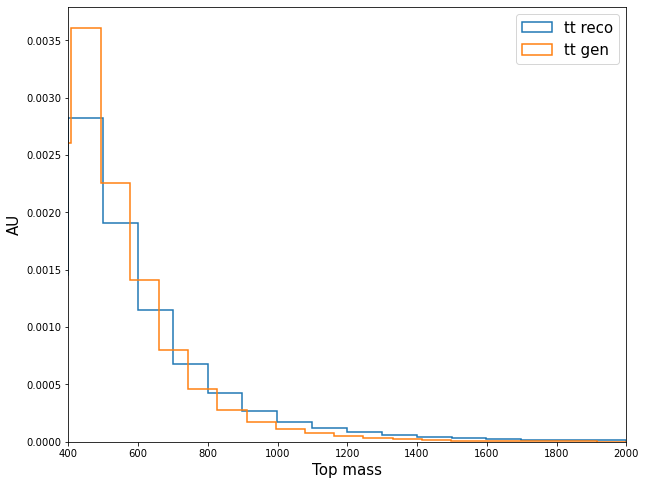

In [339]:
tt_mass = np.array(tt_mass)
fig, ax = plt.subplots(figsize=(10,8))

ax.hist(tt_mass[tt_mass < 2000]        , histtype='step', label='tt reco', linewidth=1.5, density=True, bins=20)
ax.hist(tt_gen_mass[tt_gen_mass < 2000], histtype='step', label='tt gen', linewidth=1.5 , density=True, bins=20)
ax.set_xlim(400, 2000)
plt.xlabel('Top mass',  fontsize=15)
plt.ylabel('AU',  fontsize=15)
plt.legend(loc='upper right', fontsize=15)

In [15]:
pt   = tt_ptr['genpart_pt'].array()
eta  = tt_ptr['genpart_eta'].array()
phi  = tt_ptr['genpart_phi'].array()
pid  = tt_ptr['genpart_pid'].array()
mass = tt_ptr['genpart_mass'].array()

In [16]:
tt_gen_mass = []

for i in range(len(pid))          :  # Over events
    
    t_count    = 0                      
    tbar_count = 0                   
    gentop     = ROOT.TLorentzVector()
    genantitop = ROOT.TLorentzVector()
    
    gentop.SetPtEtaPhiM(pt[i][2], eta[i][2], phi[i][2], mass[i][2])  
    genantitop.SetPtEtaPhiM(pt[i][3], eta[i][3], phi[i][3], mass[i][3])
    tt_gen_mass.append((gentop + genantitop).M())
    
    '''
    for j in range(len(pid[i]))   :  # Over genparticles in an event 
        if pid[i][j] == 6  and t_count    == 0:
            gentop.SetPtEtaPhiM(pt[i][j], eta[i][j], phi[i][j], mass[i][j])
            t_count += 1
        if pid[i][j] == -6 and tbar_count == 0:
            genantitop.SetPtEtaPhiM(pt[i][j], eta[i][j], phi[i][j], mass[i][j])
            tbar_count += 1 
        if (t_count == 1 and tbar_count == 1) :
            tt_gen_mass.append((gentop + genantitop).M())
            break
    '''

In [17]:
tt_gen_mass = np.array(tt_gen_mass)

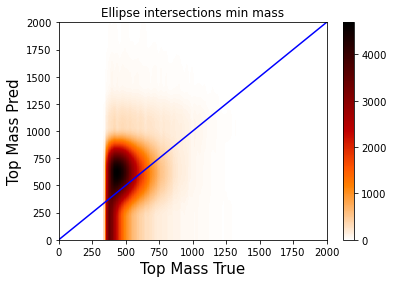

In [254]:
heatmap,xedges,yedges =np.histogram2d(tt_gen_mass[:100000],tt_mass,bins=200)
extent=[xedges[0],xedges[-1],yedges[0],yedges[-1]]

plt.imshow(heatmap.T ,extent=extent, origin='lower', aspect='auto')
plt.plot([0,2000],[0,2000],color='blue')
plt.set_cmap('gist_heat_r')
plt.xlabel("Top Mass True", fontsize=15)
plt.ylabel("Top Mass Pred", fontsize=15)
plt.title("Ellipse intersections min mass")
plt.xlim(0,2000)
plt.ylim(0,2000)
plt.colorbar()
plt.savefig('ellipse_int_heatmap.png')

In [157]:
diff = abs(tt_ST - tt_gen_mass)

In [162]:
len(diff[diff > 200])/ len(diff)

0.3001677192503102